# Import modules

In [1]:
import gdal
import shapefile
from osgeo import osr
import glob
from scipy import interpolate
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
floodmap=gdal.Open('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/CombinedOutput_FloodMap/NOR_Fluvial_100yr.tif')

In [3]:
arr = floodmap.ReadAsArray()

In [4]:
proj_wkt = floodmap.GetProjection()


In [5]:
proj = osr.SpatialReference()
proj.ImportFromWkt(proj_wkt)


0

In [6]:
geo_transform = floodmap.GetGeoTransform()

In [7]:
origin_x = geo_transform[0]
origin_y = geo_transform[3]
pixel_width = geo_transform[1]
pixel_height = geo_transform[5]
n_cols = floodmap.RasterXSize
n_rows = floodmap.RasterYSize
n_cols, n_rows

(23712, 29062)

In [8]:
band = floodmap.GetRasterBand(1)
gdal.GetDataTypeName(band.DataType)

'Float32'

In [9]:
extent_lonlat = (
    origin_x, 
    origin_x + (pixel_width * floodmap.RasterXSize),
    origin_y + (pixel_height * floodmap.RasterYSize),
    origin_y
)

## Idea 3
* Read in shapefile
* Match points and tangent to image
* plot difference across boundary

In [10]:
def find_nearest(array, value):
    ''' Find nearest value is an array '''
    idx=np.empty((value.size))
    for i in range(0,value.size):
        idx[i] = (np.abs(array-value[i])).argmin()
    return idx.astype('int')

In [11]:
sfiles=glob.glob('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/*.shp')

In [21]:
df=[]
for ii, s in enumerate(sfiles):
    sf = shapefile.Reader(s)
    sh_points=np.array(sf.shapes()[0].points)
    xpix=np.arange(extent_lonlat[0],extent_lonlat[1],pixel_width)
    ypix=np.arange(extent_lonlat[3],extent_lonlat[2],pixel_height)
    
# loop over shape points
    points=np.ones((5000,3))
    c=0
    pix_dist=np.array([1,5])

    for i in range(0,sh_points.shape[0]-1):        
        #need to interpolate between points in shapefile
        fx = interpolate.interp1d(sh_points[i:i+2,0],sh_points[i:i+2,1],kind='slinear',fill_value='extrapolate')
        if sh_points[i,0]<sh_points[i+1,0]:
            xnew=np.arange(sh_points[i,0],sh_points[i+1,0],pixel_width)
        else:
            xnew=np.arange(sh_points[i,0],sh_points[i+1,0],-pixel_width)
        ynew=fx(xnew)
        fy=interpolate.interp1d(sh_points[i:i+2,1],sh_points[i:i+2,0],kind='slinear',fill_value='extrapolate')
        if sh_points[i,1]>sh_points[i+1,1]:
            ynew_2=np.arange(sh_points[i,1],sh_points[i+1,1],pixel_height)
        else:
            ynew_2=np.arange(sh_points[i,1],sh_points[i+1,1],-pixel_height)
        xnew_2=fy(ynew_2)
        
        for j in range(xnew.shape[0]-1):
            try:
                #calculate difference in x and y for tangent
                dy=ynew[j+1]-ynew[j]
                dx=xnew[j+1]-xnew[j]
                angle=0.5*np.pi-np.arctan(dy/dx)
                t_x=pix_dist*pixel_width*np.cos(angle)#ideally should be 0.5*pixel but more stable if 1.1
                t_y=pix_dist*pixel_height*np.sin(angle)
                #inner value
                x_in=find_nearest(xpix,xnew[j]+t_x)
                y_in=find_nearest(ypix,ynew[j]+t_y)
                #outer value
                x_out=find_nearest(xpix,xnew[j]-t_x)
                y_out=find_nearest(ypix,ynew[j]-t_y)
            
                points[c,:]=[(np.max(arr[y_out,x_out])-np.max(arr[y_in,x_in]))/dx,xnew[j],ynew[j]]
                c+=1
            except(IndexError):
                print('issue')
        for j in range(xnew_2.shape[0]-1):
            #calculate difference in x and y for tangent
            dy=ynew_2[j+1]-ynew_2[j]
            dx=xnew_2[j+1]-xnew_2[j]
            angle=0.5*np.pi-np.arctan(dy/dx)
            t_x=pix_dist*pixel_width*np.cos(angle)#ideally should be 0.5*pixel but more stable if 1.1
            t_y=pix_dist*pixel_height*np.sin(angle)
            #inner value
            x_in=find_nearest(xpix,xnew_2[j]+t_x)
            y_in=find_nearest(ypix,ynew_2[j]+t_y)
        
            #outer value
            x_out=find_nearest(xpix,xnew_2[j]-t_x)
            y_out=find_nearest(ypix,ynew_2[j]-t_y)
            points[c,:]=[(np.max(arr[y_out,x_out])-np.max(arr[y_in,x_in]))/dx,xnew_2[j],ynew_2[j]]
            c+=1
    ind=points[:,0]<-100.0
    if ind.sum()>0:
        db = DBSCAN(eps=pixel_width*5, min_samples=6).fit(points[ind,1:3])
        labels = db.labels_
        ind_keep=labels>0
        data = {'Domain': s.split('/')[-1] * ind_keep.sum(),
        'lat': points[ind,2][ind_keep],
        'lon': points[ind,1][ind_keep]}

        df.append(pd.DataFrame(data))
    print('Domain ',s.split('/')[-1], ii,len(sfiles))
alldf = pd.concat(df)
geometry = [Point(xy) for xy in zip(alldf['lon'],alldf['lat'])]
gdf = GeoDataFrame(alldf, geometry=geometry)
gdf.to_file(filename='./all_points_pixspread_grouped')

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1000_1_Domain.shp 0 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1001_1_Domain.shp 1 5151
Domain  NOR_1002_1_Domain.shp 2 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1003_1_Domain.shp 3 5151
Domain  NOR_1004_1_Domain.shp 4 5151
Domain  NOR_1005_1_Domain.shp 5 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1006_1_Domain.shp 6 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1007_1_Domain.shp 7 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1008_1_Domain.shp 8 5151
Domain  NOR_1009_1_Domain.shp 9 5151
Domain  NOR_100_1_Domain.shp 10 5151
Domain  NOR_1010_1_Domain.shp 11 5151
Domain  NOR_1011_1_Domain.shp 12 5151
Domain  NOR_1012_1_Domain.shp 13 5151
Domain  NOR_1013_1_Domain.shp 14 5151
Domain  NOR_1014_1_Domain.shp 15 5151
Domain  NOR_1015_1_Domain.shp 16 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1016_1_Domain.shp 17 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1017_1_Domain.shp 18 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1018_1_Domain.shp 19 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1019_1_Domain.shp 20 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_101_1_Domain.shp 21 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1020_1_Domain.shp 22 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1021_1_Domain.shp 23 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1022_1_Domain.shp 24 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1023_1_Domain.shp 25 5151
Domain  NOR_1024_1_Domain.shp 26 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1025_1_Domain.shp 27 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1026_1_Domain.shp 28 5151
Domain  NOR_1027_1_Domain.shp 29 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1028_1_Domain.shp 30 5151
Domain  NOR_1029_1_Domain.shp 31 5151
Domain  NOR_102_1_Domain.shp 32 5151
Domain  NOR_1030_1_Domain.shp 33 5151
Domain  NOR_1031_1_Domain.shp 34 5151
Domain  NOR_1032_1_Domain.shp 35 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1033_1_Domain.shp 36 5151
Domain  NOR_1034_1_Domain.shp 37 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1035_1_Domain.shp 38 5151
Domain  NOR_1036_1_Domain.shp 39 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1037_1_Domain.shp 40 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1038_1_Domain.shp 41 5151
Domain  NOR_1039_1_Domain.shp 42 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_103_1_Domain.shp 43 5151
Domain  NOR_1040_1_Domain.shp 44 5151
Domain  NOR_1041_1_Domain.shp 45 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1042_1_Domain.shp 46 5151
Domain  NOR_1043_1_Domain.shp 47 5151
Domain  NOR_1044_1_Domain.shp 48 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1045_1_Domain.shp 49 5151
Domain  NOR_1046_1_Domain.shp 50 5151
Domain  NOR_1047_1_Domain.shp 51 5151
Domain  NOR_1048_1_Domain.shp 52 5151
Domain  NOR_1049_1_Domain.shp 53 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_104_1_Domain.shp 54 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1050_1_Domain.shp 55 5151
Domain  NOR_1051_1_Domain.shp 56 5151
Domain  NOR_1052_1_Domain.shp 57 5151
Domain  NOR_1053_1_Domain.shp 58 5151
Domain  NOR_1054_1_Domain.shp 59 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1055_1_Domain.shp 60 5151
Domain  NOR_1056_1_Domain.shp 61 5151
Domain  NOR_1057_1_Domain.shp 62 5151
Domain  NOR_1058_1_Domain.shp 63 5151
Domain  NOR_1059_1_Domain.shp 64 5151
Domain  NOR_105_1_Domain.shp 65 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1060_1_Domain.shp 66 5151
Domain  NOR_1061_1_Domain.shp 67 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1062_1_Domain.shp 68 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1063_1_Domain.shp 69 5151
Domain  NOR_1064_1_Domain.shp 70 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1065_1_Domain.shp 71 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1066_1_Domain.shp 72 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1067_1_Domain.shp 73 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1068_1_Domain.shp 74 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1069_1_Domain.shp 75 5151
Domain  NOR_106_1_Domain.shp 76 5151
Domain  NOR_1070_1_Domain.shp 77 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1071_1_Domain.shp 78 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1072_1_Domain.shp 79 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1073_1_Domain.shp 80 5151
Domain  NOR_1074_1_Domain.shp 81 5151
Domain  NOR_1075_1_Domain.shp 82 5151
Domain  NOR_1076_1_Domain.shp 83 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1077_1_Domain.shp 84 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1078_1_Domain.shp 85 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1079_1_Domain.shp 86 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_107_1_Domain.shp 87 5151
Domain  NOR_1080_1_Domain.shp 88 5151
Domain  NOR_1081_1_Domain.shp 89 5151
Domain  NOR_1082_1_Domain.shp 90 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1083_1_Domain.shp 91 5151
Domain  NOR_1084_1_Domain.shp 92 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1085_1_Domain.shp 93 5151
Domain  NOR_1086_1_Domain.shp 94 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1087_1_Domain.shp 95 5151
Domain  NOR_1088_1_Domain.shp 96 5151
Domain  NOR_1089_1_Domain.shp 97 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_108_1_Domain.shp 98 5151
Domain  NOR_1090_1_Domain.shp 99 5151
Domain  NOR_1091_1_Domain.shp 100 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1092_1_Domain.shp 101 5151
Domain  NOR_1093_1_Domain.shp 102 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1094_1_Domain.shp 103 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1095_1_Domain.shp 104 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1096_1_Domain.shp 105 5151
Domain  NOR_1097_1_Domain.shp 106 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1098_1_Domain.shp 107 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1099_1_Domain.shp 108 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_109_1_Domain.shp 109 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_10_1_Domain.shp 110 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1100_1_Domain.shp 111 5151
Domain  NOR_1101_1_Domain.shp 112 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1102_1_Domain.shp 113 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1103_1_Domain.shp 114 5151
Domain  NOR_1104_1_Domain.shp 115 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1105_1_Domain.shp 116 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1106_1_Domain.shp 117 5151
Domain  NOR_1107_1_Domain.shp 118 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1108_1_Domain.shp 119 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1109_1_Domain.shp 120 5151
Domain  NOR_110_1_Domain.shp 121 5151
Domain  NOR_1110_1_Domain.shp 122 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1111_1_Domain.shp 123 5151
Domain  NOR_1112_1_Domain.shp 124 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1113_1_Domain.shp 125 5151
Domain  NOR_1114_1_Domain.shp 126 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1115_1_Domain.shp 127 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1116_1_Domain.shp 128 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1117_1_Domain.shp 129 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1118_1_Domain.shp 130 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1119_1_Domain.shp 131 5151
Domain  NOR_111_1_Domain.shp 132 5151
Domain  NOR_1120_1_Domain.shp 133 5151
Domain  NOR_1121_1_Domain.shp 134 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1122_1_Domain.shp 135 5151
Domain  NOR_1123_1_Domain.shp 136 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1124_1_Domain.shp 137 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1125_1_Domain.shp 138 5151
Domain  NOR_1126_1_Domain.shp 139 5151
Domain  NOR_1127_1_Domain.shp 140 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1128_1_Domain.shp 141 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1129_1_Domain.shp 142 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_112_1_Domain.shp 143 5151
Domain  NOR_1130_1_Domain.shp 144 5151
Domain  NOR_1131_1_Domain.shp 145 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1132_1_Domain.shp 146 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1133_1_Domain.shp 147 5151
Domain  NOR_1134_1_Domain.shp 148 5151
Domain  NOR_1135_1_Domain.shp 149 5151
Domain  NOR_1136_1_Domain.shp 150 5151
Domain  NOR_1137_1_Domain.shp 151 5151
Domain  NOR_1138_1_Domain.shp 152 5151
Domain  NOR_1139_1_Domain.shp 153 5151
Domain  NOR_113_1_Domain.shp 154 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1140_1_Domain.shp 155 5151
Domain  NOR_1141_1_Domain.shp 156 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1142_1_Domain.shp 157 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1143_1_Domain.shp 158 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1144_1_Domain.shp 159 5151
Domain  NOR_1145_1_Domain.shp 160 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1146_1_Domain.shp 161 5151
Domain  NOR_1147_1_Domain.shp 162 5151
Domain  NOR_1148_1_Domain.shp 163 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1149_1_Domain.shp 164 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_114_1_Domain.shp 165 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1150_1_Domain.shp 166 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1151_1_Domain.shp 167 5151
Domain  NOR_1152_1_Domain.shp 168 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1153_1_Domain.shp 169 5151
Domain  NOR_1154_1_Domain.shp 170 5151
Domain  NOR_1155_1_Domain.shp 171 5151
Domain  NOR_1156_1_Domain.shp 172 5151
Domain  NOR_1157_1_Domain.shp 173 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1158_1_Domain.shp 174 5151
Domain  NOR_1159_1_Domain.shp 175 5151
Domain  NOR_115_1_Domain.shp 176 5151
Domain  NOR_1160_1_Domain.shp 177 5151
Domain  NOR_1161_1_Domain.shp 178 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1162_1_Domain.shp 179 5151
Domain  NOR_1163_1_Domain.shp 180 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1164_1_Domain.shp 181 5151
Domain  NOR_1165_1_Domain.shp 182 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1166_1_Domain.shp 183 5151
Domain  NOR_1167_1_Domain.shp 184 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1168_1_Domain.shp 185 5151
Domain  NOR_1169_1_Domain.shp 186 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_116_1_Domain.shp 187 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1170_1_Domain.shp 188 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1171_1_Domain.shp 189 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1172_1_Domain.shp 190 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1173_1_Domain.shp 191 5151
Domain  NOR_1174_1_Domain.shp 192 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1175_1_Domain.shp 193 5151
Domain  NOR_1176_1_Domain.shp 194 5151
Domain  NOR_1177_1_Domain.shp 195 5151
Domain  NOR_1178_1_Domain.shp 196 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1179_1_Domain.shp 197 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_117_1_Domain.shp 198 5151
Domain  NOR_1180_1_Domain.shp 199 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1181_1_Domain.shp 200 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1182_1_Domain.shp 201 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1183_1_Domain.shp 202 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1184_1_Domain.shp 203 5151
Domain  NOR_1185_1_Domain.shp 204 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1186_1_Domain.shp 205 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1187_1_Domain.shp 206 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1188_1_Domain.shp 207 5151
Domain  NOR_1189_1_Domain.shp 208 5151
Domain  NOR_118_1_Domain.shp 209 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1190_1_Domain.shp 210 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1191_1_Domain.shp 211 5151
Domain  NOR_1192_1_Domain.shp 212 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1193_1_Domain.shp 213 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1194_1_Domain.shp 214 5151
Domain  NOR_1195_1_Domain.shp 215 5151
Domain  NOR_1196_1_Domain.shp 216 5151
Domain  NOR_1197_1_Domain.shp 217 5151
Domain  NOR_1198_1_Domain.shp 218 5151
Domain  NOR_1199_1_Domain.shp 219 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_119_1_Domain.shp 220 5151
Domain  NOR_11_1_Domain.shp 221 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1200_1_Domain.shp 222 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1201_1_Domain.shp 223 5151
Domain  NOR_1202_1_Domain.shp 224 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1203_1_Domain.shp 225 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1204_1_Domain.shp 226 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1205_1_Domain.shp 227 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1206_1_Domain.shp 228 5151
Domain  NOR_1207_1_Domain.shp 229 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1208_1_Domain.shp 230 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1209_1_Domain.shp 231 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_120_1_Domain.shp 232 5151
Domain  NOR_1210_1_Domain.shp 233 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1211_1_Domain.shp 234 5151
Domain  NOR_1212_1_Domain.shp 235 5151
Domain  NOR_1213_1_Domain.shp 236 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1214_1_Domain.shp 237 5151
Domain  NOR_1215_1_Domain.shp 238 5151
Domain  NOR_1216_1_Domain.shp 239 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1217_1_Domain.shp 240 5151
Domain  NOR_1218_1_Domain.shp 241 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1219_1_Domain.shp 242 5151
Domain  NOR_121_1_Domain.shp 243 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1220_1_Domain.shp 244 5151
Domain  NOR_1221_1_Domain.shp 245 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1222_1_Domain.shp 246 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1223_1_Domain.shp 247 5151
Domain  NOR_1224_1_Domain.shp 248 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1225_1_Domain.shp 249 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1226_1_Domain.shp 250 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1227_1_Domain.shp 251 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1228_1_Domain.shp 252 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1229_1_Domain.shp 253 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_122_1_Domain.shp 254 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1230_1_Domain.shp 255 5151
Domain  NOR_1231_1_Domain.shp 256 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1232_1_Domain.shp 257 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1233_1_Domain.shp 258 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1234_1_Domain.shp 259 5151
Domain  NOR_1235_1_Domain.shp 260 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1236_1_Domain.shp 261 5151
Domain  NOR_1237_1_Domain.shp 262 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1238_1_Domain.shp 263 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1239_1_Domain.shp 264 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_123_1_Domain.shp 265 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1240_1_Domain.shp 266 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1241_1_Domain.shp 267 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1242_1_Domain.shp 268 5151
Domain  NOR_1243_1_Domain.shp 269 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1244_1_Domain.shp 270 5151
Domain  NOR_1245_1_Domain.shp 271 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1246_1_Domain.shp 272 5151
Domain  NOR_1247_1_Domain.shp 273 5151
Domain  NOR_1248_1_Domain.shp 274 5151
Domain  NOR_1249_1_Domain.shp 275 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_124_1_Domain.shp 276 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1250_1_Domain.shp 277 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1251_1_Domain.shp 278 5151
Domain  NOR_1252_1_Domain.shp 279 5151
Domain  NOR_1253_1_Domain.shp 280 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1254_1_Domain.shp 281 5151
Domain  NOR_1255_1_Domain.shp 282 5151
Domain  NOR_1256_1_Domain.shp 283 5151
Domain  NOR_1257_1_Domain.shp 284 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1258_1_Domain.shp 285 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1259_1_Domain.shp 286 5151
Domain  NOR_125_1_Domain.shp 287 5151
Domain  NOR_1260_1_Domain.shp 288 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1261_1_Domain.shp 289 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1262_1_Domain.shp 290 5151
Domain  NOR_1263_1_Domain.shp 291 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1264_1_Domain.shp 292 5151
Domain  NOR_1265_1_Domain.shp 293 5151
Domain  NOR_1266_1_Domain.shp 294 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1267_1_Domain.shp 295 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1268_1_Domain.shp 296 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1269_1_Domain.shp 297 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_126_1_Domain.shp 298 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1270_1_Domain.shp 299 5151
Domain  NOR_1271_1_Domain.shp 300 5151
Domain  NOR_1272_1_Domain.shp 301 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1273_1_Domain.shp 302 5151
Domain  NOR_1274_1_Domain.shp 303 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1275_1_Domain.shp 304 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1276_1_Domain.shp 305 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1277_1_Domain.shp 306 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1278_1_Domain.shp 307 5151
Domain  NOR_1279_1_Domain.shp 308 5151
Domain  NOR_127_1_Domain.shp 309 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1280_1_Domain.shp 310 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1281_1_Domain.shp 311 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1282_1_Domain.shp 312 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1283_1_Domain.shp 313 5151
Domain  NOR_1284_1_Domain.shp 314 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1285_1_Domain.shp 315 5151
Domain  NOR_1286_1_Domain.shp 316 5151
Domain  NOR_1287_1_Domain.shp 317 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1288_1_Domain.shp 318 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1289_1_Domain.shp 319 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_128_1_Domain.shp 320 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1290_1_Domain.shp 321 5151
Domain  NOR_1291_1_Domain.shp 322 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1292_1_Domain.shp 323 5151
Domain  NOR_1293_1_Domain.shp 324 5151
Domain  NOR_1294_1_Domain.shp 325 5151
Domain  NOR_1295_1_Domain.shp 326 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1296_1_Domain.shp 327 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1297_1_Domain.shp 328 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1298_1_Domain.shp 329 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1299_1_Domain.shp 330 5151
Domain  NOR_129_1_Domain.shp 331 5151
Domain  NOR_12_1_Domain.shp 332 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1300_1_Domain.shp 333 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1301_1_Domain.shp 334 5151
Domain  NOR_1302_1_Domain.shp 335 5151
Domain  NOR_1303_1_Domain.shp 336 5151
Domain  NOR_1304_1_Domain.shp 337 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1305_1_Domain.shp 338 5151
Domain  NOR_1306_1_Domain.shp 339 5151
Domain  NOR_1307_1_Domain.shp 340 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1308_1_Domain.shp 341 5151
Domain  NOR_1309_1_Domain.shp 342 5151
Domain  NOR_130_1_Domain.shp 343 5151
Domain  NOR_1310_1_Domain.shp 344 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1311_1_Domain.shp 345 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1312_1_Domain.shp 346 5151
Domain  NOR_1313_1_Domain.shp 347 5151
Domain  NOR_1314_1_Domain.shp 348 5151
Domain  NOR_1315_1_Domain.shp 349 5151
Domain  NOR_1316_1_Domain.shp 350 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1317_1_Domain.shp 351 5151
Domain  NOR_1318_1_Domain.shp 352 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1319_1_Domain.shp 353 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_131_1_Domain.shp 354 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1320_1_Domain.shp 355 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1321_1_Domain.shp 356 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1322_1_Domain.shp 357 5151
Domain  NOR_1323_1_Domain.shp 358 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1324_1_Domain.shp 359 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1325_1_Domain.shp 360 5151
Domain  NOR_1326_1_Domain.shp 361 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1327_1_Domain.shp 362 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1328_1_Domain.shp 363 5151
Domain  NOR_1329_1_Domain.shp 364 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_132_1_Domain.shp 365 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1330_1_Domain.shp 366 5151
Domain  NOR_1331_1_Domain.shp 367 5151
Domain  NOR_1332_1_Domain.shp 368 5151
Domain  NOR_1333_1_Domain.shp 369 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1334_1_Domain.shp 370 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1335_1_Domain.shp 371 5151
Domain  NOR_1336_1_Domain.shp 372 5151
Domain  NOR_1337_1_Domain.shp 373 5151
Domain  NOR_1338_1_Domain.shp 374 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1339_1_Domain.shp 375 5151
Domain  NOR_133_1_Domain.shp 376 5151
Domain  NOR_1340_1_Domain.shp 377 5151
Domain  NOR_1341_1_Domain.shp 378 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1342_1_Domain.shp 379 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1343_1_Domain.shp 380 5151
Domain  NOR_1344_1_Domain.shp 381 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1345_1_Domain.shp 382 5151
Domain  NOR_1346_1_Domain.shp 383 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1347_1_Domain.shp 384 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1348_1_Domain.shp 385 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1349_1_Domain.shp 386 5151
Domain  NOR_134_1_Domain.shp 387 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1350_1_Domain.shp 388 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1351_1_Domain.shp 389 5151
Domain  NOR_1352_1_Domain.shp 390 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1353_1_Domain.shp 391 5151
Domain  NOR_1354_1_Domain.shp 392 5151
Domain  NOR_1355_1_Domain.shp 393 5151
Domain  NOR_1356_1_Domain.shp 394 5151
Domain  NOR_1357_1_Domain.shp 395 5151
Domain  NOR_1358_1_Domain.shp 396 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1359_1_Domain.shp 397 5151
Domain  NOR_135_1_Domain.shp 398 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1360_1_Domain.shp 399 5151
Domain  NOR_1361_1_Domain.shp 400 5151
Domain  NOR_1362_1_Domain.shp 401 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1363_1_Domain.shp 402 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1364_1_Domain.shp 403 5151
Domain  NOR_1365_1_Domain.shp 404 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1366_1_Domain.shp 405 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1367_1_Domain.shp 406 5151
Domain  NOR_1368_1_Domain.shp 407 5151
Domain  NOR_1369_1_Domain.shp 408 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_136_1_Domain.shp 409 5151
Domain  NOR_1370_1_Domain.shp 410 5151
Domain  NOR_1371_1_Domain.shp 411 5151
Domain  NOR_1372_1_Domain.shp 412 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1373_1_Domain.shp 413 5151
Domain  NOR_1374_1_Domain.shp 414 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1375_1_Domain.shp 415 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1376_1_Domain.shp 416 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1377_1_Domain.shp 417 5151
Domain  NOR_1378_1_Domain.shp 418 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1379_1_Domain.shp 419 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_137_1_Domain.shp 420 5151
Domain  NOR_1380_1_Domain.shp 421 5151
Domain  NOR_1381_1_Domain.shp 422 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1382_1_Domain.shp 423 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1383_1_Domain.shp 424 5151
Domain  NOR_1384_1_Domain.shp 425 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1385_1_Domain.shp 426 5151
Domain  NOR_1386_1_Domain.shp 427 5151
Domain  NOR_1387_1_Domain.shp 428 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1388_1_Domain.shp 429 5151
Domain  NOR_1389_1_Domain.shp 430 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_138_1_Domain.shp 431 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1390_1_Domain.shp 432 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1391_1_Domain.shp 433 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1392_1_Domain.shp 434 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1393_1_Domain.shp 435 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1394_1_Domain.shp 436 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1395_1_Domain.shp 437 5151
Domain  NOR_1396_1_Domain.shp 438 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1397_1_Domain.shp 439 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1398_1_Domain.shp 440 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1399_1_Domain.shp 441 5151
Domain  NOR_139_1_Domain.shp 442 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_13_1_Domain.shp 443 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1400_1_Domain.shp 444 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1401_1_Domain.shp 445 5151
Domain  NOR_1402_1_Domain.shp 446 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1403_1_Domain.shp 447 5151
Domain  NOR_1404_1_Domain.shp 448 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1405_1_Domain.shp 449 5151
Domain  NOR_1406_1_Domain.shp 450 5151
Domain  NOR_1407_1_Domain.shp 451 5151
Domain  NOR_1408_1_Domain.shp 452 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1409_1_Domain.shp 453 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_140_1_Domain.shp 454 5151
Domain  NOR_1410_1_Domain.shp 455 5151
Domain  NOR_1411_1_Domain.shp 456 5151
Domain  NOR_1412_1_Domain.shp 457 5151
Domain  NOR_1413_1_Domain.shp 458 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1414_1_Domain.shp 459 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1415_1_Domain.shp 460 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1416_1_Domain.shp 461 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1417_1_Domain.shp 462 5151
Domain  NOR_1418_1_Domain.shp 463 5151
Domain  NOR_1419_1_Domain.shp 464 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_141_1_Domain.shp 465 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1420_1_Domain.shp 466 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1421_1_Domain.shp 467 5151
Domain  NOR_1422_1_Domain.shp 468 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1423_1_Domain.shp 469 5151
Domain  NOR_1424_1_Domain.shp 470 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1425_1_Domain.shp 471 5151
Domain  NOR_1426_1_Domain.shp 472 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1427_1_Domain.shp 473 5151
Domain  NOR_1428_1_Domain.shp 474 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1429_1_Domain.shp 475 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_142_1_Domain.shp 476 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1430_1_Domain.shp 477 5151
Domain  NOR_1431_1_Domain.shp 478 5151
Domain  NOR_1432_1_Domain.shp 479 5151
Domain  NOR_1433_1_Domain.shp 480 5151
Domain  NOR_1434_1_Domain.shp 481 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1435_1_Domain.shp 482 5151
Domain  NOR_1436_1_Domain.shp 483 5151
Domain  NOR_1437_1_Domain.shp 484 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1438_1_Domain.shp 485 5151
Domain  NOR_1439_1_Domain.shp 486 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_143_1_Domain.shp 487 5151
Domain  NOR_1440_1_Domain.shp 488 5151
Domain  NOR_1441_1_Domain.shp 489 5151
Domain  NOR_1442_1_Domain.shp 490 5151
Domain  NOR_1443_1_Domain.shp 491 5151
Domain  NOR_1444_1_Domain.shp 492 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1445_1_Domain.shp 493 5151
Domain  NOR_1446_1_Domain.shp 494 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1447_1_Domain.shp 495 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1448_1_Domain.shp 496 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1449_1_Domain.shp 497 5151
Domain  NOR_144_1_Domain.shp 498 5151
Domain  NOR_1450_1_Domain.shp 499 5151
Domain  NOR_1451_1_Domain.shp 500 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1452_1_Domain.shp 501 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1453_1_Domain.shp 502 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1454_1_Domain.shp 503 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1455_1_Domain.shp 504 5151
Domain  NOR_1456_1_Domain.shp 505 5151
Domain  NOR_1457_1_Domain.shp 506 5151
Domain  NOR_1458_1_Domain.shp 507 5151
Domain  NOR_1459_1_Domain.shp 508 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_145_1_Domain.shp 509 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1460_1_Domain.shp 510 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1461_1_Domain.shp 511 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1462_1_Domain.shp 512 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1463_1_Domain.shp 513 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1464_1_Domain.shp 514 5151
Domain  NOR_1465_1_Domain.shp 515 5151
Domain  NOR_1466_1_Domain.shp 516 5151
Domain  NOR_1467_1_Domain.shp 517 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1468_1_Domain.shp 518 5151
Domain  NOR_1469_1_Domain.shp 519 5151
Domain  NOR_146_1_Domain.shp 520 5151
Domain  NOR_1470_1_Domain.shp 521 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1471_1_Domain.shp 522 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1472_1_Domain.shp 523 5151
Domain  NOR_1473_1_Domain.shp 524 5151
Domain  NOR_1474_1_Domain.shp 525 5151
Domain  NOR_1475_1_Domain.shp 526 5151
Domain  NOR_1476_1_Domain.shp 527 5151
Domain  NOR_1477_1_Domain.shp 528 5151
Domain  NOR_1478_1_Domain.shp 529 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1479_1_Domain.shp 530 5151
Domain  NOR_147_1_Domain.shp 531 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1480_1_Domain.shp 532 5151
Domain  NOR_1481_1_Domain.shp 533 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1482_1_Domain.shp 534 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1483_1_Domain.shp 535 5151
Domain  NOR_1484_1_Domain.shp 536 5151
Domain  NOR_1485_1_Domain.shp 537 5151
Domain  NOR_1486_1_Domain.shp 538 5151
Domain  NOR_1487_1_Domain.shp 539 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1488_1_Domain.shp 540 5151
Domain  NOR_1489_1_Domain.shp 541 5151
Domain  NOR_148_1_Domain.shp 542 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1490_1_Domain.shp 543 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1491_1_Domain.shp 544 5151
Domain  NOR_1492_1_Domain.shp 545 5151
Domain  NOR_1493_1_Domain.shp 546 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1494_1_Domain.shp 547 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1495_1_Domain.shp 548 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1496_1_Domain.shp 549 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1497_1_Domain.shp 550 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1498_1_Domain.shp 551 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1499_1_Domain.shp 552 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_149_1_Domain.shp 553 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_14_1_Domain.shp 554 5151
Domain  NOR_1500_1_Domain.shp 555 5151
Domain  NOR_1501_1_Domain.shp 556 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1502_1_Domain.shp 557 5151
Domain  NOR_1503_1_Domain.shp 558 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1504_1_Domain.shp 559 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1505_1_Domain.shp 560 5151
Domain  NOR_1506_1_Domain.shp 561 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1507_1_Domain.shp 562 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1508_1_Domain.shp 563 5151
Domain  NOR_1509_1_Domain.shp 564 5151
Domain  NOR_150_1_Domain.shp 565 5151
Domain  NOR_1510_1_Domain.shp 566 5151
Domain  NOR_1511_1_Domain.shp 567 5151
Domain  NOR_1512_1_Domain.shp 568 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1513_1_Domain.shp 569 5151
Domain  NOR_1514_1_Domain.shp 570 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1515_1_Domain.shp 571 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1516_1_Domain.shp 572 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1517_1_Domain.shp 573 5151
Domain  NOR_1518_1_Domain.shp 574 5151
Domain  NOR_1519_1_Domain.shp 575 5151
Domain  NOR_151_1_Domain.shp 576 5151
Domain  NOR_1520_1_Domain.shp 577 5151
Domain  NOR_1521_1_Domain.shp 578 5151
Domain  NOR_1522_1_Domain.shp 579 5151
Domain  NOR_1523_1_Domain.shp 580 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1524_1_Domain.shp 581 5151
Domain  NOR_1525_1_Domain.shp 582 5151
Domain  NOR_1526_1_Domain.shp 583 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1527_1_Domain.shp 584 5151
Domain  NOR_1528_1_Domain.shp 585 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1529_1_Domain.shp 586 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_152_1_Domain.shp 587 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1530_1_Domain.shp 588 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1531_1_Domain.shp 589 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1532_1_Domain.shp 590 5151
Domain  NOR_1533_1_Domain.shp 591 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1534_1_Domain.shp 592 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1535_1_Domain.shp 593 5151
Domain  NOR_1536_1_Domain.shp 594 5151
Domain  NOR_1537_1_Domain.shp 595 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1538_1_Domain.shp 596 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1539_1_Domain.shp 597 5151
Domain  NOR_153_1_Domain.shp 598 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1540_1_Domain.shp 599 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1541_1_Domain.shp 600 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1542_1_Domain.shp 601 5151
Domain  NOR_1543_1_Domain.shp 602 5151
Domain  NOR_1544_1_Domain.shp 603 5151
Domain  NOR_1545_1_Domain.shp 604 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1546_1_Domain.shp 605 5151
Domain  NOR_1547_1_Domain.shp 606 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1548_1_Domain.shp 607 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1549_1_Domain.shp 608 5151
Domain  NOR_154_1_Domain.shp 609 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1550_1_Domain.shp 610 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1551_1_Domain.shp 611 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1552_1_Domain.shp 612 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1553_1_Domain.shp 613 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1554_1_Domain.shp 614 5151
Domain  NOR_1555_1_Domain.shp 615 5151
Domain  NOR_1556_1_Domain.shp 616 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1557_1_Domain.shp 617 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1558_1_Domain.shp 618 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1559_1_Domain.shp 619 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_155_1_Domain.shp 620 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1560_1_Domain.shp 621 5151
Domain  NOR_1561_1_Domain.shp 622 5151
Domain  NOR_1562_1_Domain.shp 623 5151
Domain  NOR_1563_1_Domain.shp 624 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1564_1_Domain.shp 625 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1565_1_Domain.shp 626 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1566_1_Domain.shp 627 5151
Domain  NOR_1567_1_Domain.shp 628 5151
Domain  NOR_1568_1_Domain.shp 629 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1569_1_Domain.shp 630 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_156_1_Domain.shp 631 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1570_1_Domain.shp 632 5151
Domain  NOR_1571_1_Domain.shp 633 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1572_1_Domain.shp 634 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1573_1_Domain.shp 635 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1574_1_Domain.shp 636 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1575_1_Domain.shp 637 5151
Domain  NOR_1576_1_Domain.shp 638 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1577_1_Domain.shp 639 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1578_1_Domain.shp 640 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1579_1_Domain.shp 641 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_157_1_Domain.shp 642 5151
Domain  NOR_1580_1_Domain.shp 643 5151
Domain  NOR_1581_1_Domain.shp 644 5151
Domain  NOR_1582_1_Domain.shp 645 5151
Domain  NOR_1583_1_Domain.shp 646 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1584_1_Domain.shp 647 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1585_1_Domain.shp 648 5151
Domain  NOR_1586_1_Domain.shp 649 5151
Domain  NOR_1587_1_Domain.shp 650 5151
Domain  NOR_1588_1_Domain.shp 651 5151
Domain  NOR_1589_1_Domain.shp 652 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_158_1_Domain.shp 653 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1590_1_Domain.shp 654 5151
Domain  NOR_1591_1_Domain.shp 655 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1592_1_Domain.shp 656 5151
Domain  NOR_1593_1_Domain.shp 657 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1594_1_Domain.shp 658 5151
Domain  NOR_1595_1_Domain.shp 659 5151
Domain  NOR_1596_1_Domain.shp 660 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1597_1_Domain.shp 661 5151
Domain  NOR_1598_1_Domain.shp 662 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1599_1_Domain.shp 663 5151
Domain  NOR_159_1_Domain.shp 664 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_15_1_Domain.shp 665 5151
Domain  NOR_1600_1_Domain.shp 666 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1601_1_Domain.shp 667 5151
Domain  NOR_1602_1_Domain.shp 668 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1603_1_Domain.shp 669 5151
Domain  NOR_1604_1_Domain.shp 670 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1605_1_Domain.shp 671 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1606_1_Domain.shp 672 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1607_1_Domain.shp 673 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1608_1_Domain.shp 674 5151
Domain  NOR_1609_1_Domain.shp 675 5151
Domain  NOR_160_1_Domain.shp 676 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1610_1_Domain.shp 677 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1611_1_Domain.shp 678 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1612_1_Domain.shp 679 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1613_1_Domain.shp 680 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1614_1_Domain.shp 681 5151
Domain  NOR_1615_1_Domain.shp 682 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1616_1_Domain.shp 683 5151
Domain  NOR_1617_1_Domain.shp 684 5151
Domain  NOR_1618_1_Domain.shp 685 5151
Domain  NOR_1619_1_Domain.shp 686 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_161_1_Domain.shp 687 5151
Domain  NOR_1620_1_Domain.shp 688 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1621_1_Domain.shp 689 5151
Domain  NOR_1622_1_Domain.shp 690 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1623_1_Domain.shp 691 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1624_1_Domain.shp 692 5151
Domain  NOR_1625_1_Domain.shp 693 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1626_1_Domain.shp 694 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1627_1_Domain.shp 695 5151
Domain  NOR_1628_1_Domain.shp 696 5151
Domain  NOR_1629_1_Domain.shp 697 5151
Domain  NOR_162_1_Domain.shp 698 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1630_1_Domain.shp 699 5151
Domain  NOR_1631_1_Domain.shp 700 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1632_1_Domain.shp 701 5151
Domain  NOR_1633_1_Domain.shp 702 5151
Domain  NOR_1634_1_Domain.shp 703 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1635_1_Domain.shp 704 5151
Domain  NOR_1636_1_Domain.shp 705 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1637_1_Domain.shp 706 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1638_1_Domain.shp 707 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1639_1_Domain.shp 708 5151
Domain  NOR_163_1_Domain.shp 709 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1640_1_Domain.shp 710 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1641_1_Domain.shp 711 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1642_1_Domain.shp 712 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1643_1_Domain.shp 713 5151
Domain  NOR_1644_1_Domain.shp 714 5151
Domain  NOR_1645_1_Domain.shp 715 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1646_1_Domain.shp 716 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1647_1_Domain.shp 717 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1648_1_Domain.shp 718 5151
Domain  NOR_1649_1_Domain.shp 719 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_164_1_Domain.shp 720 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1650_1_Domain.shp 721 5151
Domain  NOR_1651_1_Domain.shp 722 5151
Domain  NOR_1652_1_Domain.shp 723 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1653_1_Domain.shp 724 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1654_1_Domain.shp 725 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1655_1_Domain.shp 726 5151
Domain  NOR_1656_1_Domain.shp 727 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1657_1_Domain.shp 728 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1658_1_Domain.shp 729 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1659_1_Domain.shp 730 5151
Domain  NOR_165_1_Domain.shp 731 5151
Domain  NOR_1660_1_Domain.shp 732 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1661_1_Domain.shp 733 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1662_1_Domain.shp 734 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1663_1_Domain.shp 735 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1664_1_Domain.shp 736 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1665_1_Domain.shp 737 5151
Domain  NOR_1666_1_Domain.shp 738 5151
Domain  NOR_1667_1_Domain.shp 739 5151
Domain  NOR_1668_1_Domain.shp 740 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1669_1_Domain.shp 741 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_166_1_Domain.shp 742 5151
Domain  NOR_1670_1_Domain.shp 743 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1671_1_Domain.shp 744 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1672_1_Domain.shp 745 5151
Domain  NOR_1673_1_Domain.shp 746 5151
Domain  NOR_1674_1_Domain.shp 747 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1675_1_Domain.shp 748 5151
Domain  NOR_1676_1_Domain.shp 749 5151
Domain  NOR_1677_1_Domain.shp 750 5151
Domain  NOR_1678_1_Domain.shp 751 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1679_1_Domain.shp 752 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_167_1_Domain.shp 753 5151
Domain  NOR_1680_1_Domain.shp 754 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1681_1_Domain.shp 755 5151
Domain  NOR_1682_1_Domain.shp 756 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1683_1_Domain.shp 757 5151
Domain  NOR_1684_1_Domain.shp 758 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1685_1_Domain.shp 759 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1686_1_Domain.shp 760 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1687_1_Domain.shp 761 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1688_1_Domain.shp 762 5151
Domain  NOR_1689_1_Domain.shp 763 5151
Domain  NOR_168_1_Domain.shp 764 5151
Domain  NOR_1690_1_Domain.shp 765 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1691_1_Domain.shp 766 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1692_1_Domain.shp 767 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1693_1_Domain.shp 768 5151
Domain  NOR_1694_1_Domain.shp 769 5151
Domain  NOR_1695_1_Domain.shp 770 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1696_1_Domain.shp 771 5151
Domain  NOR_1697_1_Domain.shp 772 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1698_1_Domain.shp 773 5151
Domain  NOR_1699_1_Domain.shp 774 5151
Domain  NOR_169_1_Domain.shp 775 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_16_1_Domain.shp 776 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1700_1_Domain.shp 777 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1701_1_Domain.shp 778 5151
Domain  NOR_1702_1_Domain.shp 779 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1703_1_Domain.shp 780 5151
Domain  NOR_1704_1_Domain.shp 781 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1705_1_Domain.shp 782 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1706_1_Domain.shp 783 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1707_1_Domain.shp 784 5151
Domain  NOR_1708_1_Domain.shp 785 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1709_1_Domain.shp 786 5151
Domain  NOR_170_1_Domain.shp 787 5151
Domain  NOR_1710_1_Domain.shp 788 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1711_1_Domain.shp 789 5151
Domain  NOR_1712_1_Domain.shp 790 5151
Domain  NOR_1713_1_Domain.shp 791 5151
Domain  NOR_1714_1_Domain.shp 792 5151
Domain  NOR_1715_1_Domain.shp 793 5151
Domain  NOR_1716_1_Domain.shp 794 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1717_1_Domain.shp 795 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1718_1_Domain.shp 796 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1719_1_Domain.shp 797 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_171_1_Domain.shp 798 5151
Domain  NOR_1720_1_Domain.shp 799 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1721_1_Domain.shp 800 5151
Domain  NOR_1722_1_Domain.shp 801 5151
Domain  NOR_1723_1_Domain.shp 802 5151
Domain  NOR_1724_1_Domain.shp 803 5151
Domain  NOR_1725_1_Domain.shp 804 5151
Domain  NOR_1726_1_Domain.shp 805 5151
Domain  NOR_1727_1_Domain.shp 806 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1728_1_Domain.shp 807 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1729_1_Domain.shp 808 5151
Domain  NOR_172_1_Domain.shp 809 5151
Domain  NOR_1730_1_Domain.shp 810 5151
Domain  NOR_1731_1_Domain.shp 811 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1732_1_Domain.shp 812 5151
Domain  NOR_1733_1_Domain.shp 813 5151
Domain  NOR_1734_1_Domain.shp 814 5151
Domain  NOR_1735_1_Domain.shp 815 5151
Domain  NOR_1736_1_Domain.shp 816 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1737_1_Domain.shp 817 5151
Domain  NOR_1738_1_Domain.shp 818 5151
Domain  NOR_1739_1_Domain.shp 819 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_173_1_Domain.shp 820 5151
Domain  NOR_1740_1_Domain.shp 821 5151
Domain  NOR_1741_1_Domain.shp 822 5151
Domain  NOR_1742_1_Domain.shp 823 5151
Domain  NOR_1743_1_Domain.shp 824 5151
Domain  NOR_1744_1_Domain.shp 825 5151
Domain  NOR_1745_1_Domain.shp 826 5151
Domain  NOR_1746_1_Domain.shp 827 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1747_1_Domain.shp 828 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1748_1_Domain.shp 829 5151
Domain  NOR_1749_1_Domain.shp 830 5151
Domain  NOR_174_1_Domain.shp 831 5151
Domain  NOR_1750_1_Domain.shp 832 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1751_1_Domain.shp 833 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1752_1_Domain.shp 834 5151
Domain  NOR_1753_1_Domain.shp 835 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1754_1_Domain.shp 836 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1755_1_Domain.shp 837 5151
Domain  NOR_1756_1_Domain.shp 838 5151
Domain  NOR_1757_1_Domain.shp 839 5151
Domain  NOR_1758_1_Domain.shp 840 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1759_1_Domain.shp 841 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_175_1_Domain.shp 842 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1760_1_Domain.shp 843 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1761_1_Domain.shp 844 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1762_1_Domain.shp 845 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1763_1_Domain.shp 846 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1764_1_Domain.shp 847 5151
Domain  NOR_1765_1_Domain.shp 848 5151
Domain  NOR_1766_1_Domain.shp 849 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1767_1_Domain.shp 850 5151
Domain  NOR_1768_1_Domain.shp 851 5151
Domain  NOR_1769_1_Domain.shp 852 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_176_1_Domain.shp 853 5151
Domain  NOR_1770_1_Domain.shp 854 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1771_1_Domain.shp 855 5151
Domain  NOR_1772_1_Domain.shp 856 5151
Domain  NOR_1773_1_Domain.shp 857 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1774_1_Domain.shp 858 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1775_1_Domain.shp 859 5151
Domain  NOR_1776_1_Domain.shp 860 5151
Domain  NOR_1777_1_Domain.shp 861 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1778_1_Domain.shp 862 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1779_1_Domain.shp 863 5151
Domain  NOR_177_1_Domain.shp 864 5151
Domain  NOR_1780_1_Domain.shp 865 5151
Domain  NOR_1781_1_Domain.shp 866 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1782_1_Domain.shp 867 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1783_1_Domain.shp 868 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1784_1_Domain.shp 869 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1785_1_Domain.shp 870 5151
Domain  NOR_1786_1_Domain.shp 871 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1787_1_Domain.shp 872 5151
Domain  NOR_1788_1_Domain.shp 873 5151
Domain  NOR_1789_1_Domain.shp 874 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_178_1_Domain.shp 875 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1790_1_Domain.shp 876 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1791_1_Domain.shp 877 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1792_1_Domain.shp 878 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1793_1_Domain.shp 879 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1794_1_Domain.shp 880 5151
Domain  NOR_1795_1_Domain.shp 881 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1796_1_Domain.shp 882 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1797_1_Domain.shp 883 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1798_1_Domain.shp 884 5151
Domain  NOR_1799_1_Domain.shp 885 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_179_1_Domain.shp 886 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_17_1_Domain.shp 887 5151
Domain  NOR_1800_1_Domain.shp 888 5151
Domain  NOR_1801_1_Domain.shp 889 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1802_1_Domain.shp 890 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1803_1_Domain.shp 891 5151
Domain  NOR_1804_1_Domain.shp 892 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1805_1_Domain.shp 893 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1806_1_Domain.shp 894 5151
Domain  NOR_1807_1_Domain.shp 895 5151
Domain  NOR_1808_1_Domain.shp 896 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1809_1_Domain.shp 897 5151
Domain  NOR_180_1_Domain.shp 898 5151
Domain  NOR_1810_1_Domain.shp 899 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1811_1_Domain.shp 900 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1812_1_Domain.shp 901 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1813_1_Domain.shp 902 5151
Domain  NOR_1814_1_Domain.shp 903 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1815_1_Domain.shp 904 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1816_1_Domain.shp 905 5151
Domain  NOR_1817_1_Domain.shp 906 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1818_1_Domain.shp 907 5151
Domain  NOR_1819_1_Domain.shp 908 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_181_1_Domain.shp 909 5151
Domain  NOR_1820_1_Domain.shp 910 5151
Domain  NOR_1821_1_Domain.shp 911 5151
Domain  NOR_1822_1_Domain.shp 912 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1823_1_Domain.shp 913 5151
Domain  NOR_1824_1_Domain.shp 914 5151
Domain  NOR_1825_1_Domain.shp 915 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1826_1_Domain.shp 916 5151
Domain  NOR_1827_1_Domain.shp 917 5151
Domain  NOR_1828_1_Domain.shp 918 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1829_1_Domain.shp 919 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_182_1_Domain.shp 920 5151
Domain  NOR_1830_1_Domain.shp 921 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1831_1_Domain.shp 922 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1832_1_Domain.shp 923 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1833_1_Domain.shp 924 5151
Domain  NOR_1834_1_Domain.shp 925 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1835_1_Domain.shp 926 5151
Domain  NOR_1836_1_Domain.shp 927 5151
Domain  NOR_1837_1_Domain.shp 928 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1838_1_Domain.shp 929 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1839_1_Domain.shp 930 5151
Domain  NOR_183_1_Domain.shp 931 5151
Domain  NOR_1840_1_Domain.shp 932 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1841_1_Domain.shp 933 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1842_1_Domain.shp 934 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1843_1_Domain.shp 935 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1844_1_Domain.shp 936 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1845_1_Domain.shp 937 5151
Domain  NOR_1846_1_Domain.shp 938 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1847_1_Domain.shp 939 5151
Domain  NOR_1848_1_Domain.shp 940 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1849_1_Domain.shp 941 5151
Domain  NOR_184_1_Domain.shp 942 5151
Domain  NOR_1850_1_Domain.shp 943 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1851_1_Domain.shp 944 5151
Domain  NOR_1852_1_Domain.shp 945 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1853_1_Domain.shp 946 5151
Domain  NOR_1854_1_Domain.shp 947 5151
Domain  NOR_1855_1_Domain.shp 948 5151
Domain  NOR_1856_1_Domain.shp 949 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1857_1_Domain.shp 950 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1858_1_Domain.shp 951 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1859_1_Domain.shp 952 5151
Domain  NOR_185_1_Domain.shp 953 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1860_1_Domain.shp 954 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1861_1_Domain.shp 955 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1862_1_Domain.shp 956 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1863_1_Domain.shp 957 5151
Domain  NOR_1864_1_Domain.shp 958 5151
Domain  NOR_1865_1_Domain.shp 959 5151
Domain  NOR_1866_1_Domain.shp 960 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1867_1_Domain.shp 961 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1868_1_Domain.shp 962 5151
Domain  NOR_1869_1_Domain.shp 963 5151
Domain  NOR_186_1_Domain.shp 964 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1870_1_Domain.shp 965 5151
Domain  NOR_1871_1_Domain.shp 966 5151
Domain  NOR_1872_1_Domain.shp 967 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1873_1_Domain.shp 968 5151
Domain  NOR_1874_1_Domain.shp 969 5151
Domain  NOR_1875_1_Domain.shp 970 5151
Domain  NOR_1876_1_Domain.shp 971 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1877_1_Domain.shp 972 5151
Domain  NOR_1878_1_Domain.shp 973 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1879_1_Domain.shp 974 5151
Domain  NOR_187_1_Domain.shp 975 5151
Domain  NOR_1880_1_Domain.shp 976 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1881_1_Domain.shp 977 5151
Domain  NOR_1882_1_Domain.shp 978 5151
Domain  NOR_1883_1_Domain.shp 979 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1884_1_Domain.shp 980 5151
Domain  NOR_1885_1_Domain.shp 981 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1886_1_Domain.shp 982 5151
Domain  NOR_1887_1_Domain.shp 983 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1888_1_Domain.shp 984 5151
Domain  NOR_1889_1_Domain.shp 985 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_188_1_Domain.shp 986 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1890_1_Domain.shp 987 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1891_1_Domain.shp 988 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1892_1_Domain.shp 989 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1893_1_Domain.shp 990 5151
Domain  NOR_1894_1_Domain.shp 991 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1895_1_Domain.shp 992 5151
Domain  NOR_1896_1_Domain.shp 993 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1897_1_Domain.shp 994 5151
Domain  NOR_1898_1_Domain.shp 995 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1899_1_Domain.shp 996 5151
Domain  NOR_189_1_Domain.shp 997 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_18_1_Domain.shp 998 5151
Domain  NOR_1900_1_Domain.shp 999 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1901_1_Domain.shp 1000 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1902_1_Domain.shp 1001 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1903_1_Domain.shp 1002 5151
Domain  NOR_1904_1_Domain.shp 1003 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1905_1_Domain.shp 1004 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1906_1_Domain.shp 1005 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1907_1_Domain.shp 1006 5151
Domain  NOR_1908_1_Domain.shp 1007 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1909_1_Domain.shp 1008 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_190_1_Domain.shp 1009 5151
Domain  NOR_1910_1_Domain.shp 1010 5151
Domain  NOR_1911_1_Domain.shp 1011 5151
Domain  NOR_1912_1_Domain.shp 1012 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1913_1_Domain.shp 1013 5151
Domain  NOR_1914_1_Domain.shp 1014 5151
Domain  NOR_1915_1_Domain.shp 1015 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1916_1_Domain.shp 1016 5151
Domain  NOR_1917_1_Domain.shp 1017 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1918_1_Domain.shp 1018 5151
Domain  NOR_1919_1_Domain.shp 1019 5151
Domain  NOR_191_1_Domain.shp 1020 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1920_1_Domain.shp 1021 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1921_1_Domain.shp 1022 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1922_1_Domain.shp 1023 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1923_1_Domain.shp 1024 5151
Domain  NOR_1924_1_Domain.shp 1025 5151
Domain  NOR_1925_1_Domain.shp 1026 5151
Domain  NOR_1926_1_Domain.shp 1027 5151
Domain  NOR_1927_1_Domain.shp 1028 5151
Domain  NOR_1928_1_Domain.shp 1029 5151
Domain  NOR_1929_1_Domain.shp 1030 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_192_1_Domain.shp 1031 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1930_1_Domain.shp 1032 5151
Domain  NOR_1931_1_Domain.shp 1033 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1932_1_Domain.shp 1034 5151
Domain  NOR_1933_1_Domain.shp 1035 5151
Domain  NOR_1934_1_Domain.shp 1036 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1935_1_Domain.shp 1037 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1936_1_Domain.shp 1038 5151
Domain  NOR_1937_1_Domain.shp 1039 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1938_1_Domain.shp 1040 5151
Domain  NOR_1939_1_Domain.shp 1041 5151
Domain  NOR_193_1_Domain.shp 1042 5151
Domain  NOR_1940_1_Domain.shp 1043 5151
Domain  NOR_1941_1_Domain.shp 1044 5151
Domain  NOR_1942_1_Domain.shp 1045 5151
Domain  NOR_1943_1_Domain.shp 1046 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1944_1_Domain.shp 1047 5151
Domain  NOR_1945_1_Domain.shp 1048 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1946_1_Domain.shp 1049 5151
Domain  NOR_1947_1_Domain.shp 1050 5151
Domain  NOR_1948_1_Domain.shp 1051 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1949_1_Domain.shp 1052 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_194_1_Domain.shp 1053 5151
Domain  NOR_1950_1_Domain.shp 1054 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1951_1_Domain.shp 1055 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1952_1_Domain.shp 1056 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1953_1_Domain.shp 1057 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1954_1_Domain.shp 1058 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1955_1_Domain.shp 1059 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1956_1_Domain.shp 1060 5151
Domain  NOR_1957_1_Domain.shp 1061 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1958_1_Domain.shp 1062 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1959_1_Domain.shp 1063 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_195_1_Domain.shp 1064 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1960_1_Domain.shp 1065 5151
Domain  NOR_1961_1_Domain.shp 1066 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1962_1_Domain.shp 1067 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1963_1_Domain.shp 1068 5151
Domain  NOR_1964_1_Domain.shp 1069 5151
Domain  NOR_1965_1_Domain.shp 1070 5151
Domain  NOR_1966_1_Domain.shp 1071 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1967_1_Domain.shp 1072 5151
Domain  NOR_1968_1_Domain.shp 1073 5151
Domain  NOR_1969_1_Domain.shp 1074 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_196_1_Domain.shp 1075 5151
Domain  NOR_1970_1_Domain.shp 1076 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1971_1_Domain.shp 1077 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1972_1_Domain.shp 1078 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1973_1_Domain.shp 1079 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1974_1_Domain.shp 1080 5151
Domain  NOR_1975_1_Domain.shp 1081 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1976_1_Domain.shp 1082 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1977_1_Domain.shp 1083 5151
Domain  NOR_1978_1_Domain.shp 1084 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1979_1_Domain.shp 1085 5151
Domain  NOR_197_1_Domain.shp 1086 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_1980_1_Domain.shp 1087 5151
Domain  NOR_1981_1_Domain.shp 1088 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1982_1_Domain.shp 1089 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1983_1_Domain.shp 1090 5151
Domain  NOR_1984_1_Domain.shp 1091 5151
Domain  NOR_1985_1_Domain.shp 1092 5151
Domain  NOR_1986_1_Domain.shp 1093 5151
Domain  NOR_1987_1_Domain.shp 1094 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1988_1_Domain.shp 1095 5151
Domain  NOR_1989_1_Domain.shp 1096 5151
Domain  NOR_198_1_Domain.shp 1097 5151
Domain  NOR_1990_1_Domain.shp 1098 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1991_1_Domain.shp 1099 5151
Domain  NOR_1992_1_Domain.shp 1100 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1993_1_Domain.shp 1101 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1994_1_Domain.shp 1102 5151
Domain  NOR_1995_1_Domain.shp 1103 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1996_1_Domain.shp 1104 5151
Domain  NOR_1997_1_Domain.shp 1105 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1998_1_Domain.shp 1106 5151
Domain  NOR_1999_1_Domain.shp 1107 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_199_1_Domain.shp 1108 5151
Domain  NOR_19_1_Domain.shp 1109 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_1_1_Domain.shp 1110 5151
Domain  NOR_2000_1_Domain.shp 1111 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2001_1_Domain.shp 1112 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2002_1_Domain.shp 1113 5151
Domain  NOR_2003_1_Domain.shp 1114 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2004_1_Domain.shp 1115 5151
Domain  NOR_2005_1_Domain.shp 1116 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2006_1_Domain.shp 1117 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2007_1_Domain.shp 1118 5151
Domain  NOR_2008_1_Domain.shp 1119 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2009_1_Domain.shp 1120 5151
Domain  NOR_200_1_Domain.shp 1121 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2010_1_Domain.shp 1122 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2011_1_Domain.shp 1123 5151
Domain  NOR_2012_1_Domain.shp 1124 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2013_1_Domain.shp 1125 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2014_1_Domain.shp 1126 5151
Domain  NOR_2015_1_Domain.shp 1127 5151
Domain  NOR_2016_1_Domain.shp 1128 5151
Domain  NOR_2017_1_Domain.shp 1129 5151
Domain  NOR_2018_1_Domain.shp 1130 5151
Domain  NOR_2019_1_Domain.shp 1131 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_201_1_Domain.shp 1132 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2020_1_Domain.shp 1133 5151
Domain  NOR_2021_1_Domain.shp 1134 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2022_1_Domain.shp 1135 5151
Domain  NOR_2023_1_Domain.shp 1136 5151
Domain  NOR_2024_1_Domain.shp 1137 5151
Domain  NOR_2025_1_Domain.shp 1138 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2026_1_Domain.shp 1139 5151
Domain  NOR_2027_1_Domain.shp 1140 5151
Domain  NOR_2028_1_Domain.shp 1141 5151
Domain  NOR_2029_1_Domain.shp 1142 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_202_1_Domain.shp 1143 5151
Domain  NOR_2030_1_Domain.shp 1144 5151
Domain  NOR_2031_1_Domain.shp 1145 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2032_1_Domain.shp 1146 5151
Domain  NOR_2033_1_Domain.shp 1147 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2034_1_Domain.shp 1148 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2035_1_Domain.shp 1149 5151
Domain  NOR_2036_1_Domain.shp 1150 5151
Domain  NOR_2037_1_Domain.shp 1151 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2038_1_Domain.shp 1152 5151
Domain  NOR_2039_1_Domain.shp 1153 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_203_1_Domain.shp 1154 5151
Domain  NOR_2040_1_Domain.shp 1155 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2041_1_Domain.shp 1156 5151
Domain  NOR_2042_1_Domain.shp 1157 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2043_1_Domain.shp 1158 5151
Domain  NOR_2044_1_Domain.shp 1159 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2045_1_Domain.shp 1160 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2046_1_Domain.shp 1161 5151
Domain  NOR_2047_1_Domain.shp 1162 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2048_1_Domain.shp 1163 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2049_1_Domain.shp 1164 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_204_1_Domain.shp 1165 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2050_1_Domain.shp 1166 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2051_1_Domain.shp 1167 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2052_1_Domain.shp 1168 5151
Domain  NOR_2053_1_Domain.shp 1169 5151
Domain  NOR_2054_1_Domain.shp 1170 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2055_1_Domain.shp 1171 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2056_1_Domain.shp 1172 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2057_1_Domain.shp 1173 5151
Domain  NOR_2058_1_Domain.shp 1174 5151
Domain  NOR_2059_1_Domain.shp 1175 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_205_1_Domain.shp 1176 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2060_1_Domain.shp 1177 5151
Domain  NOR_2061_1_Domain.shp 1178 5151
Domain  NOR_2062_1_Domain.shp 1179 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2063_1_Domain.shp 1180 5151
Domain  NOR_2064_1_Domain.shp 1181 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2065_1_Domain.shp 1182 5151
Domain  NOR_2066_1_Domain.shp 1183 5151
Domain  NOR_2067_1_Domain.shp 1184 5151
Domain  NOR_2068_1_Domain.shp 1185 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2069_1_Domain.shp 1186 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_206_1_Domain.shp 1187 5151
Domain  NOR_2070_1_Domain.shp 1188 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2071_1_Domain.shp 1189 5151
Domain  NOR_2072_1_Domain.shp 1190 5151
Domain  NOR_2073_1_Domain.shp 1191 5151
Domain  NOR_2074_1_Domain.shp 1192 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2075_1_Domain.shp 1193 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2076_1_Domain.shp 1194 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2077_1_Domain.shp 1195 5151
Domain  NOR_2078_1_Domain.shp 1196 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2079_1_Domain.shp 1197 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_207_1_Domain.shp 1198 5151
Domain  NOR_2080_1_Domain.shp 1199 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2081_1_Domain.shp 1200 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2082_1_Domain.shp 1201 5151
Domain  NOR_2083_1_Domain.shp 1202 5151
Domain  NOR_2084_1_Domain.shp 1203 5151
Domain  NOR_2085_1_Domain.shp 1204 5151
Domain  NOR_2086_1_Domain.shp 1205 5151
Domain  NOR_2087_1_Domain.shp 1206 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2088_1_Domain.shp 1207 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2089_1_Domain.shp 1208 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_208_1_Domain.shp 1209 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2090_1_Domain.shp 1210 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2091_1_Domain.shp 1211 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2092_1_Domain.shp 1212 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2093_1_Domain.shp 1213 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2094_1_Domain.shp 1214 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2095_1_Domain.shp 1215 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2096_1_Domain.shp 1216 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2097_1_Domain.shp 1217 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2098_1_Domain.shp 1218 5151
Domain  NOR_2099_1_Domain.shp 1219 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_209_1_Domain.shp 1220 5151
Domain  NOR_20_1_Domain.shp 1221 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2100_1_Domain.shp 1222 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2101_1_Domain.shp 1223 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2102_1_Domain.shp 1224 5151
Domain  NOR_2103_1_Domain.shp 1225 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2104_1_Domain.shp 1226 5151
Domain  NOR_2105_1_Domain.shp 1227 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2106_1_Domain.shp 1228 5151
Domain  NOR_2107_1_Domain.shp 1229 5151
Domain  NOR_2108_1_Domain.shp 1230 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2109_1_Domain.shp 1231 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_210_1_Domain.shp 1232 5151
Domain  NOR_2110_1_Domain.shp 1233 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2111_1_Domain.shp 1234 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2112_1_Domain.shp 1235 5151
Domain  NOR_2113_1_Domain.shp 1236 5151
Domain  NOR_2114_1_Domain.shp 1237 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2115_1_Domain.shp 1238 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2116_1_Domain.shp 1239 5151
Domain  NOR_2117_1_Domain.shp 1240 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2118_1_Domain.shp 1241 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2119_1_Domain.shp 1242 5151
Domain  NOR_211_1_Domain.shp 1243 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2120_1_Domain.shp 1244 5151
Domain  NOR_2121_1_Domain.shp 1245 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2122_1_Domain.shp 1246 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2123_1_Domain.shp 1247 5151
Domain  NOR_2124_1_Domain.shp 1248 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2125_1_Domain.shp 1249 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2126_1_Domain.shp 1250 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2127_1_Domain.shp 1251 5151
Domain  NOR_2128_1_Domain.shp 1252 5151
Domain  NOR_2129_1_Domain.shp 1253 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_212_1_Domain.shp 1254 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2130_1_Domain.shp 1255 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2131_1_Domain.shp 1256 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2132_1_Domain.shp 1257 5151
Domain  NOR_2133_1_Domain.shp 1258 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2134_1_Domain.shp 1259 5151
Domain  NOR_2135_1_Domain.shp 1260 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2136_1_Domain.shp 1261 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2137_1_Domain.shp 1262 5151
Domain  NOR_2138_1_Domain.shp 1263 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2139_1_Domain.shp 1264 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_213_1_Domain.shp 1265 5151
Domain  NOR_2140_1_Domain.shp 1266 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2141_1_Domain.shp 1267 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2142_1_Domain.shp 1268 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2143_1_Domain.shp 1269 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2144_1_Domain.shp 1270 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2145_1_Domain.shp 1271 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2146_1_Domain.shp 1272 5151
Domain  NOR_2147_1_Domain.shp 1273 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2148_1_Domain.shp 1274 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2149_1_Domain.shp 1275 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_214_1_Domain.shp 1276 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2150_1_Domain.shp 1277 5151
Domain  NOR_2151_1_Domain.shp 1278 5151
Domain  NOR_2152_1_Domain.shp 1279 5151
Domain  NOR_2153_1_Domain.shp 1280 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2154_1_Domain.shp 1281 5151
Domain  NOR_2155_1_Domain.shp 1282 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2156_1_Domain.shp 1283 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2157_1_Domain.shp 1284 5151
Domain  NOR_2158_1_Domain.shp 1285 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2159_1_Domain.shp 1286 5151
Domain  NOR_215_1_Domain.shp 1287 5151
Domain  NOR_2160_1_Domain.shp 1288 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2161_1_Domain.shp 1289 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2162_1_Domain.shp 1290 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2163_1_Domain.shp 1291 5151
Domain  NOR_2164_1_Domain.shp 1292 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2165_1_Domain.shp 1293 5151
Domain  NOR_2166_1_Domain.shp 1294 5151
Domain  NOR_2167_1_Domain.shp 1295 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2168_1_Domain.shp 1296 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2169_1_Domain.shp 1297 5151
Domain  NOR_216_1_Domain.shp 1298 5151
Domain  NOR_2170_1_Domain.shp 1299 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2171_1_Domain.shp 1300 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2172_1_Domain.shp 1301 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2173_1_Domain.shp 1302 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2174_1_Domain.shp 1303 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2175_1_Domain.shp 1304 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2176_1_Domain.shp 1305 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2177_1_Domain.shp 1306 5151
Domain  NOR_2178_1_Domain.shp 1307 5151
Domain  NOR_2179_1_Domain.shp 1308 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_217_1_Domain.shp 1309 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2180_1_Domain.shp 1310 5151
Domain  NOR_2181_1_Domain.shp 1311 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2182_1_Domain.shp 1312 5151
Domain  NOR_2183_1_Domain.shp 1313 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2184_1_Domain.shp 1314 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2185_1_Domain.shp 1315 5151
Domain  NOR_2186_1_Domain.shp 1316 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2187_1_Domain.shp 1317 5151
Domain  NOR_2188_1_Domain.shp 1318 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2189_1_Domain.shp 1319 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_218_1_Domain.shp 1320 5151
Domain  NOR_2190_1_Domain.shp 1321 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2191_1_Domain.shp 1322 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2192_1_Domain.shp 1323 5151
Domain  NOR_2193_1_Domain.shp 1324 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2194_1_Domain.shp 1325 5151
Domain  NOR_2195_1_Domain.shp 1326 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2196_1_Domain.shp 1327 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2197_1_Domain.shp 1328 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2198_1_Domain.shp 1329 5151
Domain  NOR_2199_1_Domain.shp 1330 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_219_1_Domain.shp 1331 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_21_1_Domain.shp 1332 5151
Domain  NOR_2200_1_Domain.shp 1333 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2201_1_Domain.shp 1334 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2202_1_Domain.shp 1335 5151
Domain  NOR_2203_1_Domain.shp 1336 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2204_1_Domain.shp 1337 5151
Domain  NOR_2205_1_Domain.shp 1338 5151
Domain  NOR_2206_1_Domain.shp 1339 5151
Domain  NOR_2207_1_Domain.shp 1340 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2208_1_Domain.shp 1341 5151
Domain  NOR_2209_1_Domain.shp 1342 5151
Domain  NOR_220_1_Domain.shp 1343 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2210_1_Domain.shp 1344 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2211_1_Domain.shp 1345 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2212_1_Domain.shp 1346 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2213_1_Domain.shp 1347 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2214_1_Domain.shp 1348 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2215_1_Domain.shp 1349 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2216_1_Domain.shp 1350 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2217_1_Domain.shp 1351 5151
Domain  NOR_2218_1_Domain.shp 1352 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2219_1_Domain.shp 1353 5151
Domain  NOR_221_1_Domain.shp 1354 5151
Domain  NOR_2220_1_Domain.shp 1355 5151
Domain  NOR_2221_1_Domain.shp 1356 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2222_1_Domain.shp 1357 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2223_1_Domain.shp 1358 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2224_1_Domain.shp 1359 5151
Domain  NOR_2225_1_Domain.shp 1360 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2226_1_Domain.shp 1361 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2227_1_Domain.shp 1362 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2228_1_Domain.shp 1363 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2229_1_Domain.shp 1364 5151
Domain  NOR_222_1_Domain.shp 1365 5151
Domain  NOR_2230_1_Domain.shp 1366 5151
Domain  NOR_2231_1_Domain.shp 1367 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2232_1_Domain.shp 1368 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2233_1_Domain.shp 1369 5151
Domain  NOR_2234_1_Domain.shp 1370 5151
Domain  NOR_2235_1_Domain.shp 1371 5151
Domain  NOR_2236_1_Domain.shp 1372 5151
Domain  NOR_2237_1_Domain.shp 1373 5151
Domain  NOR_2238_1_Domain.shp 1374 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2239_1_Domain.shp 1375 5151
Domain  NOR_223_1_Domain.shp 1376 5151
Domain  NOR_2240_1_Domain.shp 1377 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2241_1_Domain.shp 1378 5151
Domain  NOR_2242_1_Domain.shp 1379 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2243_1_Domain.shp 1380 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2244_1_Domain.shp 1381 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2245_1_Domain.shp 1382 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2246_1_Domain.shp 1383 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2247_1_Domain.shp 1384 5151
Domain  NOR_2248_1_Domain.shp 1385 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2249_1_Domain.shp 1386 5151
Domain  NOR_224_1_Domain.shp 1387 5151
Domain  NOR_2250_1_Domain.shp 1388 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2251_1_Domain.shp 1389 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2252_1_Domain.shp 1390 5151
Domain  NOR_2253_1_Domain.shp 1391 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2254_1_Domain.shp 1392 5151
Domain  NOR_2255_1_Domain.shp 1393 5151
Domain  NOR_2256_1_Domain.shp 1394 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2257_1_Domain.shp 1395 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2258_1_Domain.shp 1396 5151
Domain  NOR_2259_1_Domain.shp 1397 5151
Domain  NOR_225_1_Domain.shp 1398 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2260_1_Domain.shp 1399 5151
Domain  NOR_2261_1_Domain.shp 1400 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2262_1_Domain.shp 1401 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2263_1_Domain.shp 1402 5151
Domain  NOR_2264_1_Domain.shp 1403 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2265_1_Domain.shp 1404 5151
Domain  NOR_2266_1_Domain.shp 1405 5151
Domain  NOR_2267_1_Domain.shp 1406 5151
Domain  NOR_2268_1_Domain.shp 1407 5151
Domain  NOR_2269_1_Domain.shp 1408 5151
Domain  NOR_226_1_Domain.shp 1409 5151
Domain  NOR_2270_1_Domain.shp 1410 5151
Domain  NOR_2271_1_Domain.shp 1411 5151
Domain  NOR_2272_1_Domain.shp 1412 5151
Domain  NOR_2273_1_Domain.shp 1413 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2274_1_Domain.shp 1414 5151
Domain  NOR_2275_1_Domain.shp 1415 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2276_1_Domain.shp 1416 5151
Domain  NOR_2277_1_Domain.shp 1417 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2278_1_Domain.shp 1418 5151
Domain  NOR_2279_1_Domain.shp 1419 5151
Domain  NOR_227_1_Domain.shp 1420 5151
Domain  NOR_2280_1_Domain.shp 1421 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2281_1_Domain.shp 1422 5151
Domain  NOR_2282_1_Domain.shp 1423 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2283_1_Domain.shp 1424 5151
Domain  NOR_2284_1_Domain.shp 1425 5151
Domain  NOR_2285_1_Domain.shp 1426 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2286_1_Domain.shp 1427 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2287_1_Domain.shp 1428 5151
Domain  NOR_2288_1_Domain.shp 1429 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2289_1_Domain.shp 1430 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_228_1_Domain.shp 1431 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2290_1_Domain.shp 1432 5151
Domain  NOR_2291_1_Domain.shp 1433 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2292_1_Domain.shp 1434 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2293_1_Domain.shp 1435 5151
Domain  NOR_2294_1_Domain.shp 1436 5151
Domain  NOR_2295_1_Domain.shp 1437 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2296_1_Domain.shp 1438 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2297_1_Domain.shp 1439 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2298_1_Domain.shp 1440 5151
Domain  NOR_2299_1_Domain.shp 1441 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_229_1_Domain.shp 1442 5151
Domain  NOR_22_1_Domain.shp 1443 5151
Domain  NOR_2300_1_Domain.shp 1444 5151
Domain  NOR_2301_1_Domain.shp 1445 5151
Domain  NOR_2302_1_Domain.shp 1446 5151
Domain  NOR_2303_1_Domain.shp 1447 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2304_1_Domain.shp 1448 5151
Domain  NOR_2305_1_Domain.shp 1449 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2306_1_Domain.shp 1450 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2307_1_Domain.shp 1451 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2308_1_Domain.shp 1452 5151
Domain  NOR_2309_1_Domain.shp 1453 5151
Domain  NOR_230_1_Domain.shp 1454 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2310_1_Domain.shp 1455 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2311_1_Domain.shp 1456 5151
Domain  NOR_2312_1_Domain.shp 1457 5151
Domain  NOR_2313_1_Domain.shp 1458 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2314_1_Domain.shp 1459 5151
Domain  NOR_2315_1_Domain.shp 1460 5151
Domain  NOR_2316_1_Domain.shp 1461 5151
Domain  NOR_2317_1_Domain.shp 1462 5151
Domain  NOR_2318_1_Domain.shp 1463 5151
Domain  NOR_2319_1_Domain.shp 1464 5151
Domain  NOR_231_1_Domain.shp 1465 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2320_1_Domain.shp 1466 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2321_1_Domain.shp 1467 5151
Domain  NOR_2322_1_Domain.shp 1468 5151
Domain  NOR_2323_1_Domain.shp 1469 5151
Domain  NOR_2324_1_Domain.shp 1470 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2325_1_Domain.shp 1471 5151
Domain  NOR_2326_1_Domain.shp 1472 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2327_1_Domain.shp 1473 5151
Domain  NOR_2328_1_Domain.shp 1474 5151
Domain  NOR_2329_1_Domain.shp 1475 5151
Domain  NOR_232_1_Domain.shp 1476 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2330_1_Domain.shp 1477 5151
Domain  NOR_2331_1_Domain.shp 1478 5151
Domain  NOR_2332_1_Domain.shp 1479 5151
Domain  NOR_2333_1_Domain.shp 1480 5151
Domain  NOR_2334_1_Domain.shp 1481 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2335_1_Domain.shp 1482 5151
Domain  NOR_2336_1_Domain.shp 1483 5151
Domain  NOR_2337_1_Domain.shp 1484 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2338_1_Domain.shp 1485 5151
Domain  NOR_2339_1_Domain.shp 1486 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_233_1_Domain.shp 1487 5151
Domain  NOR_2340_1_Domain.shp 1488 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2341_1_Domain.shp 1489 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2342_1_Domain.shp 1490 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2343_1_Domain.shp 1491 5151
Domain  NOR_2344_1_Domain.shp 1492 5151
Domain  NOR_2345_1_Domain.shp 1493 5151
Domain  NOR_2346_1_Domain.shp 1494 5151
Domain  NOR_2347_1_Domain.shp 1495 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2348_1_Domain.shp 1496 5151
Domain  NOR_2349_1_Domain.shp 1497 5151
Domain  NOR_234_1_Domain.shp 1498 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2350_1_Domain.shp 1499 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2351_1_Domain.shp 1500 5151
Domain  NOR_2352_1_Domain.shp 1501 5151
Domain  NOR_2353_1_Domain.shp 1502 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2354_1_Domain.shp 1503 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2355_1_Domain.shp 1504 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2356_1_Domain.shp 1505 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2357_1_Domain.shp 1506 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2358_1_Domain.shp 1507 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2359_1_Domain.shp 1508 5151
Domain  NOR_235_1_Domain.shp 1509 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2360_1_Domain.shp 1510 5151
Domain  NOR_2361_1_Domain.shp 1511 5151
Domain  NOR_2362_1_Domain.shp 1512 5151
Domain  NOR_2363_1_Domain.shp 1513 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2364_1_Domain.shp 1514 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2365_1_Domain.shp 1515 5151
Domain  NOR_2366_1_Domain.shp 1516 5151
Domain  NOR_2367_1_Domain.shp 1517 5151
Domain  NOR_2368_1_Domain.shp 1518 5151
Domain  NOR_2369_1_Domain.shp 1519 5151
Domain  NOR_236_1_Domain.shp 1520 5151
Domain  NOR_2370_1_Domain.shp 1521 5151
Domain  NOR_2371_1_Domain.shp 1522 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2372_1_Domain.shp 1523 5151
Domain  NOR_2373_1_Domain.shp 1524 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2374_1_Domain.shp 1525 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2375_1_Domain.shp 1526 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2376_1_Domain.shp 1527 5151
Domain  NOR_2377_1_Domain.shp 1528 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2378_1_Domain.shp 1529 5151
Domain  NOR_2379_1_Domain.shp 1530 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_237_1_Domain.shp 1531 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2380_1_Domain.shp 1532 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2381_1_Domain.shp 1533 5151
Domain  NOR_2382_1_Domain.shp 1534 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2383_1_Domain.shp 1535 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2384_1_Domain.shp 1536 5151
Domain  NOR_2385_1_Domain.shp 1537 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2386_1_Domain.shp 1538 5151
Domain  NOR_2387_1_Domain.shp 1539 5151
Domain  NOR_2388_1_Domain.shp 1540 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2389_1_Domain.shp 1541 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_238_1_Domain.shp 1542 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2390_1_Domain.shp 1543 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2391_1_Domain.shp 1544 5151
Domain  NOR_2392_1_Domain.shp 1545 5151
Domain  NOR_2393_1_Domain.shp 1546 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2394_1_Domain.shp 1547 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2395_1_Domain.shp 1548 5151
Domain  NOR_2396_1_Domain.shp 1549 5151
Domain  NOR_2397_1_Domain.shp 1550 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2398_1_Domain.shp 1551 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2399_1_Domain.shp 1552 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_239_1_Domain.shp 1553 5151
Domain  NOR_23_1_Domain.shp 1554 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2400_1_Domain.shp 1555 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2401_1_Domain.shp 1556 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2402_1_Domain.shp 1557 5151
Domain  NOR_2403_1_Domain.shp 1558 5151
Domain  NOR_2404_1_Domain.shp 1559 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2405_1_Domain.shp 1560 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2406_1_Domain.shp 1561 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2407_1_Domain.shp 1562 5151
Domain  NOR_2408_1_Domain.shp 1563 5151
Domain  NOR_2409_1_Domain.shp 1564 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_240_1_Domain.shp 1565 5151
Domain  NOR_2410_1_Domain.shp 1566 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2411_1_Domain.shp 1567 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2412_1_Domain.shp 1568 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2413_1_Domain.shp 1569 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2414_1_Domain.shp 1570 5151
Domain  NOR_2415_1_Domain.shp 1571 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2416_1_Domain.shp 1572 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2417_1_Domain.shp 1573 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2418_1_Domain.shp 1574 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2419_1_Domain.shp 1575 5151
Domain  NOR_241_1_Domain.shp 1576 5151
Domain  NOR_2420_1_Domain.shp 1577 5151
Domain  NOR_2421_1_Domain.shp 1578 5151
Domain  NOR_2422_1_Domain.shp 1579 5151
Domain  NOR_2423_1_Domain.shp 1580 5151
Domain  NOR_2424_1_Domain.shp 1581 5151
Domain  NOR_2425_1_Domain.shp 1582 5151
Domain  NOR_2426_1_Domain.shp 1583 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2427_1_Domain.shp 1584 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2428_1_Domain.shp 1585 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2429_1_Domain.shp 1586 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_242_1_Domain.shp 1587 5151
Domain  NOR_2430_1_Domain.shp 1588 5151
Domain  NOR_2431_1_Domain.shp 1589 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2432_1_Domain.shp 1590 5151
Domain  NOR_2433_1_Domain.shp 1591 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2434_1_Domain.shp 1592 5151
Domain  NOR_2435_1_Domain.shp 1593 5151
Domain  NOR_2436_1_Domain.shp 1594 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2437_1_Domain.shp 1595 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2438_1_Domain.shp 1596 5151
Domain  NOR_2439_1_Domain.shp 1597 5151
Domain  NOR_243_1_Domain.shp 1598 5151
Domain  NOR_2440_1_Domain.shp 1599 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2441_1_Domain.shp 1600 5151
Domain  NOR_2442_1_Domain.shp 1601 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2443_1_Domain.shp 1602 5151
Domain  NOR_2444_1_Domain.shp 1603 5151
Domain  NOR_2445_1_Domain.shp 1604 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2446_1_Domain.shp 1605 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2447_1_Domain.shp 1606 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2448_1_Domain.shp 1607 5151
Domain  NOR_2449_1_Domain.shp 1608 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_244_1_Domain.shp 1609 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2450_1_Domain.shp 1610 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2451_1_Domain.shp 1611 5151
Domain  NOR_2452_1_Domain.shp 1612 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2453_1_Domain.shp 1613 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2454_1_Domain.shp 1614 5151
Domain  NOR_2455_1_Domain.shp 1615 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2456_1_Domain.shp 1616 5151
Domain  NOR_2457_1_Domain.shp 1617 5151
Domain  NOR_2458_1_Domain.shp 1618 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2459_1_Domain.shp 1619 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_245_1_Domain.shp 1620 5151
Domain  NOR_2460_1_Domain.shp 1621 5151
Domain  NOR_2461_1_Domain.shp 1622 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2462_1_Domain.shp 1623 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2463_1_Domain.shp 1624 5151
Domain  NOR_2464_1_Domain.shp 1625 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2465_1_Domain.shp 1626 5151
Domain  NOR_2466_1_Domain.shp 1627 5151
Domain  NOR_2467_1_Domain.shp 1628 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2468_1_Domain.shp 1629 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2469_1_Domain.shp 1630 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_246_1_Domain.shp 1631 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2470_1_Domain.shp 1632 5151
Domain  NOR_2471_1_Domain.shp 1633 5151
Domain  NOR_2472_1_Domain.shp 1634 5151
Domain  NOR_2473_1_Domain.shp 1635 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2474_1_Domain.shp 1636 5151
Domain  NOR_2475_1_Domain.shp 1637 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2476_1_Domain.shp 1638 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2477_1_Domain.shp 1639 5151
Domain  NOR_2478_1_Domain.shp 1640 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2479_1_Domain.shp 1641 5151
Domain  NOR_247_1_Domain.shp 1642 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2480_1_Domain.shp 1643 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2481_1_Domain.shp 1644 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2482_1_Domain.shp 1645 5151
Domain  NOR_2483_1_Domain.shp 1646 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2484_1_Domain.shp 1647 5151
Domain  NOR_2485_1_Domain.shp 1648 5151
Domain  NOR_2486_1_Domain.shp 1649 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2487_1_Domain.shp 1650 5151
Domain  NOR_2488_1_Domain.shp 1651 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2489_1_Domain.shp 1652 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_248_1_Domain.shp 1653 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2490_1_Domain.shp 1654 5151
Domain  NOR_2491_1_Domain.shp 1655 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2492_1_Domain.shp 1656 5151
Domain  NOR_2493_1_Domain.shp 1657 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2494_1_Domain.shp 1658 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2495_1_Domain.shp 1659 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2496_1_Domain.shp 1660 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2497_1_Domain.shp 1661 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2498_1_Domain.shp 1662 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2499_1_Domain.shp 1663 5151
Domain  NOR_249_1_Domain.shp 1664 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_24_1_Domain.shp 1665 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2500_1_Domain.shp 1666 5151
Domain  NOR_2501_1_Domain.shp 1667 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2502_1_Domain.shp 1668 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2503_1_Domain.shp 1669 5151
Domain  NOR_2504_1_Domain.shp 1670 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2505_1_Domain.shp 1671 5151
Domain  NOR_2506_1_Domain.shp 1672 5151
Domain  NOR_2507_1_Domain.shp 1673 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2508_1_Domain.shp 1674 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2509_1_Domain.shp 1675 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_250_1_Domain.shp 1676 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2510_1_Domain.shp 1677 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2511_1_Domain.shp 1678 5151
Domain  NOR_2512_1_Domain.shp 1679 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2513_1_Domain.shp 1680 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2514_1_Domain.shp 1681 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2515_1_Domain.shp 1682 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2516_1_Domain.shp 1683 5151
Domain  NOR_2517_1_Domain.shp 1684 5151
Domain  NOR_2518_1_Domain.shp 1685 5151
Domain  NOR_2519_1_Domain.shp 1686 5151
Domain  NOR_251_1_Domain.shp 1687 5151
Domain  NOR_2520_1_Domain.shp 1688 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2521_1_Domain.shp 1689 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2522_1_Domain.shp 1690 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2523_1_Domain.shp 1691 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2524_1_Domain.shp 1692 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2525_1_Domain.shp 1693 5151
Domain  NOR_2526_1_Domain.shp 1694 5151
Domain  NOR_2527_1_Domain.shp 1695 5151
Domain  NOR_2528_1_Domain.shp 1696 5151
Domain  NOR_2529_1_Domain.shp 1697 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_252_1_Domain.shp 1698 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2530_1_Domain.shp 1699 5151
Domain  NOR_2531_1_Domain.shp 1700 5151
Domain  NOR_2532_1_Domain.shp 1701 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2533_1_Domain.shp 1702 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2534_1_Domain.shp 1703 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2535_1_Domain.shp 1704 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2536_1_Domain.shp 1705 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2537_1_Domain.shp 1706 5151
Domain  NOR_2538_1_Domain.shp 1707 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2539_1_Domain.shp 1708 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_253_1_Domain.shp 1709 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2540_1_Domain.shp 1710 5151
Domain  NOR_2541_1_Domain.shp 1711 5151
Domain  NOR_2542_1_Domain.shp 1712 5151
Domain  NOR_2543_1_Domain.shp 1713 5151
Domain  NOR_2544_1_Domain.shp 1714 5151
Domain  NOR_2545_1_Domain.shp 1715 5151
Domain  NOR_2546_1_Domain.shp 1716 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2547_1_Domain.shp 1717 5151
Domain  NOR_2548_1_Domain.shp 1718 5151
Domain  NOR_2549_1_Domain.shp 1719 5151
Domain  NOR_254_1_Domain.shp 1720 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2550_1_Domain.shp 1721 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2551_1_Domain.shp 1722 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2552_1_Domain.shp 1723 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2553_1_Domain.shp 1724 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2554_1_Domain.shp 1725 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2555_1_Domain.shp 1726 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2556_1_Domain.shp 1727 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2557_1_Domain.shp 1728 5151
Domain  NOR_2558_1_Domain.shp 1729 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2559_1_Domain.shp 1730 5151
Domain  NOR_255_1_Domain.shp 1731 5151
Domain  NOR_2560_1_Domain.shp 1732 5151
Domain  NOR_2561_1_Domain.shp 1733 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2562_1_Domain.shp 1734 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2563_1_Domain.shp 1735 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2564_1_Domain.shp 1736 5151
Domain  NOR_2565_1_Domain.shp 1737 5151
Domain  NOR_2566_1_Domain.shp 1738 5151
Domain  NOR_2567_1_Domain.shp 1739 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2568_1_Domain.shp 1740 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2569_1_Domain.shp 1741 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_256_1_Domain.shp 1742 5151
Domain  NOR_2570_1_Domain.shp 1743 5151
Domain  NOR_2571_1_Domain.shp 1744 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2572_1_Domain.shp 1745 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2573_1_Domain.shp 1746 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2574_1_Domain.shp 1747 5151
Domain  NOR_2575_1_Domain.shp 1748 5151
Domain  NOR_2576_1_Domain.shp 1749 5151
Domain  NOR_2577_1_Domain.shp 1750 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2578_1_Domain.shp 1751 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2579_1_Domain.shp 1752 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_257_1_Domain.shp 1753 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2580_1_Domain.shp 1754 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2581_1_Domain.shp 1755 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2582_1_Domain.shp 1756 5151
Domain  NOR_2583_1_Domain.shp 1757 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2584_1_Domain.shp 1758 5151
Domain  NOR_2585_1_Domain.shp 1759 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2586_1_Domain.shp 1760 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2587_1_Domain.shp 1761 5151
Domain  NOR_2588_1_Domain.shp 1762 5151
Domain  NOR_2589_1_Domain.shp 1763 5151
Domain  NOR_258_1_Domain.shp 1764 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2590_1_Domain.shp 1765 5151
Domain  NOR_2591_1_Domain.shp 1766 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2592_1_Domain.shp 1767 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2593_1_Domain.shp 1768 5151
Domain  NOR_2594_1_Domain.shp 1769 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2595_1_Domain.shp 1770 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2596_1_Domain.shp 1771 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2597_1_Domain.shp 1772 5151
Domain  NOR_2598_1_Domain.shp 1773 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2599_1_Domain.shp 1774 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_259_1_Domain.shp 1775 5151
Domain  NOR_25_1_Domain.shp 1776 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2600_1_Domain.shp 1777 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2601_1_Domain.shp 1778 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2602_1_Domain.shp 1779 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2603_1_Domain.shp 1780 5151
Domain  NOR_2604_1_Domain.shp 1781 5151
Domain  NOR_2605_1_Domain.shp 1782 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2606_1_Domain.shp 1783 5151
Domain  NOR_2607_1_Domain.shp 1784 5151
Domain  NOR_2608_1_Domain.shp 1785 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2609_1_Domain.shp 1786 5151
Domain  NOR_260_1_Domain.shp 1787 5151
Domain  NOR_2610_1_Domain.shp 1788 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2611_1_Domain.shp 1789 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2612_1_Domain.shp 1790 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2613_1_Domain.shp 1791 5151
Domain  NOR_2614_1_Domain.shp 1792 5151
Domain  NOR_2615_1_Domain.shp 1793 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2616_1_Domain.shp 1794 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2617_1_Domain.shp 1795 5151
Domain  NOR_2618_1_Domain.shp 1796 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2619_1_Domain.shp 1797 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_261_1_Domain.shp 1798 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2620_1_Domain.shp 1799 5151
Domain  NOR_2621_1_Domain.shp 1800 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2622_1_Domain.shp 1801 5151
Domain  NOR_2623_1_Domain.shp 1802 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2624_1_Domain.shp 1803 5151
Domain  NOR_2625_1_Domain.shp 1804 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2626_1_Domain.shp 1805 5151
Domain  NOR_2627_1_Domain.shp 1806 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2628_1_Domain.shp 1807 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2629_1_Domain.shp 1808 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_262_1_Domain.shp 1809 5151
Domain  NOR_2630_1_Domain.shp 1810 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2631_1_Domain.shp 1811 5151
Domain  NOR_2632_1_Domain.shp 1812 5151
Domain  NOR_2633_1_Domain.shp 1813 5151
Domain  NOR_2634_1_Domain.shp 1814 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2635_1_Domain.shp 1815 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2636_1_Domain.shp 1816 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2637_1_Domain.shp 1817 5151
Domain  NOR_2638_1_Domain.shp 1818 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2639_1_Domain.shp 1819 5151
Domain  NOR_263_1_Domain.shp 1820 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2640_1_Domain.shp 1821 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2641_1_Domain.shp 1822 5151
Domain  NOR_2642_1_Domain.shp 1823 5151
Domain  NOR_2643_1_Domain.shp 1824 5151
Domain  NOR_2644_1_Domain.shp 1825 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2645_1_Domain.shp 1826 5151
Domain  NOR_2646_1_Domain.shp 1827 5151
Domain  NOR_2647_1_Domain.shp 1828 5151
Domain  NOR_2648_1_Domain.shp 1829 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2649_1_Domain.shp 1830 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_264_1_Domain.shp 1831 5151
Domain  NOR_2650_1_Domain.shp 1832 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2651_1_Domain.shp 1833 5151
Domain  NOR_2652_1_Domain.shp 1834 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2653_1_Domain.shp 1835 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2654_1_Domain.shp 1836 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2655_1_Domain.shp 1837 5151
Domain  NOR_2656_1_Domain.shp 1838 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2657_1_Domain.shp 1839 5151
Domain  NOR_2658_1_Domain.shp 1840 5151
Domain  NOR_2659_1_Domain.shp 1841 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_265_1_Domain.shp 1842 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2660_1_Domain.shp 1843 5151
Domain  NOR_2661_1_Domain.shp 1844 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2662_1_Domain.shp 1845 5151
Domain  NOR_2663_1_Domain.shp 1846 5151
Domain  NOR_2664_1_Domain.shp 1847 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2665_1_Domain.shp 1848 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2666_1_Domain.shp 1849 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2667_1_Domain.shp 1850 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2668_1_Domain.shp 1851 5151
Domain  NOR_2669_1_Domain.shp 1852 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_266_1_Domain.shp 1853 5151
Domain  NOR_2670_1_Domain.shp 1854 5151
Domain  NOR_2671_1_Domain.shp 1855 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2672_1_Domain.shp 1856 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2673_1_Domain.shp 1857 5151
Domain  NOR_2674_1_Domain.shp 1858 5151
Domain  NOR_2675_1_Domain.shp 1859 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2676_1_Domain.shp 1860 5151
Domain  NOR_2677_1_Domain.shp 1861 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2678_1_Domain.shp 1862 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2679_1_Domain.shp 1863 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_267_1_Domain.shp 1864 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2680_1_Domain.shp 1865 5151
Domain  NOR_2681_1_Domain.shp 1866 5151
Domain  NOR_2682_1_Domain.shp 1867 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2683_1_Domain.shp 1868 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2684_1_Domain.shp 1869 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2685_1_Domain.shp 1870 5151
Domain  NOR_2686_1_Domain.shp 1871 5151
Domain  NOR_2687_1_Domain.shp 1872 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2688_1_Domain.shp 1873 5151
Domain  NOR_2689_1_Domain.shp 1874 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_268_1_Domain.shp 1875 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2690_1_Domain.shp 1876 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2691_1_Domain.shp 1877 5151
Domain  NOR_2692_1_Domain.shp 1878 5151
Domain  NOR_2693_1_Domain.shp 1879 5151
Domain  NOR_2694_1_Domain.shp 1880 5151
Domain  NOR_2695_1_Domain.shp 1881 5151
Domain  NOR_2696_1_Domain.shp 1882 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2697_1_Domain.shp 1883 5151
Domain  NOR_2698_1_Domain.shp 1884 5151
Domain  NOR_2699_1_Domain.shp 1885 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_269_1_Domain.shp 1886 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_26_1_Domain.shp 1887 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2700_1_Domain.shp 1888 5151
Domain  NOR_2701_1_Domain.shp 1889 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2702_1_Domain.shp 1890 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2703_1_Domain.shp 1891 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2704_1_Domain.shp 1892 5151
Domain  NOR_2705_1_Domain.shp 1893 5151
Domain  NOR_2706_1_Domain.shp 1894 5151
Domain  NOR_2707_1_Domain.shp 1895 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2708_1_Domain.shp 1896 5151
Domain  NOR_2709_1_Domain.shp 1897 5151
Domain  NOR_270_1_Domain.shp 1898 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2710_1_Domain.shp 1899 5151
Domain  NOR_2711_1_Domain.shp 1900 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2712_1_Domain.shp 1901 5151
Domain  NOR_2713_1_Domain.shp 1902 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2714_1_Domain.shp 1903 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2715_1_Domain.shp 1904 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2716_1_Domain.shp 1905 5151
Domain  NOR_2717_1_Domain.shp 1906 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2718_1_Domain.shp 1907 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2719_1_Domain.shp 1908 5151
Domain  NOR_271_1_Domain.shp 1909 5151
Domain  NOR_2720_1_Domain.shp 1910 5151
Domain  NOR_2721_1_Domain.shp 1911 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2722_1_Domain.shp 1912 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2723_1_Domain.shp 1913 5151
Domain  NOR_2724_1_Domain.shp 1914 5151
Domain  NOR_2725_1_Domain.shp 1915 5151
Domain  NOR_2726_1_Domain.shp 1916 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2727_1_Domain.shp 1917 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2728_1_Domain.shp 1918 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2729_1_Domain.shp 1919 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_272_1_Domain.shp 1920 5151
Domain  NOR_2730_1_Domain.shp 1921 5151
Domain  NOR_2731_1_Domain.shp 1922 5151
Domain  NOR_2732_1_Domain.shp 1923 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2733_1_Domain.shp 1924 5151
Domain  NOR_2734_1_Domain.shp 1925 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2735_1_Domain.shp 1926 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2736_1_Domain.shp 1927 5151
Domain  NOR_2737_1_Domain.shp 1928 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2738_1_Domain.shp 1929 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2739_1_Domain.shp 1930 5151
Domain  NOR_273_1_Domain.shp 1931 5151
Domain  NOR_2740_1_Domain.shp 1932 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2741_1_Domain.shp 1933 5151
Domain  NOR_2742_1_Domain.shp 1934 5151
Domain  NOR_2743_1_Domain.shp 1935 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2744_1_Domain.shp 1936 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2745_1_Domain.shp 1937 5151
Domain  NOR_2746_1_Domain.shp 1938 5151
Domain  NOR_2747_1_Domain.shp 1939 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2748_1_Domain.shp 1940 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2749_1_Domain.shp 1941 5151
Domain  NOR_274_1_Domain.shp 1942 5151
Domain  NOR_2750_1_Domain.shp 1943 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2751_1_Domain.shp 1944 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2752_1_Domain.shp 1945 5151
Domain  NOR_2753_1_Domain.shp 1946 5151
Domain  NOR_2754_1_Domain.shp 1947 5151
Domain  NOR_2755_1_Domain.shp 1948 5151
Domain  NOR_2756_1_Domain.shp 1949 5151
Domain  NOR_2757_1_Domain.shp 1950 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2758_1_Domain.shp 1951 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2759_1_Domain.shp 1952 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_275_1_Domain.shp 1953 5151
Domain  NOR_2760_1_Domain.shp 1954 5151
Domain  NOR_2761_1_Domain.shp 1955 5151
Domain  NOR_2762_1_Domain.shp 1956 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2763_1_Domain.shp 1957 5151
Domain  NOR_2764_1_Domain.shp 1958 5151
Domain  NOR_2765_1_Domain.shp 1959 5151
Domain  NOR_2766_1_Domain.shp 1960 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2767_1_Domain.shp 1961 5151
Domain  NOR_2768_1_Domain.shp 1962 5151
Domain  NOR_2769_1_Domain.shp 1963 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_276_1_Domain.shp 1964 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2770_1_Domain.shp 1965 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2771_1_Domain.shp 1966 5151
Domain  NOR_2772_1_Domain.shp 1967 5151
Domain  NOR_2773_1_Domain.shp 1968 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2774_1_Domain.shp 1969 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2775_1_Domain.shp 1970 5151
Domain  NOR_2776_1_Domain.shp 1971 5151
Domain  NOR_2777_1_Domain.shp 1972 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2778_1_Domain.shp 1973 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2779_1_Domain.shp 1974 5151
Domain  NOR_277_1_Domain.shp 1975 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2780_1_Domain.shp 1976 5151
Domain  NOR_2781_1_Domain.shp 1977 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2782_1_Domain.shp 1978 5151
Domain  NOR_2783_1_Domain.shp 1979 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2784_1_Domain.shp 1980 5151
Domain  NOR_2785_1_Domain.shp 1981 5151
Domain  NOR_2786_1_Domain.shp 1982 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2787_1_Domain.shp 1983 5151
Domain  NOR_2788_1_Domain.shp 1984 5151
Domain  NOR_2789_1_Domain.shp 1985 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_278_1_Domain.shp 1986 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2790_1_Domain.shp 1987 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2791_1_Domain.shp 1988 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2792_1_Domain.shp 1989 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2793_1_Domain.shp 1990 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2794_1_Domain.shp 1991 5151
Domain  NOR_2795_1_Domain.shp 1992 5151
Domain  NOR_2796_1_Domain.shp 1993 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2797_1_Domain.shp 1994 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2798_1_Domain.shp 1995 5151
Domain  NOR_2799_1_Domain.shp 1996 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_279_1_Domain.shp 1997 5151
Domain  NOR_27_1_Domain.shp 1998 5151
Domain  NOR_2800_1_Domain.shp 1999 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2801_1_Domain.shp 2000 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2802_1_Domain.shp 2001 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2803_1_Domain.shp 2002 5151
Domain  NOR_2804_1_Domain.shp 2003 5151
Domain  NOR_2805_1_Domain.shp 2004 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2806_1_Domain.shp 2005 5151
Domain  NOR_2807_1_Domain.shp 2006 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2808_1_Domain.shp 2007 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2809_1_Domain.shp 2008 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_280_1_Domain.shp 2009 5151
Domain  NOR_2810_1_Domain.shp 2010 5151
Domain  NOR_2811_1_Domain.shp 2011 5151
Domain  NOR_2812_1_Domain.shp 2012 5151
Domain  NOR_2813_1_Domain.shp 2013 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2814_1_Domain.shp 2014 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2815_1_Domain.shp 2015 5151
Domain  NOR_2816_1_Domain.shp 2016 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2817_1_Domain.shp 2017 5151
Domain  NOR_2818_1_Domain.shp 2018 5151
Domain  NOR_2819_1_Domain.shp 2019 5151
Domain  NOR_281_1_Domain.shp 2020 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2820_1_Domain.shp 2021 5151
Domain  NOR_2821_1_Domain.shp 2022 5151
Domain  NOR_2822_1_Domain.shp 2023 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2823_1_Domain.shp 2024 5151
Domain  NOR_2824_1_Domain.shp 2025 5151
Domain  NOR_2825_1_Domain.shp 2026 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2826_1_Domain.shp 2027 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2827_1_Domain.shp 2028 5151
Domain  NOR_2828_1_Domain.shp 2029 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2829_1_Domain.shp 2030 5151
Domain  NOR_282_1_Domain.shp 2031 5151
Domain  NOR_2830_1_Domain.shp 2032 5151
Domain  NOR_2831_1_Domain.shp 2033 5151
Domain  NOR_2832_1_Domain.shp 2034 5151
Domain  NOR_2833_1_Domain.shp 2035 5151
Domain  NOR_2834_1_Domain.shp 2036 5151
Domain  NOR_2835_1_Domain.shp 2037 5151
Domain  NOR_2836_1_Domain.shp 2038 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2837_1_Domain.shp 2039 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2838_1_Domain.shp 2040 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2839_1_Domain.shp 2041 5151
Domain  NOR_283_1_Domain.shp 2042 5151
Domain  NOR_2840_1_Domain.shp 2043 5151
Domain  NOR_2841_1_Domain.shp 2044 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2842_1_Domain.shp 2045 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2843_1_Domain.shp 2046 5151
Domain  NOR_2844_1_Domain.shp 2047 5151
Domain  NOR_2845_1_Domain.shp 2048 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2846_1_Domain.shp 2049 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2847_1_Domain.shp 2050 5151
Domain  NOR_2848_1_Domain.shp 2051 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2849_1_Domain.shp 2052 5151
Domain  NOR_284_1_Domain.shp 2053 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2850_1_Domain.shp 2054 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2851_1_Domain.shp 2055 5151
Domain  NOR_2852_1_Domain.shp 2056 5151
Domain  NOR_2853_1_Domain.shp 2057 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2854_1_Domain.shp 2058 5151
Domain  NOR_2855_1_Domain.shp 2059 5151
Domain  NOR_2856_1_Domain.shp 2060 5151
Domain  NOR_2857_1_Domain.shp 2061 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2858_1_Domain.shp 2062 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2859_1_Domain.shp 2063 5151
Domain  NOR_285_1_Domain.shp 2064 5151
Domain  NOR_2860_1_Domain.shp 2065 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2861_1_Domain.shp 2066 5151
Domain  NOR_2862_1_Domain.shp 2067 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2863_1_Domain.shp 2068 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2864_1_Domain.shp 2069 5151
Domain  NOR_2865_1_Domain.shp 2070 5151
Domain  NOR_2866_1_Domain.shp 2071 5151
Domain  NOR_2867_1_Domain.shp 2072 5151
Domain  NOR_2868_1_Domain.shp 2073 5151
Domain  NOR_2869_1_Domain.shp 2074 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_286_1_Domain.shp 2075 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2870_1_Domain.shp 2076 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2871_1_Domain.shp 2077 5151
Domain  NOR_2872_1_Domain.shp 2078 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2873_1_Domain.shp 2079 5151
Domain  NOR_2874_1_Domain.shp 2080 5151
Domain  NOR_2875_1_Domain.shp 2081 5151
Domain  NOR_2876_1_Domain.shp 2082 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2877_1_Domain.shp 2083 5151
Domain  NOR_2878_1_Domain.shp 2084 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2879_1_Domain.shp 2085 5151
Domain  NOR_287_1_Domain.shp 2086 5151
Domain  NOR_2880_1_Domain.shp 2087 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2881_1_Domain.shp 2088 5151
Domain  NOR_2882_1_Domain.shp 2089 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2883_1_Domain.shp 2090 5151
Domain  NOR_2884_1_Domain.shp 2091 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2885_1_Domain.shp 2092 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2886_1_Domain.shp 2093 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2887_1_Domain.shp 2094 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2888_1_Domain.shp 2095 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2889_1_Domain.shp 2096 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_288_1_Domain.shp 2097 5151
Domain  NOR_2890_1_Domain.shp 2098 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2891_1_Domain.shp 2099 5151
Domain  NOR_2892_1_Domain.shp 2100 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2893_1_Domain.shp 2101 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2894_1_Domain.shp 2102 5151
Domain  NOR_2895_1_Domain.shp 2103 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2896_1_Domain.shp 2104 5151
Domain  NOR_2897_1_Domain.shp 2105 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2898_1_Domain.shp 2106 5151
Domain  NOR_2899_1_Domain.shp 2107 5151
Domain  NOR_289_1_Domain.shp 2108 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_28_1_Domain.shp 2109 5151
Domain  NOR_2900_1_Domain.shp 2110 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2901_1_Domain.shp 2111 5151
Domain  NOR_2902_1_Domain.shp 2112 5151
Domain  NOR_2903_1_Domain.shp 2113 5151
Domain  NOR_2904_1_Domain.shp 2114 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2905_1_Domain.shp 2115 5151
Domain  NOR_2906_1_Domain.shp 2116 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2907_1_Domain.shp 2117 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2908_1_Domain.shp 2118 5151
Domain  NOR_2909_1_Domain.shp 2119 5151
Domain  NOR_290_1_Domain.shp 2120 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2910_1_Domain.shp 2121 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2911_1_Domain.shp 2122 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2912_1_Domain.shp 2123 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2913_1_Domain.shp 2124 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2914_1_Domain.shp 2125 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2915_1_Domain.shp 2126 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2916_1_Domain.shp 2127 5151
Domain  NOR_2917_1_Domain.shp 2128 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2918_1_Domain.shp 2129 5151
Domain  NOR_2919_1_Domain.shp 2130 5151
Domain  NOR_291_1_Domain.shp 2131 5151
Domain  NOR_2920_1_Domain.shp 2132 5151
Domain  NOR_2921_1_Domain.shp 2133 5151
Domain  NOR_2922_1_Domain.shp 2134 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2923_1_Domain.shp 2135 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2924_1_Domain.shp 2136 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2925_1_Domain.shp 2137 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2926_1_Domain.shp 2138 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2927_1_Domain.shp 2139 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2928_1_Domain.shp 2140 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2929_1_Domain.shp 2141 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_292_1_Domain.shp 2142 5151
Domain  NOR_2930_1_Domain.shp 2143 5151
Domain  NOR_2931_1_Domain.shp 2144 5151
Domain  NOR_2932_1_Domain.shp 2145 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2933_1_Domain.shp 2146 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2934_1_Domain.shp 2147 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2935_1_Domain.shp 2148 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2936_1_Domain.shp 2149 5151
Domain  NOR_2937_1_Domain.shp 2150 5151
Domain  NOR_2938_1_Domain.shp 2151 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2939_1_Domain.shp 2152 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_293_1_Domain.shp 2153 5151
Domain  NOR_2940_1_Domain.shp 2154 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2941_1_Domain.shp 2155 5151
Domain  NOR_2942_1_Domain.shp 2156 5151
Domain  NOR_2943_1_Domain.shp 2157 5151
Domain  NOR_2944_1_Domain.shp 2158 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2945_1_Domain.shp 2159 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2946_1_Domain.shp 2160 5151
Domain  NOR_2947_1_Domain.shp 2161 5151
Domain  NOR_2948_1_Domain.shp 2162 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2949_1_Domain.shp 2163 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_294_1_Domain.shp 2164 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2950_1_Domain.shp 2165 5151
Domain  NOR_2951_1_Domain.shp 2166 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2952_1_Domain.shp 2167 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2953_1_Domain.shp 2168 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2954_1_Domain.shp 2169 5151
Domain  NOR_2955_1_Domain.shp 2170 5151
Domain  NOR_2956_1_Domain.shp 2171 5151
Domain  NOR_2957_1_Domain.shp 2172 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2958_1_Domain.shp 2173 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2959_1_Domain.shp 2174 5151
Domain  NOR_295_1_Domain.shp 2175 5151
Domain  NOR_2960_1_Domain.shp 2176 5151
Domain  NOR_2961_1_Domain.shp 2177 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2962_1_Domain.shp 2178 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2963_1_Domain.shp 2179 5151
Domain  NOR_2964_1_Domain.shp 2180 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2965_1_Domain.shp 2181 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2966_1_Domain.shp 2182 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2967_1_Domain.shp 2183 5151
Domain  NOR_2968_1_Domain.shp 2184 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2969_1_Domain.shp 2185 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_296_1_Domain.shp 2186 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2970_1_Domain.shp 2187 5151
Domain  NOR_2971_1_Domain.shp 2188 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2972_1_Domain.shp 2189 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2973_1_Domain.shp 2190 5151
Domain  NOR_2974_1_Domain.shp 2191 5151
Domain  NOR_2975_1_Domain.shp 2192 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2976_1_Domain.shp 2193 5151
Domain  NOR_2977_1_Domain.shp 2194 5151
Domain  NOR_2978_1_Domain.shp 2195 5151
Domain  NOR_2979_1_Domain.shp 2196 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_297_1_Domain.shp 2197 5151
Domain  NOR_2980_1_Domain.shp 2198 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2981_1_Domain.shp 2199 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2982_1_Domain.shp 2200 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2983_1_Domain.shp 2201 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2984_1_Domain.shp 2202 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2985_1_Domain.shp 2203 5151
Domain  NOR_2986_1_Domain.shp 2204 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2987_1_Domain.shp 2205 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2988_1_Domain.shp 2206 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2989_1_Domain.shp 2207 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_298_1_Domain.shp 2208 5151
Domain  NOR_2990_1_Domain.shp 2209 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2991_1_Domain.shp 2210 5151
Domain  NOR_2992_1_Domain.shp 2211 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2993_1_Domain.shp 2212 5151
Domain  NOR_2994_1_Domain.shp 2213 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2995_1_Domain.shp 2214 5151
Domain  NOR_2996_1_Domain.shp 2215 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2997_1_Domain.shp 2216 5151
Domain  NOR_2998_1_Domain.shp 2217 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_2999_1_Domain.shp 2218 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_299_1_Domain.shp 2219 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_29_1_Domain.shp 2220 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_2_1_Domain.shp 2221 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3000_1_Domain.shp 2222 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3001_1_Domain.shp 2223 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3002_1_Domain.shp 2224 5151
Domain  NOR_3003_1_Domain.shp 2225 5151
Domain  NOR_3004_1_Domain.shp 2226 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3005_1_Domain.shp 2227 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3006_1_Domain.shp 2228 5151
Domain  NOR_3007_1_Domain.shp 2229 5151
Domain  NOR_3008_1_Domain.shp 2230 5151
Domain  NOR_3009_1_Domain.shp 2231 5151
Domain  NOR_300_1_Domain.shp 2232 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3010_1_Domain.shp 2233 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3011_1_Domain.shp 2234 5151
Domain  NOR_3012_1_Domain.shp 2235 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3013_1_Domain.shp 2236 5151
Domain  NOR_3014_1_Domain.shp 2237 5151
Domain  NOR_3015_1_Domain.shp 2238 5151
Domain  NOR_3016_1_Domain.shp 2239 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3017_1_Domain.shp 2240 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3018_1_Domain.shp 2241 5151
Domain  NOR_3019_1_Domain.shp 2242 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_301_1_Domain.shp 2243 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3020_1_Domain.shp 2244 5151
Domain  NOR_3021_1_Domain.shp 2245 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3022_1_Domain.shp 2246 5151
Domain  NOR_3023_1_Domain.shp 2247 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3024_1_Domain.shp 2248 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3025_1_Domain.shp 2249 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3026_1_Domain.shp 2250 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3027_1_Domain.shp 2251 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3028_1_Domain.shp 2252 5151
Domain  NOR_3029_1_Domain.shp 2253 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_302_1_Domain.shp 2254 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3030_1_Domain.shp 2255 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars


Domain  NOR_3031_1_Domain.shp 2256 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3032_1_Domain.shp 2257 5151
Domain  NOR_3033_1_Domain.shp 2258 5151
Domain  NOR_3034_1_Domain.shp 2259 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3035_1_Domain.shp 2260 5151
Domain  NOR_3036_1_Domain.shp 2261 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3037_1_Domain.shp 2262 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3038_1_Domain.shp 2263 5151
Domain  NOR_3039_1_Domain.shp 2264 5151
Domain  NOR_303_1_Domain.shp 2265 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3040_1_Domain.shp 2266 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3041_1_Domain.shp 2267 5151
Domain  NOR_3042_1_Domain.shp 2268 5151
Domain  NOR_3043_1_Domain.shp 2269 5151
Domain  NOR_3044_1_Domain.shp 2270 5151
Domain  NOR_3045_1_Domain.shp 2271 5151
Domain  NOR_3046_1_Domain.shp 2272 5151
Domain  NOR_3047_1_Domain.shp 2273 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3048_1_Domain.shp 2274 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3049_1_Domain.shp 2275 5151
Domain  NOR_304_1_Domain.shp 2276 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3050_1_Domain.shp 2277 5151
Domain  NOR_3051_1_Domain.shp 2278 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3052_1_Domain.shp 2279 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3053_1_Domain.shp 2280 5151
Domain  NOR_3054_1_Domain.shp 2281 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3055_1_Domain.shp 2282 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3056_1_Domain.shp 2283 5151
Domain  NOR_3057_1_Domain.shp 2284 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3058_1_Domain.shp 2285 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3059_1_Domain.shp 2286 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_305_1_Domain.shp 2287 5151
Domain  NOR_3060_1_Domain.shp 2288 5151
Domain  NOR_3061_1_Domain.shp 2289 5151
Domain  NOR_3062_1_Domain.shp 2290 5151
Domain  NOR_3063_1_Domain.shp 2291 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3064_1_Domain.shp 2292 5151
Domain  NOR_3065_1_Domain.shp 2293 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3066_1_Domain.shp 2294 5151
Domain  NOR_3067_1_Domain.shp 2295 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3068_1_Domain.shp 2296 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3069_1_Domain.shp 2297 5151
Domain  NOR_306_1_Domain.shp 2298 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3070_1_Domain.shp 2299 5151
Domain  NOR_3071_1_Domain.shp 2300 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3072_1_Domain.shp 2301 5151
Domain  NOR_3073_1_Domain.shp 2302 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3074_1_Domain.shp 2303 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3075_1_Domain.shp 2304 5151
Domain  NOR_3076_1_Domain.shp 2305 5151
Domain  NOR_3077_1_Domain.shp 2306 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3078_1_Domain.shp 2307 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3079_1_Domain.shp 2308 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_307_1_Domain.shp 2309 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3080_1_Domain.shp 2310 5151
Domain  NOR_3081_1_Domain.shp 2311 5151
Domain  NOR_3082_1_Domain.shp 2312 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3083_1_Domain.shp 2313 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3084_1_Domain.shp 2314 5151
Domain  NOR_3085_1_Domain.shp 2315 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3086_1_Domain.shp 2316 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3087_1_Domain.shp 2317 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3088_1_Domain.shp 2318 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3089_1_Domain.shp 2319 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_308_1_Domain.shp 2320 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3090_1_Domain.shp 2321 5151
Domain  NOR_3091_1_Domain.shp 2322 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3092_1_Domain.shp 2323 5151
Domain  NOR_3093_1_Domain.shp 2324 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3094_1_Domain.shp 2325 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3095_1_Domain.shp 2326 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3096_1_Domain.shp 2327 5151
Domain  NOR_3097_1_Domain.shp 2328 5151
Domain  NOR_3098_1_Domain.shp 2329 5151
Domain  NOR_3099_1_Domain.shp 2330 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_309_1_Domain.shp 2331 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_30_1_Domain.shp 2332 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3100_1_Domain.shp 2333 5151
Domain  NOR_3101_1_Domain.shp 2334 5151
Domain  NOR_3102_1_Domain.shp 2335 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3103_1_Domain.shp 2336 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3104_1_Domain.shp 2337 5151
Domain  NOR_3105_1_Domain.shp 2338 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3106_1_Domain.shp 2339 5151
Domain  NOR_3107_1_Domain.shp 2340 5151
Domain  NOR_3108_1_Domain.shp 2341 5151
Domain  NOR_3109_1_Domain.shp 2342 5151
Domain  NOR_310_1_Domain.shp 2343 5151
Domain  NOR_3110_1_Domain.shp 2344 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3111_1_Domain.shp 2345 5151
Domain  NOR_3112_1_Domain.shp 2346 5151
Domain  NOR_3113_1_Domain.shp 2347 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3114_1_Domain.shp 2348 5151
Domain  NOR_3115_1_Domain.shp 2349 5151
Domain  NOR_3116_1_Domain.shp 2350 5151
Domain  NOR_3117_1_Domain.shp 2351 5151
Domain  NOR_3118_1_Domain.shp 2352 5151
Domain  NOR_3119_1_Domain.shp 2353 5151
Domain  NOR_311_1_Domain.shp 2354 5151
Domain  NOR_3120_1_Domain.shp 2355 5151
Domain  NOR_3121_1_Domain.shp 2356 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3122_1_Domain.shp 2357 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3123_1_Domain.shp 2358 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3124_1_Domain.shp 2359 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3125_1_Domain.shp 2360 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3126_1_Domain.shp 2361 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3127_1_Domain.shp 2362 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3128_1_Domain.shp 2363 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3129_1_Domain.shp 2364 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_312_1_Domain.shp 2365 5151
Domain  NOR_3130_1_Domain.shp 2366 5151
Domain  NOR_3131_1_Domain.shp 2367 5151
Domain  NOR_3132_1_Domain.shp 2368 5151
Domain  NOR_3133_1_Domain.shp 2369 5151
Domain  NOR_3134_1_Domain.shp 2370 5151
Domain  NOR_3135_1_Domain.shp 2371 5151
Domain  NOR_3136_1_Domain.shp 2372 5151
Domain  NOR_3137_1_Domain.shp 2373 5151
Domain  NOR_3138_1_Domain.shp 2374 5151
Domain  NOR_3139_1_Domain.shp 2375 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_313_1_Domain.shp 2376 5151
Domain  NOR_3140_1_Domain.shp 2377 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3141_1_Domain.shp 2378 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3142_1_Domain.shp 2379 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3143_1_Domain.shp 2380 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3144_1_Domain.shp 2381 5151
Domain  NOR_3145_1_Domain.shp 2382 5151
Domain  NOR_3146_1_Domain.shp 2383 5151
Domain  NOR_3147_1_Domain.shp 2384 5151
Domain  NOR_3148_1_Domain.shp 2385 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3149_1_Domain.shp 2386 5151
Domain  NOR_314_1_Domain.shp 2387 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3150_1_Domain.shp 2388 5151
Domain  NOR_3151_1_Domain.shp 2389 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3152_1_Domain.shp 2390 5151
Domain  NOR_3153_1_Domain.shp 2391 5151
Domain  NOR_3154_1_Domain.shp 2392 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3155_1_Domain.shp 2393 5151
Domain  NOR_3156_1_Domain.shp 2394 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3157_1_Domain.shp 2395 5151
Domain  NOR_3158_1_Domain.shp 2396 5151
Domain  NOR_3159_1_Domain.shp 2397 5151
Domain  NOR_315_1_Domain.shp 2398 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3160_1_Domain.shp 2399 5151
Domain  NOR_3161_1_Domain.shp 2400 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3162_1_Domain.shp 2401 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3163_1_Domain.shp 2402 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3164_1_Domain.shp 2403 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3165_1_Domain.shp 2404 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3166_1_Domain.shp 2405 5151
Domain  NOR_3167_1_Domain.shp 2406 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3168_1_Domain.shp 2407 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3169_1_Domain.shp 2408 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_316_1_Domain.shp 2409 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3170_1_Domain.shp 2410 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3171_1_Domain.shp 2411 5151
Domain  NOR_3172_1_Domain.shp 2412 5151
Domain  NOR_3173_1_Domain.shp 2413 5151
Domain  NOR_3174_1_Domain.shp 2414 5151
Domain  NOR_3175_1_Domain.shp 2415 5151
Domain  NOR_3176_1_Domain.shp 2416 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3177_1_Domain.shp 2417 5151
Domain  NOR_3178_1_Domain.shp 2418 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3179_1_Domain.shp 2419 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_317_1_Domain.shp 2420 5151
Domain  NOR_3180_1_Domain.shp 2421 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3181_1_Domain.shp 2422 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3182_1_Domain.shp 2423 5151
Domain  NOR_3183_1_Domain.shp 2424 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3184_1_Domain.shp 2425 5151
Domain  NOR_3185_1_Domain.shp 2426 5151
Domain  NOR_3186_1_Domain.shp 2427 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3187_1_Domain.shp 2428 5151
Domain  NOR_3188_1_Domain.shp 2429 5151
Domain  NOR_3189_1_Domain.shp 2430 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_318_1_Domain.shp 2431 5151
Domain  NOR_3190_1_Domain.shp 2432 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3191_1_Domain.shp 2433 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3192_1_Domain.shp 2434 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3193_1_Domain.shp 2435 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3194_1_Domain.shp 2436 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3195_1_Domain.shp 2437 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3196_1_Domain.shp 2438 5151
Domain  NOR_3197_1_Domain.shp 2439 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3198_1_Domain.shp 2440 5151
Domain  NOR_3199_1_Domain.shp 2441 5151
Domain  NOR_319_1_Domain.shp 2442 5151
Domain  NOR_31_1_Domain.shp 2443 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3200_1_Domain.shp 2444 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3201_1_Domain.shp 2445 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3202_1_Domain.shp 2446 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3203_1_Domain.shp 2447 5151
Domain  NOR_3204_1_Domain.shp 2448 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3205_1_Domain.shp 2449 5151
Domain  NOR_3206_1_Domain.shp 2450 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3207_1_Domain.shp 2451 5151
Domain  NOR_3208_1_Domain.shp 2452 5151
Domain  NOR_3209_1_Domain.shp 2453 5151
Domain  NOR_320_1_Domain.shp 2454 5151
Domain  NOR_3210_1_Domain.shp 2455 5151
Domain  NOR_3211_1_Domain.shp 2456 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3212_1_Domain.shp 2457 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3213_1_Domain.shp 2458 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3214_1_Domain.shp 2459 5151
Domain  NOR_3215_1_Domain.shp 2460 5151
Domain  NOR_3216_1_Domain.shp 2461 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3217_1_Domain.shp 2462 5151
Domain  NOR_3218_1_Domain.shp 2463 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3219_1_Domain.shp 2464 5151
Domain  NOR_321_1_Domain.shp 2465 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3220_1_Domain.shp 2466 5151
Domain  NOR_3221_1_Domain.shp 2467 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3222_1_Domain.shp 2468 5151
Domain  NOR_3223_1_Domain.shp 2469 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3224_1_Domain.shp 2470 5151
Domain  NOR_3225_1_Domain.shp 2471 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3226_1_Domain.shp 2472 5151
Domain  NOR_3227_1_Domain.shp 2473 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3228_1_Domain.shp 2474 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3229_1_Domain.shp 2475 5151
Domain  NOR_322_1_Domain.shp 2476 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3230_1_Domain.shp 2477 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3231_1_Domain.shp 2478 5151
Domain  NOR_3232_1_Domain.shp 2479 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3233_1_Domain.shp 2480 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3234_1_Domain.shp 2481 5151
Domain  NOR_3235_1_Domain.shp 2482 5151
Domain  NOR_3236_1_Domain.shp 2483 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3237_1_Domain.shp 2484 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3238_1_Domain.shp 2485 5151
Domain  NOR_3239_1_Domain.shp 2486 5151
Domain  NOR_323_1_Domain.shp 2487 5151
Domain  NOR_3240_1_Domain.shp 2488 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3241_1_Domain.shp 2489 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3242_1_Domain.shp 2490 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3243_1_Domain.shp 2491 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3244_1_Domain.shp 2492 5151
Domain  NOR_3245_1_Domain.shp 2493 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3246_1_Domain.shp 2494 5151
Domain  NOR_3247_1_Domain.shp 2495 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3248_1_Domain.shp 2496 5151
Domain  NOR_3249_1_Domain.shp 2497 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_324_1_Domain.shp 2498 5151
Domain  NOR_3250_1_Domain.shp 2499 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3251_1_Domain.shp 2500 5151
Domain  NOR_3252_1_Domain.shp 2501 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3253_1_Domain.shp 2502 5151
Domain  NOR_3254_1_Domain.shp 2503 5151
Domain  NOR_3255_1_Domain.shp 2504 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3256_1_Domain.shp 2505 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3257_1_Domain.shp 2506 5151
Domain  NOR_3258_1_Domain.shp 2507 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3259_1_Domain.shp 2508 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_325_1_Domain.shp 2509 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3260_1_Domain.shp 2510 5151
Domain  NOR_3261_1_Domain.shp 2511 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3262_1_Domain.shp 2512 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3263_1_Domain.shp 2513 5151
Domain  NOR_3264_1_Domain.shp 2514 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3265_1_Domain.shp 2515 5151
Domain  NOR_3266_1_Domain.shp 2516 5151
Domain  NOR_3267_1_Domain.shp 2517 5151
Domain  NOR_3268_1_Domain.shp 2518 5151
Domain  NOR_3269_1_Domain.shp 2519 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_326_1_Domain.shp 2520 5151
Domain  NOR_3270_1_Domain.shp 2521 5151
Domain  NOR_3271_1_Domain.shp 2522 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3272_1_Domain.shp 2523 5151
Domain  NOR_3273_1_Domain.shp 2524 5151
Domain  NOR_3274_1_Domain.shp 2525 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3275_1_Domain.shp 2526 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3276_1_Domain.shp 2527 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3277_1_Domain.shp 2528 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3278_1_Domain.shp 2529 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3279_1_Domain.shp 2530 5151
Domain  NOR_327_1_Domain.shp 2531 5151
Domain  NOR_3280_1_Domain.shp 2532 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3281_1_Domain.shp 2533 5151
Domain  NOR_3282_1_Domain.shp 2534 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3283_1_Domain.shp 2535 5151
Domain  NOR_3284_1_Domain.shp 2536 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3285_1_Domain.shp 2537 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3286_1_Domain.shp 2538 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3287_1_Domain.shp 2539 5151
Domain  NOR_3288_1_Domain.shp 2540 5151
Domain  NOR_3289_1_Domain.shp 2541 5151
Domain  NOR_328_1_Domain.shp 2542 5151
Domain  NOR_3290_1_Domain.shp 2543 5151
Domain  NOR_3291_1_Domain.shp 2544 5151
Domain  NOR_3292_1_Domain.shp 2545 5151
Domain  NOR_3293_1_Domain.shp 2546 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3294_1_Domain.shp 2547 5151
Domain  NOR_3295_1_Domain.shp 2548 5151
Domain  NOR_3296_1_Domain.shp 2549 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3297_1_Domain.shp 2550 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3298_1_Domain.shp 2551 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3299_1_Domain.shp 2552 5151
Domain  NOR_329_1_Domain.shp 2553 5151
Domain  NOR_32_1_Domain.shp 2554 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3300_1_Domain.shp 2555 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3301_1_Domain.shp 2556 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3302_1_Domain.shp 2557 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3303_1_Domain.shp 2558 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3304_1_Domain.shp 2559 5151
Domain  NOR_3305_1_Domain.shp 2560 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3306_1_Domain.shp 2561 5151
Domain  NOR_3307_1_Domain.shp 2562 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3308_1_Domain.shp 2563 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3309_1_Domain.shp 2564 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_330_1_Domain.shp 2565 5151
Domain  NOR_3310_1_Domain.shp 2566 5151
Domain  NOR_3311_1_Domain.shp 2567 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3312_1_Domain.shp 2568 5151
Domain  NOR_3313_1_Domain.shp 2569 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3314_1_Domain.shp 2570 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3315_1_Domain.shp 2571 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3316_1_Domain.shp 2572 5151
Domain  NOR_3317_1_Domain.shp 2573 5151
Domain  NOR_3318_1_Domain.shp 2574 5151
Domain  NOR_3319_1_Domain.shp 2575 5151
Domain  NOR_331_1_Domain.shp 2576 5151
Domain  NOR_3320_1_Domain.shp 2577 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3321_1_Domain.shp 2578 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3322_1_Domain.shp 2579 5151
Domain  NOR_3323_1_Domain.shp 2580 5151
Domain  NOR_3324_1_Domain.shp 2581 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3325_1_Domain.shp 2582 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3326_1_Domain.shp 2583 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3327_1_Domain.shp 2584 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3328_1_Domain.shp 2585 5151
Domain  NOR_3329_1_Domain.shp 2586 5151
Domain  NOR_332_1_Domain.shp 2587 5151
Domain  NOR_3330_1_Domain.shp 2588 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3331_1_Domain.shp 2589 5151
Domain  NOR_3332_1_Domain.shp 2590 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3333_1_Domain.shp 2591 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3334_1_Domain.shp 2592 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3335_1_Domain.shp 2593 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3336_1_Domain.shp 2594 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3337_1_Domain.shp 2595 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3338_1_Domain.shp 2596 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3339_1_Domain.shp 2597 5151
Domain  NOR_333_1_Domain.shp 2598 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3340_1_Domain.shp 2599 5151
Domain  NOR_3341_1_Domain.shp 2600 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3342_1_Domain.shp 2601 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3343_1_Domain.shp 2602 5151
Domain  NOR_3344_1_Domain.shp 2603 5151
Domain  NOR_3345_1_Domain.shp 2604 5151
Domain  NOR_3346_1_Domain.shp 2605 5151
Domain  NOR_3347_1_Domain.shp 2606 5151
Domain  NOR_3348_1_Domain.shp 2607 5151
Domain  NOR_3349_1_Domain.shp 2608 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_334_1_Domain.shp 2609 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3350_1_Domain.shp 2610 5151
Domain  NOR_3351_1_Domain.shp 2611 5151
Domain  NOR_3352_1_Domain.shp 2612 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3353_1_Domain.shp 2613 5151
Domain  NOR_3354_1_Domain.shp 2614 5151
Domain  NOR_3355_1_Domain.shp 2615 5151
Domain  NOR_3356_1_Domain.shp 2616 5151
Domain  NOR_3357_1_Domain.shp 2617 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3358_1_Domain.shp 2618 5151
Domain  NOR_3359_1_Domain.shp 2619 5151
Domain  NOR_335_1_Domain.shp 2620 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3360_1_Domain.shp 2621 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3361_1_Domain.shp 2622 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3362_1_Domain.shp 2623 5151
Domain  NOR_3363_1_Domain.shp 2624 5151
Domain  NOR_3364_1_Domain.shp 2625 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3365_1_Domain.shp 2626 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3366_1_Domain.shp 2627 5151
Domain  NOR_3367_1_Domain.shp 2628 5151
Domain  NOR_3368_1_Domain.shp 2629 5151
Domain  NOR_3369_1_Domain.shp 2630 5151
Domain  NOR_336_1_Domain.shp 2631 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3370_1_Domain.shp 2632 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3371_1_Domain.shp 2633 5151
Domain  NOR_3372_1_Domain.shp 2634 5151
Domain  NOR_3373_1_Domain.shp 2635 5151
Domain  NOR_3374_1_Domain.shp 2636 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3375_1_Domain.shp 2637 5151
Domain  NOR_3376_1_Domain.shp 2638 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3377_1_Domain.shp 2639 5151
Domain  NOR_3378_1_Domain.shp 2640 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3379_1_Domain.shp 2641 5151
Domain  NOR_337_1_Domain.shp 2642 5151
Domain  NOR_3380_1_Domain.shp 2643 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3381_1_Domain.shp 2644 5151
Domain  NOR_3382_1_Domain.shp 2645 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3383_1_Domain.shp 2646 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3384_1_Domain.shp 2647 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3385_1_Domain.shp 2648 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3386_1_Domain.shp 2649 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3387_1_Domain.shp 2650 5151
Domain  NOR_3388_1_Domain.shp 2651 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3389_1_Domain.shp 2652 5151
Domain  NOR_338_1_Domain.shp 2653 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3390_1_Domain.shp 2654 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3391_1_Domain.shp 2655 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3392_1_Domain.shp 2656 5151
Domain  NOR_3393_1_Domain.shp 2657 5151
Domain  NOR_3394_1_Domain.shp 2658 5151
Domain  NOR_3395_1_Domain.shp 2659 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3396_1_Domain.shp 2660 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3397_1_Domain.shp 2661 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3398_1_Domain.shp 2662 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3399_1_Domain.shp 2663 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_339_1_Domain.shp 2664 5151
Domain  NOR_33_1_Domain.shp 2665 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3400_1_Domain.shp 2666 5151
Domain  NOR_3401_1_Domain.shp 2667 5151
Domain  NOR_3402_1_Domain.shp 2668 5151
Domain  NOR_3403_1_Domain.shp 2669 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3404_1_Domain.shp 2670 5151
Domain  NOR_3405_1_Domain.shp 2671 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3406_1_Domain.shp 2672 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3407_1_Domain.shp 2673 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3408_1_Domain.shp 2674 5151
Domain  NOR_3409_1_Domain.shp 2675 5151
Domain  NOR_340_1_Domain.shp 2676 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3410_1_Domain.shp 2677 5151
Domain  NOR_3411_1_Domain.shp 2678 5151
Domain  NOR_3412_1_Domain.shp 2679 5151
Domain  NOR_3413_1_Domain.shp 2680 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3414_1_Domain.shp 2681 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3415_1_Domain.shp 2682 5151
Domain  NOR_3416_1_Domain.shp 2683 5151
Domain  NOR_3417_1_Domain.shp 2684 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3418_1_Domain.shp 2685 5151
Domain  NOR_3419_1_Domain.shp 2686 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_341_1_Domain.shp 2687 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3420_1_Domain.shp 2688 5151
Domain  NOR_3421_1_Domain.shp 2689 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3422_1_Domain.shp 2690 5151
Domain  NOR_3423_1_Domain.shp 2691 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3424_1_Domain.shp 2692 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3425_1_Domain.shp 2693 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3426_1_Domain.shp 2694 5151
Domain  NOR_3427_1_Domain.shp 2695 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3428_1_Domain.shp 2696 5151
Domain  NOR_3429_1_Domain.shp 2697 5151
Domain  NOR_342_1_Domain.shp 2698 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3430_1_Domain.shp 2699 5151
Domain  NOR_3431_1_Domain.shp 2700 5151
Domain  NOR_3432_1_Domain.shp 2701 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3433_1_Domain.shp 2702 5151
Domain  NOR_3434_1_Domain.shp 2703 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3435_1_Domain.shp 2704 5151
Domain  NOR_3436_1_Domain.shp 2705 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3437_1_Domain.shp 2706 5151
Domain  NOR_3438_1_Domain.shp 2707 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3439_1_Domain.shp 2708 5151
Domain  NOR_343_1_Domain.shp 2709 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3440_1_Domain.shp 2710 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3441_1_Domain.shp 2711 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3442_1_Domain.shp 2712 5151
Domain  NOR_3443_1_Domain.shp 2713 5151
Domain  NOR_3444_1_Domain.shp 2714 5151
Domain  NOR_3445_1_Domain.shp 2715 5151
Domain  NOR_3446_1_Domain.shp 2716 5151
Domain  NOR_3447_1_Domain.shp 2717 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3448_1_Domain.shp 2718 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3449_1_Domain.shp 2719 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_344_1_Domain.shp 2720 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3450_1_Domain.shp 2721 5151
Domain  NOR_3451_1_Domain.shp 2722 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3452_1_Domain.shp 2723 5151
Domain  NOR_3453_1_Domain.shp 2724 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3454_1_Domain.shp 2725 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3455_1_Domain.shp 2726 5151
Domain  NOR_3456_1_Domain.shp 2727 5151
Domain  NOR_3457_1_Domain.shp 2728 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3458_1_Domain.shp 2729 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3459_1_Domain.shp 2730 5151
Domain  NOR_345_1_Domain.shp 2731 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3460_1_Domain.shp 2732 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3461_1_Domain.shp 2733 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3462_1_Domain.shp 2734 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3463_1_Domain.shp 2735 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3464_1_Domain.shp 2736 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3465_1_Domain.shp 2737 5151
Domain  NOR_3466_1_Domain.shp 2738 5151
Domain  NOR_3467_1_Domain.shp 2739 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3468_1_Domain.shp 2740 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3469_1_Domain.shp 2741 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_346_1_Domain.shp 2742 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3470_1_Domain.shp 2743 5151
Domain  NOR_3471_1_Domain.shp 2744 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3472_1_Domain.shp 2745 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3473_1_Domain.shp 2746 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3474_1_Domain.shp 2747 5151
Domain  NOR_3475_1_Domain.shp 2748 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3476_1_Domain.shp 2749 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3477_1_Domain.shp 2750 5151
Domain  NOR_3478_1_Domain.shp 2751 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3479_1_Domain.shp 2752 5151
Domain  NOR_347_1_Domain.shp 2753 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3480_1_Domain.shp 2754 5151
Domain  NOR_3481_1_Domain.shp 2755 5151
Domain  NOR_3482_1_Domain.shp 2756 5151
Domain  NOR_3483_1_Domain.shp 2757 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3484_1_Domain.shp 2758 5151
Domain  NOR_3485_1_Domain.shp 2759 5151
Domain  NOR_3486_1_Domain.shp 2760 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3487_1_Domain.shp 2761 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3488_1_Domain.shp 2762 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3489_1_Domain.shp 2763 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_348_1_Domain.shp 2764 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3490_1_Domain.shp 2765 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3491_1_Domain.shp 2766 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3492_1_Domain.shp 2767 5151
Domain  NOR_3493_1_Domain.shp 2768 5151
Domain  NOR_3494_1_Domain.shp 2769 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3495_1_Domain.shp 2770 5151
Domain  NOR_3496_1_Domain.shp 2771 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3497_1_Domain.shp 2772 5151
Domain  NOR_3498_1_Domain.shp 2773 5151
Domain  NOR_3499_1_Domain.shp 2774 5151
Domain  NOR_349_1_Domain.shp 2775 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_34_1_Domain.shp 2776 5151
Domain  NOR_3500_1_Domain.shp 2777 5151
Domain  NOR_3501_1_Domain.shp 2778 5151
Domain  NOR_3502_1_Domain.shp 2779 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3503_1_Domain.shp 2780 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3504_1_Domain.shp 2781 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3505_1_Domain.shp 2782 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3506_1_Domain.shp 2783 5151
Domain  NOR_3507_1_Domain.shp 2784 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3508_1_Domain.shp 2785 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3509_1_Domain.shp 2786 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_350_1_Domain.shp 2787 5151
Domain  NOR_3510_1_Domain.shp 2788 5151
Domain  NOR_3511_1_Domain.shp 2789 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3512_1_Domain.shp 2790 5151
Domain  NOR_3513_1_Domain.shp 2791 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3514_1_Domain.shp 2792 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3515_1_Domain.shp 2793 5151
Domain  NOR_3516_1_Domain.shp 2794 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3517_1_Domain.shp 2795 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3518_1_Domain.shp 2796 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3519_1_Domain.shp 2797 5151
Domain  NOR_351_1_Domain.shp 2798 5151
Domain  NOR_3520_1_Domain.shp 2799 5151
Domain  NOR_3521_1_Domain.shp 2800 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3522_1_Domain.shp 2801 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3523_1_Domain.shp 2802 5151
Domain  NOR_3524_1_Domain.shp 2803 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3525_1_Domain.shp 2804 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3526_1_Domain.shp 2805 5151
Domain  NOR_3527_1_Domain.shp 2806 5151
Domain  NOR_3528_1_Domain.shp 2807 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3529_1_Domain.shp 2808 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_352_1_Domain.shp 2809 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3530_1_Domain.shp 2810 5151
Domain  NOR_3531_1_Domain.shp 2811 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3532_1_Domain.shp 2812 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3533_1_Domain.shp 2813 5151
Domain  NOR_3534_1_Domain.shp 2814 5151
Domain  NOR_3535_1_Domain.shp 2815 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3536_1_Domain.shp 2816 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3537_1_Domain.shp 2817 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3538_1_Domain.shp 2818 5151
Domain  NOR_3539_1_Domain.shp 2819 5151
Domain  NOR_353_1_Domain.shp 2820 5151
Domain  NOR_3540_1_Domain.shp 2821 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3541_1_Domain.shp 2822 5151
Domain  NOR_3542_1_Domain.shp 2823 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3543_1_Domain.shp 2824 5151
Domain  NOR_3544_1_Domain.shp 2825 5151
Domain  NOR_3545_1_Domain.shp 2826 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3546_1_Domain.shp 2827 5151
Domain  NOR_3547_1_Domain.shp 2828 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3548_1_Domain.shp 2829 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3549_1_Domain.shp 2830 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_354_1_Domain.shp 2831 5151
Domain  NOR_3550_1_Domain.shp 2832 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3551_1_Domain.shp 2833 5151
Domain  NOR_3552_1_Domain.shp 2834 5151
Domain  NOR_3553_1_Domain.shp 2835 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3554_1_Domain.shp 2836 5151
Domain  NOR_3555_1_Domain.shp 2837 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3556_1_Domain.shp 2838 5151
Domain  NOR_3557_1_Domain.shp 2839 5151
Domain  NOR_3558_1_Domain.shp 2840 5151
Domain  NOR_3559_1_Domain.shp 2841 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_355_1_Domain.shp 2842 5151
Domain  NOR_3560_1_Domain.shp 2843 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3561_1_Domain.shp 2844 5151
Domain  NOR_3562_1_Domain.shp 2845 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3563_1_Domain.shp 2846 5151
Domain  NOR_3564_1_Domain.shp 2847 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3565_1_Domain.shp 2848 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3566_1_Domain.shp 2849 5151
Domain  NOR_3567_1_Domain.shp 2850 5151
Domain  NOR_3568_1_Domain.shp 2851 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3569_1_Domain.shp 2852 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_356_1_Domain.shp 2853 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3570_1_Domain.shp 2854 5151
Domain  NOR_3571_1_Domain.shp 2855 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3572_1_Domain.shp 2856 5151
Domain  NOR_3573_1_Domain.shp 2857 5151
Domain  NOR_3574_1_Domain.shp 2858 5151
Domain  NOR_3575_1_Domain.shp 2859 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3576_1_Domain.shp 2860 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3577_1_Domain.shp 2861 5151
Domain  NOR_3578_1_Domain.shp 2862 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3579_1_Domain.shp 2863 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_357_1_Domain.shp 2864 5151
Domain  NOR_3580_1_Domain.shp 2865 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3581_1_Domain.shp 2866 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3582_1_Domain.shp 2867 5151
Domain  NOR_3583_1_Domain.shp 2868 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3584_1_Domain.shp 2869 5151
Domain  NOR_3585_1_Domain.shp 2870 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3586_1_Domain.shp 2871 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3587_1_Domain.shp 2872 5151
Domain  NOR_3588_1_Domain.shp 2873 5151
Domain  NOR_3589_1_Domain.shp 2874 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_358_1_Domain.shp 2875 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3590_1_Domain.shp 2876 5151
Domain  NOR_3591_1_Domain.shp 2877 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3592_1_Domain.shp 2878 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3593_1_Domain.shp 2879 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3594_1_Domain.shp 2880 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3595_1_Domain.shp 2881 5151
Domain  NOR_3596_1_Domain.shp 2882 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3597_1_Domain.shp 2883 5151
Domain  NOR_3598_1_Domain.shp 2884 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3599_1_Domain.shp 2885 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_359_1_Domain.shp 2886 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_35_1_Domain.shp 2887 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3600_1_Domain.shp 2888 5151
Domain  NOR_3601_1_Domain.shp 2889 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3602_1_Domain.shp 2890 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3603_1_Domain.shp 2891 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3604_1_Domain.shp 2892 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3605_1_Domain.shp 2893 5151
Domain  NOR_3606_1_Domain.shp 2894 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3607_1_Domain.shp 2895 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3608_1_Domain.shp 2896 5151
Domain  NOR_3609_1_Domain.shp 2897 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_360_1_Domain.shp 2898 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3610_1_Domain.shp 2899 5151
Domain  NOR_3611_1_Domain.shp 2900 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3612_1_Domain.shp 2901 5151
Domain  NOR_3613_1_Domain.shp 2902 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3614_1_Domain.shp 2903 5151
Domain  NOR_3615_1_Domain.shp 2904 5151
Domain  NOR_3616_1_Domain.shp 2905 5151
Domain  NOR_3617_1_Domain.shp 2906 5151
Domain  NOR_3618_1_Domain.shp 2907 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3619_1_Domain.shp 2908 5151
Domain  NOR_361_1_Domain.shp 2909 5151
Domain  NOR_3620_1_Domain.shp 2910 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3621_1_Domain.shp 2911 5151
Domain  NOR_3622_1_Domain.shp 2912 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3623_1_Domain.shp 2913 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3624_1_Domain.shp 2914 5151
Domain  NOR_3625_1_Domain.shp 2915 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3626_1_Domain.shp 2916 5151
Domain  NOR_3627_1_Domain.shp 2917 5151
Domain  NOR_3628_1_Domain.shp 2918 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3629_1_Domain.shp 2919 5151
Domain  NOR_362_1_Domain.shp 2920 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3630_1_Domain.shp 2921 5151
Domain  NOR_3631_1_Domain.shp 2922 5151
Domain  NOR_3632_1_Domain.shp 2923 5151
Domain  NOR_3633_1_Domain.shp 2924 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3634_1_Domain.shp 2925 5151
Domain  NOR_3635_1_Domain.shp 2926 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3636_1_Domain.shp 2927 5151
Domain  NOR_3637_1_Domain.shp 2928 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3638_1_Domain.shp 2929 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3639_1_Domain.shp 2930 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_363_1_Domain.shp 2931 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3640_1_Domain.shp 2932 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3641_1_Domain.shp 2933 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3642_1_Domain.shp 2934 5151
Domain  NOR_3643_1_Domain.shp 2935 5151
Domain  NOR_3644_1_Domain.shp 2936 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3645_1_Domain.shp 2937 5151
Domain  NOR_3646_1_Domain.shp 2938 5151
Domain  NOR_3647_1_Domain.shp 2939 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3648_1_Domain.shp 2940 5151
Domain  NOR_3649_1_Domain.shp 2941 5151
Domain  NOR_364_1_Domain.shp 2942 5151
Domain  NOR_3650_1_Domain.shp 2943 5151
Domain  NOR_3651_1_Domain.shp 2944 5151
Domain  NOR_3652_1_Domain.shp 2945 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3653_1_Domain.shp 2946 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3654_1_Domain.shp 2947 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3655_1_Domain.shp 2948 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3656_1_Domain.shp 2949 5151
Domain  NOR_3657_1_Domain.shp 2950 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3658_1_Domain.shp 2951 5151
Domain  NOR_3659_1_Domain.shp 2952 5151
Domain  NOR_365_1_Domain.shp 2953 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3660_1_Domain.shp 2954 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3661_1_Domain.shp 2955 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3662_1_Domain.shp 2956 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3663_1_Domain.shp 2957 5151
Domain  NOR_3664_1_Domain.shp 2958 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3665_1_Domain.shp 2959 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3666_1_Domain.shp 2960 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3667_1_Domain.shp 2961 5151
Domain  NOR_3668_1_Domain.shp 2962 5151
Domain  NOR_3669_1_Domain.shp 2963 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_366_1_Domain.shp 2964 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3670_1_Domain.shp 2965 5151
Domain  NOR_3671_1_Domain.shp 2966 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3672_1_Domain.shp 2967 5151
Domain  NOR_3673_1_Domain.shp 2968 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3674_1_Domain.shp 2969 5151
Domain  NOR_3675_1_Domain.shp 2970 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3676_1_Domain.shp 2971 5151
Domain  NOR_3677_1_Domain.shp 2972 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3678_1_Domain.shp 2973 5151
Domain  NOR_3679_1_Domain.shp 2974 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_367_1_Domain.shp 2975 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3680_1_Domain.shp 2976 5151
Domain  NOR_3681_1_Domain.shp 2977 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3682_1_Domain.shp 2978 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3683_1_Domain.shp 2979 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3684_1_Domain.shp 2980 5151
Domain  NOR_3685_1_Domain.shp 2981 5151
Domain  NOR_3686_1_Domain.shp 2982 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3687_1_Domain.shp 2983 5151
Domain  NOR_3688_1_Domain.shp 2984 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3689_1_Domain.shp 2985 5151
Domain  NOR_368_1_Domain.shp 2986 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3690_1_Domain.shp 2987 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3691_1_Domain.shp 2988 5151
Domain  NOR_3692_1_Domain.shp 2989 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3693_1_Domain.shp 2990 5151
Domain  NOR_3694_1_Domain.shp 2991 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3695_1_Domain.shp 2992 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3696_1_Domain.shp 2993 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3697_1_Domain.shp 2994 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3698_1_Domain.shp 2995 5151
Domain  NOR_3699_1_Domain.shp 2996 5151
Domain  NOR_369_1_Domain.shp 2997 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_36_1_Domain.shp 2998 5151
Domain  NOR_3700_1_Domain.shp 2999 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3701_1_Domain.shp 3000 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3702_1_Domain.shp 3001 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3703_1_Domain.shp 3002 5151
Domain  NOR_3704_1_Domain.shp 3003 5151
Domain  NOR_3705_1_Domain.shp 3004 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3706_1_Domain.shp 3005 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3707_1_Domain.shp 3006 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3708_1_Domain.shp 3007 5151
Domain  NOR_3709_1_Domain.shp 3008 5151
Domain  NOR_370_1_Domain.shp 3009 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3710_1_Domain.shp 3010 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3711_1_Domain.shp 3011 5151
Domain  NOR_3712_1_Domain.shp 3012 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3713_1_Domain.shp 3013 5151
Domain  NOR_3714_1_Domain.shp 3014 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3715_1_Domain.shp 3015 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3716_1_Domain.shp 3016 5151
Domain  NOR_3717_1_Domain.shp 3017 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3718_1_Domain.shp 3018 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3719_1_Domain.shp 3019 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_371_1_Domain.shp 3020 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3720_1_Domain.shp 3021 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3721_1_Domain.shp 3022 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3722_1_Domain.shp 3023 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3723_1_Domain.shp 3024 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3724_1_Domain.shp 3025 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3725_1_Domain.shp 3026 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3726_1_Domain.shp 3027 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3727_1_Domain.shp 3028 5151
Domain  NOR_3728_1_Domain.shp 3029 5151
Domain  NOR_3729_1_Domain.shp 3030 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_372_1_Domain.shp 3031 5151
Domain  NOR_3730_1_Domain.shp 3032 5151
Domain  NOR_3731_1_Domain.shp 3033 5151
Domain  NOR_3732_1_Domain.shp 3034 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3733_1_Domain.shp 3035 5151
Domain  NOR_3734_1_Domain.shp 3036 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3735_1_Domain.shp 3037 5151
Domain  NOR_3736_1_Domain.shp 3038 5151
Domain  NOR_3737_1_Domain.shp 3039 5151
Domain  NOR_3738_1_Domain.shp 3040 5151
Domain  NOR_3739_1_Domain.shp 3041 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_373_1_Domain.shp 3042 5151
Domain  NOR_3740_1_Domain.shp 3043 5151
Domain  NOR_3741_1_Domain.shp 3044 5151
Domain  NOR_3742_1_Domain.shp 3045 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3743_1_Domain.shp 3046 5151
Domain  NOR_3744_1_Domain.shp 3047 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3745_1_Domain.shp 3048 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3746_1_Domain.shp 3049 5151
Domain  NOR_3747_1_Domain.shp 3050 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3748_1_Domain.shp 3051 5151
Domain  NOR_3749_1_Domain.shp 3052 5151
Domain  NOR_374_1_Domain.shp 3053 5151
Domain  NOR_3750_1_Domain.shp 3054 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3751_1_Domain.shp 3055 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3752_1_Domain.shp 3056 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3753_1_Domain.shp 3057 5151
Domain  NOR_3754_1_Domain.shp 3058 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3755_1_Domain.shp 3059 5151
Domain  NOR_3756_1_Domain.shp 3060 5151
Domain  NOR_3757_1_Domain.shp 3061 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3758_1_Domain.shp 3062 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3759_1_Domain.shp 3063 5151
Domain  NOR_375_1_Domain.shp 3064 5151
Domain  NOR_3760_1_Domain.shp 3065 5151
Domain  NOR_3761_1_Domain.shp 3066 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3762_1_Domain.shp 3067 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3763_1_Domain.shp 3068 5151
Domain  NOR_3764_1_Domain.shp 3069 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3765_1_Domain.shp 3070 5151
Domain  NOR_3766_1_Domain.shp 3071 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3767_1_Domain.shp 3072 5151
Domain  NOR_3768_1_Domain.shp 3073 5151
Domain  NOR_3769_1_Domain.shp 3074 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_376_1_Domain.shp 3075 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3770_1_Domain.shp 3076 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3771_1_Domain.shp 3077 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3772_1_Domain.shp 3078 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3773_1_Domain.shp 3079 5151
Domain  NOR_3774_1_Domain.shp 3080 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3775_1_Domain.shp 3081 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3776_1_Domain.shp 3082 5151
Domain  NOR_3777_1_Domain.shp 3083 5151
Domain  NOR_3778_1_Domain.shp 3084 5151
Domain  NOR_3779_1_Domain.shp 3085 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_377_1_Domain.shp 3086 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3780_1_Domain.shp 3087 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3781_1_Domain.shp 3088 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3782_1_Domain.shp 3089 5151
Domain  NOR_3783_1_Domain.shp 3090 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3784_1_Domain.shp 3091 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3785_1_Domain.shp 3092 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3786_1_Domain.shp 3093 5151
Domain  NOR_3787_1_Domain.shp 3094 5151
Domain  NOR_3788_1_Domain.shp 3095 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3789_1_Domain.shp 3096 5151
Domain  NOR_378_1_Domain.shp 3097 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3790_1_Domain.shp 3098 5151
Domain  NOR_3791_1_Domain.shp 3099 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3792_1_Domain.shp 3100 5151
Domain  NOR_3793_1_Domain.shp 3101 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3794_1_Domain.shp 3102 5151
Domain  NOR_3795_1_Domain.shp 3103 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3796_1_Domain.shp 3104 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3797_1_Domain.shp 3105 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3798_1_Domain.shp 3106 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3799_1_Domain.shp 3107 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_379_1_Domain.shp 3108 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_37_1_Domain.shp 3109 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3800_1_Domain.shp 3110 5151
Domain  NOR_3801_1_Domain.shp 3111 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3802_1_Domain.shp 3112 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3803_1_Domain.shp 3113 5151
Domain  NOR_3804_1_Domain.shp 3114 5151
Domain  NOR_3805_1_Domain.shp 3115 5151
Domain  NOR_3806_1_Domain.shp 3116 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3807_1_Domain.shp 3117 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3808_1_Domain.shp 3118 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3809_1_Domain.shp 3119 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_380_1_Domain.shp 3120 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3810_1_Domain.shp 3121 5151
Domain  NOR_3811_1_Domain.shp 3122 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3812_1_Domain.shp 3123 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3813_1_Domain.shp 3124 5151
Domain  NOR_3814_1_Domain.shp 3125 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3815_1_Domain.shp 3126 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3816_1_Domain.shp 3127 5151
Domain  NOR_3817_1_Domain.shp 3128 5151
Domain  NOR_3818_1_Domain.shp 3129 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3819_1_Domain.shp 3130 5151
Domain  NOR_381_1_Domain.shp 3131 5151
Domain  NOR_3820_1_Domain.shp 3132 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3821_1_Domain.shp 3133 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3822_1_Domain.shp 3134 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3823_1_Domain.shp 3135 5151
Domain  NOR_3824_1_Domain.shp 3136 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3825_1_Domain.shp 3137 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3826_1_Domain.shp 3138 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3827_1_Domain.shp 3139 5151
Domain  NOR_3828_1_Domain.shp 3140 5151
Domain  NOR_3829_1_Domain.shp 3141 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_382_1_Domain.shp 3142 5151
Domain  NOR_3830_1_Domain.shp 3143 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3831_1_Domain.shp 3144 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3832_1_Domain.shp 3145 5151
Domain  NOR_3833_1_Domain.shp 3146 5151
Domain  NOR_3834_1_Domain.shp 3147 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3835_1_Domain.shp 3148 5151
Domain  NOR_3836_1_Domain.shp 3149 5151
Domain  NOR_3837_1_Domain.shp 3150 5151
Domain  NOR_3838_1_Domain.shp 3151 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3839_1_Domain.shp 3152 5151
Domain  NOR_383_1_Domain.shp 3153 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3840_1_Domain.shp 3154 5151
Domain  NOR_3841_1_Domain.shp 3155 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3842_1_Domain.shp 3156 5151
Domain  NOR_3843_1_Domain.shp 3157 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3844_1_Domain.shp 3158 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3845_1_Domain.shp 3159 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3846_1_Domain.shp 3160 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3847_1_Domain.shp 3161 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3848_1_Domain.shp 3162 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3849_1_Domain.shp 3163 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_384_1_Domain.shp 3164 5151
Domain  NOR_3850_1_Domain.shp 3165 5151
Domain  NOR_3851_1_Domain.shp 3166 5151
Domain  NOR_3852_1_Domain.shp 3167 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3853_1_Domain.shp 3168 5151
Domain  NOR_3854_1_Domain.shp 3169 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3855_1_Domain.shp 3170 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3856_1_Domain.shp 3171 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3857_1_Domain.shp 3172 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3858_1_Domain.shp 3173 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3859_1_Domain.shp 3174 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_385_1_Domain.shp 3175 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3860_1_Domain.shp 3176 5151
Domain  NOR_3861_1_Domain.shp 3177 5151
Domain  NOR_3862_1_Domain.shp 3178 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3863_1_Domain.shp 3179 5151
Domain  NOR_3864_1_Domain.shp 3180 5151
Domain  NOR_3865_1_Domain.shp 3181 5151
Domain  NOR_3866_1_Domain.shp 3182 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3867_1_Domain.shp 3183 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3868_1_Domain.shp 3184 5151
Domain  NOR_3869_1_Domain.shp 3185 5151
Domain  NOR_386_1_Domain.shp 3186 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3870_1_Domain.shp 3187 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3871_1_Domain.shp 3188 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3872_1_Domain.shp 3189 5151
Domain  NOR_3873_1_Domain.shp 3190 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3874_1_Domain.shp 3191 5151
Domain  NOR_3875_1_Domain.shp 3192 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3876_1_Domain.shp 3193 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3877_1_Domain.shp 3194 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3878_1_Domain.shp 3195 5151
Domain  NOR_3879_1_Domain.shp 3196 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_387_1_Domain.shp 3197 5151
Domain  NOR_3880_1_Domain.shp 3198 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3881_1_Domain.shp 3199 5151
Domain  NOR_3882_1_Domain.shp 3200 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3883_1_Domain.shp 3201 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3884_1_Domain.shp 3202 5151
Domain  NOR_3885_1_Domain.shp 3203 5151
Domain  NOR_3886_1_Domain.shp 3204 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3887_1_Domain.shp 3205 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3888_1_Domain.shp 3206 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3889_1_Domain.shp 3207 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_388_1_Domain.shp 3208 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3890_1_Domain.shp 3209 5151
Domain  NOR_3891_1_Domain.shp 3210 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3892_1_Domain.shp 3211 5151
Domain  NOR_3893_1_Domain.shp 3212 5151
Domain  NOR_3894_1_Domain.shp 3213 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3895_1_Domain.shp 3214 5151
Domain  NOR_3896_1_Domain.shp 3215 5151
Domain  NOR_3897_1_Domain.shp 3216 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3898_1_Domain.shp 3217 5151
Domain  NOR_3899_1_Domain.shp 3218 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_389_1_Domain.shp 3219 5151
Domain  NOR_38_1_Domain.shp 3220 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3900_1_Domain.shp 3221 5151
Domain  NOR_3901_1_Domain.shp 3222 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3902_1_Domain.shp 3223 5151
Domain  NOR_3903_1_Domain.shp 3224 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3904_1_Domain.shp 3225 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3905_1_Domain.shp 3226 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3906_1_Domain.shp 3227 5151
Domain  NOR_3907_1_Domain.shp 3228 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3908_1_Domain.shp 3229 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3909_1_Domain.shp 3230 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_390_1_Domain.shp 3231 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3910_1_Domain.shp 3232 5151
Domain  NOR_3911_1_Domain.shp 3233 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3912_1_Domain.shp 3234 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3913_1_Domain.shp 3235 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3914_1_Domain.shp 3236 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3915_1_Domain.shp 3237 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3916_1_Domain.shp 3238 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3917_1_Domain.shp 3239 5151
Domain  NOR_3918_1_Domain.shp 3240 5151
Domain  NOR_3919_1_Domain.shp 3241 5151
Domain  NOR_391_1_Domain.shp 3242 5151
Domain  NOR_3920_1_Domain.shp 3243 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3921_1_Domain.shp 3244 5151
Domain  NOR_3922_1_Domain.shp 3245 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3923_1_Domain.shp 3246 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3924_1_Domain.shp 3247 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3925_1_Domain.shp 3248 5151
Domain  NOR_3926_1_Domain.shp 3249 5151
Domain  NOR_3927_1_Domain.shp 3250 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3928_1_Domain.shp 3251 5151
Domain  NOR_3929_1_Domain.shp 3252 5151
Domain  NOR_392_1_Domain.shp 3253 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3930_1_Domain.shp 3254 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3931_1_Domain.shp 3255 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3932_1_Domain.shp 3256 5151
Domain  NOR_3933_1_Domain.shp 3257 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3934_1_Domain.shp 3258 5151
Domain  NOR_3935_1_Domain.shp 3259 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3936_1_Domain.shp 3260 5151
Domain  NOR_3937_1_Domain.shp 3261 5151
Domain  NOR_3938_1_Domain.shp 3262 5151
Domain  NOR_3939_1_Domain.shp 3263 5151
Domain  NOR_393_1_Domain.shp 3264 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3940_1_Domain.shp 3265 5151
Domain  NOR_3941_1_Domain.shp 3266 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3942_1_Domain.shp 3267 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3943_1_Domain.shp 3268 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3944_1_Domain.shp 3269 5151
Domain  NOR_3945_1_Domain.shp 3270 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3946_1_Domain.shp 3271 5151
Domain  NOR_3947_1_Domain.shp 3272 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3948_1_Domain.shp 3273 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3949_1_Domain.shp 3274 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_394_1_Domain.shp 3275 5151
Domain  NOR_3950_1_Domain.shp 3276 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3951_1_Domain.shp 3277 5151
Domain  NOR_3952_1_Domain.shp 3278 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3953_1_Domain.shp 3279 5151
Domain  NOR_3954_1_Domain.shp 3280 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3955_1_Domain.shp 3281 5151
Domain  NOR_3956_1_Domain.shp 3282 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3957_1_Domain.shp 3283 5151
Domain  NOR_3958_1_Domain.shp 3284 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3959_1_Domain.shp 3285 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_395_1_Domain.shp 3286 5151
Domain  NOR_3960_1_Domain.shp 3287 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3961_1_Domain.shp 3288 5151
Domain  NOR_3962_1_Domain.shp 3289 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3963_1_Domain.shp 3290 5151
Domain  NOR_3964_1_Domain.shp 3291 5151
Domain  NOR_3965_1_Domain.shp 3292 5151
Domain  NOR_3966_1_Domain.shp 3293 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3967_1_Domain.shp 3294 5151
Domain  NOR_3968_1_Domain.shp 3295 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3969_1_Domain.shp 3296 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_396_1_Domain.shp 3297 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3970_1_Domain.shp 3298 5151
Domain  NOR_3971_1_Domain.shp 3299 5151
Domain  NOR_3972_1_Domain.shp 3300 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3973_1_Domain.shp 3301 5151
Domain  NOR_3974_1_Domain.shp 3302 5151
Domain  NOR_3975_1_Domain.shp 3303 5151
Domain  NOR_3976_1_Domain.shp 3304 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3977_1_Domain.shp 3305 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3978_1_Domain.shp 3306 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3979_1_Domain.shp 3307 5151
Domain  NOR_397_1_Domain.shp 3308 5151
Domain  NOR_3980_1_Domain.shp 3309 5151
Domain  NOR_3981_1_Domain.shp 3310 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3982_1_Domain.shp 3311 5151
Domain  NOR_3983_1_Domain.shp 3312 5151
Domain  NOR_3984_1_Domain.shp 3313 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3985_1_Domain.shp 3314 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3986_1_Domain.shp 3315 5151
Domain  NOR_3987_1_Domain.shp 3316 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3988_1_Domain.shp 3317 5151
Domain  NOR_3989_1_Domain.shp 3318 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_398_1_Domain.shp 3319 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3990_1_Domain.shp 3320 5151
Domain  NOR_3991_1_Domain.shp 3321 5151
Domain  NOR_3992_1_Domain.shp 3322 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3993_1_Domain.shp 3323 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3994_1_Domain.shp 3324 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3995_1_Domain.shp 3325 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3996_1_Domain.shp 3326 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3997_1_Domain.shp 3327 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_3998_1_Domain.shp 3328 5151
Domain  NOR_3999_1_Domain.shp 3329 5151
Domain  NOR_399_1_Domain.shp 3330 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_39_1_Domain.shp 3331 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_3_1_Domain.shp 3332 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4000_1_Domain.shp 3333 5151
Domain  NOR_4001_1_Domain.shp 3334 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4002_1_Domain.shp 3335 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4003_1_Domain.shp 3336 5151
Domain  NOR_4004_1_Domain.shp 3337 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4005_1_Domain.shp 3338 5151
Domain  NOR_4006_1_Domain.shp 3339 5151
Domain  NOR_4007_1_Domain.shp 3340 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4008_1_Domain.shp 3341 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4009_1_Domain.shp 3342 5151
Domain  NOR_400_1_Domain.shp 3343 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4010_1_Domain.shp 3344 5151
Domain  NOR_4011_1_Domain.shp 3345 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4012_1_Domain.shp 3346 5151
Domain  NOR_4013_1_Domain.shp 3347 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4014_1_Domain.shp 3348 5151
Domain  NOR_4015_1_Domain.shp 3349 5151
Domain  NOR_4016_1_Domain.shp 3350 5151
Domain  NOR_4017_1_Domain.shp 3351 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4018_1_Domain.shp 3352 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4019_1_Domain.shp 3353 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_401_1_Domain.shp 3354 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4020_1_Domain.shp 3355 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4021_1_Domain.shp 3356 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4022_1_Domain.shp 3357 5151
Domain  NOR_4023_1_Domain.shp 3358 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4024_1_Domain.shp 3359 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4025_1_Domain.shp 3360 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4026_1_Domain.shp 3361 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4027_1_Domain.shp 3362 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4028_1_Domain.shp 3363 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4029_1_Domain.shp 3364 5151
Domain  NOR_402_1_Domain.shp 3365 5151
Domain  NOR_4030_1_Domain.shp 3366 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4031_1_Domain.shp 3367 5151
Domain  NOR_4032_1_Domain.shp 3368 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4033_1_Domain.shp 3369 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4034_1_Domain.shp 3370 5151
Domain  NOR_4035_1_Domain.shp 3371 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4036_1_Domain.shp 3372 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4037_1_Domain.shp 3373 5151
Domain  NOR_4038_1_Domain.shp 3374 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4039_1_Domain.shp 3375 5151
Domain  NOR_403_1_Domain.shp 3376 5151
Domain  NOR_4040_1_Domain.shp 3377 5151
Domain  NOR_4041_1_Domain.shp 3378 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4042_1_Domain.shp 3379 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4043_1_Domain.shp 3380 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4044_1_Domain.shp 3381 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4045_1_Domain.shp 3382 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4046_1_Domain.shp 3383 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4047_1_Domain.shp 3384 5151
Domain  NOR_4048_1_Domain.shp 3385 5151
Domain  NOR_4049_1_Domain.shp 3386 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_404_1_Domain.shp 3387 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4050_1_Domain.shp 3388 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4051_1_Domain.shp 3389 5151
Domain  NOR_4052_1_Domain.shp 3390 5151
Domain  NOR_4053_1_Domain.shp 3391 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4054_1_Domain.shp 3392 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4055_1_Domain.shp 3393 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4056_1_Domain.shp 3394 5151
Domain  NOR_4057_1_Domain.shp 3395 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4058_1_Domain.shp 3396 5151
Domain  NOR_4059_1_Domain.shp 3397 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_405_1_Domain.shp 3398 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4060_1_Domain.shp 3399 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4061_1_Domain.shp 3400 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4062_1_Domain.shp 3401 5151
Domain  NOR_4063_1_Domain.shp 3402 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4064_1_Domain.shp 3403 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4065_1_Domain.shp 3404 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4066_1_Domain.shp 3405 5151
Domain  NOR_4067_1_Domain.shp 3406 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4068_1_Domain.shp 3407 5151
Domain  NOR_4069_1_Domain.shp 3408 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_406_1_Domain.shp 3409 5151
Domain  NOR_4070_1_Domain.shp 3410 5151
Domain  NOR_4071_1_Domain.shp 3411 5151
Domain  NOR_4072_1_Domain.shp 3412 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4073_1_Domain.shp 3413 5151
Domain  NOR_4074_1_Domain.shp 3414 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4075_1_Domain.shp 3415 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4076_1_Domain.shp 3416 5151
Domain  NOR_4077_1_Domain.shp 3417 5151
Domain  NOR_4078_1_Domain.shp 3418 5151
Domain  NOR_4079_1_Domain.shp 3419 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_407_1_Domain.shp 3420 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4080_1_Domain.shp 3421 5151
Domain  NOR_4081_1_Domain.shp 3422 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4082_1_Domain.shp 3423 5151
Domain  NOR_4083_1_Domain.shp 3424 5151
Domain  NOR_4084_1_Domain.shp 3425 5151
Domain  NOR_4085_1_Domain.shp 3426 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4086_1_Domain.shp 3427 5151
Domain  NOR_4087_1_Domain.shp 3428 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4088_1_Domain.shp 3429 5151
Domain  NOR_4089_1_Domain.shp 3430 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_408_1_Domain.shp 3431 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4090_1_Domain.shp 3432 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4091_1_Domain.shp 3433 5151
Domain  NOR_4092_1_Domain.shp 3434 5151
Domain  NOR_4093_1_Domain.shp 3435 5151
Domain  NOR_4094_1_Domain.shp 3436 5151
Domain  NOR_4095_1_Domain.shp 3437 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4096_1_Domain.shp 3438 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4097_1_Domain.shp 3439 5151
Domain  NOR_4098_1_Domain.shp 3440 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4099_1_Domain.shp 3441 5151
Domain  NOR_409_1_Domain.shp 3442 5151
Domain  NOR_40_1_Domain.shp 3443 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4100_1_Domain.shp 3444 5151
Domain  NOR_4101_1_Domain.shp 3445 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4102_1_Domain.shp 3446 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4103_1_Domain.shp 3447 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4104_1_Domain.shp 3448 5151
Domain  NOR_4105_1_Domain.shp 3449 5151
Domain  NOR_4106_1_Domain.shp 3450 5151
Domain  NOR_4107_1_Domain.shp 3451 5151
Domain  NOR_4108_1_Domain.shp 3452 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4109_1_Domain.shp 3453 5151
Domain  NOR_410_1_Domain.shp 3454 5151
Domain  NOR_4110_1_Domain.shp 3455 5151
Domain  NOR_4111_1_Domain.shp 3456 5151
Domain  NOR_4112_1_Domain.shp 3457 5151
Domain  NOR_4113_1_Domain.shp 3458 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4114_1_Domain.shp 3459 5151
Domain  NOR_4115_1_Domain.shp 3460 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4116_1_Domain.shp 3461 5151
Domain  NOR_4117_1_Domain.shp 3462 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4118_1_Domain.shp 3463 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4119_1_Domain.shp 3464 5151
Domain  NOR_411_1_Domain.shp 3465 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4120_1_Domain.shp 3466 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4121_1_Domain.shp 3467 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4122_1_Domain.shp 3468 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4123_1_Domain.shp 3469 5151
Domain  NOR_4124_1_Domain.shp 3470 5151
Domain  NOR_4125_1_Domain.shp 3471 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4126_1_Domain.shp 3472 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4127_1_Domain.shp 3473 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4128_1_Domain.shp 3474 5151
Domain  NOR_4129_1_Domain.shp 3475 5151
Domain  NOR_412_1_Domain.shp 3476 5151
Domain  NOR_4130_1_Domain.shp 3477 5151
Domain  NOR_4131_1_Domain.shp 3478 5151
Domain  NOR_4132_1_Domain.shp 3479 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4133_1_Domain.shp 3480 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4134_1_Domain.shp 3481 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4135_1_Domain.shp 3482 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4136_1_Domain.shp 3483 5151
Domain  NOR_4137_1_Domain.shp 3484 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4138_1_Domain.shp 3485 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4139_1_Domain.shp 3486 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_413_1_Domain.shp 3487 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4140_1_Domain.shp 3488 5151
Domain  NOR_4141_1_Domain.shp 3489 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4142_1_Domain.shp 3490 5151
Domain  NOR_4143_1_Domain.shp 3491 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4144_1_Domain.shp 3492 5151
Domain  NOR_4145_1_Domain.shp 3493 5151
Domain  NOR_4146_1_Domain.shp 3494 5151
Domain  NOR_4147_1_Domain.shp 3495 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4148_1_Domain.shp 3496 5151
Domain  NOR_4149_1_Domain.shp 3497 5151
Domain  NOR_414_1_Domain.shp 3498 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4150_1_Domain.shp 3499 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4151_1_Domain.shp 3500 5151
Domain  NOR_4152_1_Domain.shp 3501 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4153_1_Domain.shp 3502 5151
Domain  NOR_4154_1_Domain.shp 3503 5151
Domain  NOR_4155_1_Domain.shp 3504 5151
Domain  NOR_4156_1_Domain.shp 3505 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4157_1_Domain.shp 3506 5151
Domain  NOR_4158_1_Domain.shp 3507 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4159_1_Domain.shp 3508 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_415_1_Domain.shp 3509 5151
Domain  NOR_4160_1_Domain.shp 3510 5151
Domain  NOR_4161_1_Domain.shp 3511 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4162_1_Domain.shp 3512 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4163_1_Domain.shp 3513 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4164_1_Domain.shp 3514 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4165_1_Domain.shp 3515 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4166_1_Domain.shp 3516 5151
Domain  NOR_4167_1_Domain.shp 3517 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4168_1_Domain.shp 3518 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4169_1_Domain.shp 3519 5151
Domain  NOR_416_1_Domain.shp 3520 5151
Domain  NOR_4170_1_Domain.shp 3521 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4171_1_Domain.shp 3522 5151
Domain  NOR_4172_1_Domain.shp 3523 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4173_1_Domain.shp 3524 5151
Domain  NOR_4174_1_Domain.shp 3525 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4175_1_Domain.shp 3526 5151
Domain  NOR_4176_1_Domain.shp 3527 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4177_1_Domain.shp 3528 5151
Domain  NOR_4178_1_Domain.shp 3529 5151
Domain  NOR_4179_1_Domain.shp 3530 5151
Domain  NOR_417_1_Domain.shp 3531 5151
Domain  NOR_4180_1_Domain.shp 3532 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4181_1_Domain.shp 3533 5151
Domain  NOR_4182_1_Domain.shp 3534 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4183_1_Domain.shp 3535 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4184_1_Domain.shp 3536 5151
Domain  NOR_4185_1_Domain.shp 3537 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4186_1_Domain.shp 3538 5151
Domain  NOR_4187_1_Domain.shp 3539 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4188_1_Domain.shp 3540 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4189_1_Domain.shp 3541 5151
Domain  NOR_418_1_Domain.shp 3542 5151
Domain  NOR_4190_1_Domain.shp 3543 5151
Domain  NOR_4191_1_Domain.shp 3544 5151
Domain  NOR_4192_1_Domain.shp 3545 5151
Domain  NOR_4193_1_Domain.shp 3546 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4194_1_Domain.shp 3547 5151
Domain  NOR_4195_1_Domain.shp 3548 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4196_1_Domain.shp 3549 5151
Domain  NOR_4197_1_Domain.shp 3550 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4198_1_Domain.shp 3551 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4199_1_Domain.shp 3552 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_419_1_Domain.shp 3553 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_41_1_Domain.shp 3554 5151
Domain  NOR_4200_1_Domain.shp 3555 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4201_1_Domain.shp 3556 5151
Domain  NOR_4202_1_Domain.shp 3557 5151
Domain  NOR_4203_1_Domain.shp 3558 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4204_1_Domain.shp 3559 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4205_1_Domain.shp 3560 5151
Domain  NOR_4206_1_Domain.shp 3561 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4207_1_Domain.shp 3562 5151
Domain  NOR_4208_1_Domain.shp 3563 5151
Domain  NOR_4209_1_Domain.shp 3564 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_420_1_Domain.shp 3565 5151
Domain  NOR_4210_1_Domain.shp 3566 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4211_1_Domain.shp 3567 5151
Domain  NOR_4212_1_Domain.shp 3568 5151
Domain  NOR_4213_1_Domain.shp 3569 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4214_1_Domain.shp 3570 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4215_1_Domain.shp 3571 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4216_1_Domain.shp 3572 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4217_1_Domain.shp 3573 5151
Domain  NOR_4218_1_Domain.shp 3574 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4219_1_Domain.shp 3575 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_421_1_Domain.shp 3576 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4220_1_Domain.shp 3577 5151
Domain  NOR_4221_1_Domain.shp 3578 5151
Domain  NOR_4222_1_Domain.shp 3579 5151
Domain  NOR_4223_1_Domain.shp 3580 5151
Domain  NOR_4224_1_Domain.shp 3581 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4225_1_Domain.shp 3582 5151
Domain  NOR_4226_1_Domain.shp 3583 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4227_1_Domain.shp 3584 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4228_1_Domain.shp 3585 5151
Domain  NOR_4229_1_Domain.shp 3586 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_422_1_Domain.shp 3587 5151
Domain  NOR_4230_1_Domain.shp 3588 5151
Domain  NOR_4231_1_Domain.shp 3589 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4232_1_Domain.shp 3590 5151
Domain  NOR_4233_1_Domain.shp 3591 5151
Domain  NOR_4234_1_Domain.shp 3592 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4235_1_Domain.shp 3593 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4236_1_Domain.shp 3594 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4237_1_Domain.shp 3595 5151
Domain  NOR_4238_1_Domain.shp 3596 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4239_1_Domain.shp 3597 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_423_1_Domain.shp 3598 5151
Domain  NOR_4240_1_Domain.shp 3599 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4241_1_Domain.shp 3600 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4242_1_Domain.shp 3601 5151
Domain  NOR_4243_1_Domain.shp 3602 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4244_1_Domain.shp 3603 5151
Domain  NOR_4245_1_Domain.shp 3604 5151
Domain  NOR_4246_1_Domain.shp 3605 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4247_1_Domain.shp 3606 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4248_1_Domain.shp 3607 5151
Domain  NOR_4249_1_Domain.shp 3608 5151
Domain  NOR_424_1_Domain.shp 3609 5151
Domain  NOR_4250_1_Domain.shp 3610 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4251_1_Domain.shp 3611 5151
Domain  NOR_4252_1_Domain.shp 3612 5151
Domain  NOR_4253_1_Domain.shp 3613 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4254_1_Domain.shp 3614 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4255_1_Domain.shp 3615 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4256_1_Domain.shp 3616 5151
Domain  NOR_4257_1_Domain.shp 3617 5151
Domain  NOR_4258_1_Domain.shp 3618 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4259_1_Domain.shp 3619 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_425_1_Domain.shp 3620 5151
Domain  NOR_4260_1_Domain.shp 3621 5151
Domain  NOR_4261_1_Domain.shp 3622 5151
Domain  NOR_4262_1_Domain.shp 3623 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4263_1_Domain.shp 3624 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4264_1_Domain.shp 3625 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4265_1_Domain.shp 3626 5151
Domain  NOR_4266_1_Domain.shp 3627 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4267_1_Domain.shp 3628 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4268_1_Domain.shp 3629 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4269_1_Domain.shp 3630 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_426_1_Domain.shp 3631 5151
Domain  NOR_4270_1_Domain.shp 3632 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4271_1_Domain.shp 3633 5151
Domain  NOR_4272_1_Domain.shp 3634 5151
Domain  NOR_4273_1_Domain.shp 3635 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4274_1_Domain.shp 3636 5151
Domain  NOR_4275_1_Domain.shp 3637 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4276_1_Domain.shp 3638 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4277_1_Domain.shp 3639 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4278_1_Domain.shp 3640 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4279_1_Domain.shp 3641 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_427_1_Domain.shp 3642 5151
Domain  NOR_4280_1_Domain.shp 3643 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4281_1_Domain.shp 3644 5151
Domain  NOR_4282_1_Domain.shp 3645 5151
Domain  NOR_4283_1_Domain.shp 3646 5151
Domain  NOR_4284_1_Domain.shp 3647 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4285_1_Domain.shp 3648 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4286_1_Domain.shp 3649 5151
Domain  NOR_4287_1_Domain.shp 3650 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4288_1_Domain.shp 3651 5151
Domain  NOR_4289_1_Domain.shp 3652 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_428_1_Domain.shp 3653 5151
Domain  NOR_4290_1_Domain.shp 3654 5151
Domain  NOR_4291_1_Domain.shp 3655 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4292_1_Domain.shp 3656 5151
Domain  NOR_4293_1_Domain.shp 3657 5151
Domain  NOR_4294_1_Domain.shp 3658 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4295_1_Domain.shp 3659 5151
Domain  NOR_4296_1_Domain.shp 3660 5151
Domain  NOR_4297_1_Domain.shp 3661 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4298_1_Domain.shp 3662 5151
Domain  NOR_4299_1_Domain.shp 3663 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_429_1_Domain.shp 3664 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_42_1_Domain.shp 3665 5151
Domain  NOR_4300_1_Domain.shp 3666 5151
Domain  NOR_4301_1_Domain.shp 3667 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4302_1_Domain.shp 3668 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4303_1_Domain.shp 3669 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4304_1_Domain.shp 3670 5151
Domain  NOR_4305_1_Domain.shp 3671 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4306_1_Domain.shp 3672 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4307_1_Domain.shp 3673 5151
Domain  NOR_4308_1_Domain.shp 3674 5151
Domain  NOR_4309_1_Domain.shp 3675 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_430_1_Domain.shp 3676 5151
Domain  NOR_4310_1_Domain.shp 3677 5151
Domain  NOR_4311_1_Domain.shp 3678 5151
Domain  NOR_4312_1_Domain.shp 3679 5151
Domain  NOR_4313_1_Domain.shp 3680 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4314_1_Domain.shp 3681 5151
Domain  NOR_4315_1_Domain.shp 3682 5151
Domain  NOR_4316_1_Domain.shp 3683 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4317_1_Domain.shp 3684 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4318_1_Domain.shp 3685 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4319_1_Domain.shp 3686 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_431_1_Domain.shp 3687 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4320_1_Domain.shp 3688 5151
Domain  NOR_4321_1_Domain.shp 3689 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4322_1_Domain.shp 3690 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4323_1_Domain.shp 3691 5151
Domain  NOR_4324_1_Domain.shp 3692 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4325_1_Domain.shp 3693 5151
Domain  NOR_4326_1_Domain.shp 3694 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4327_1_Domain.shp 3695 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4328_1_Domain.shp 3696 5151
Domain  NOR_4329_1_Domain.shp 3697 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_432_1_Domain.shp 3698 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4330_1_Domain.shp 3699 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4331_1_Domain.shp 3700 5151
Domain  NOR_4332_1_Domain.shp 3701 5151
Domain  NOR_4333_1_Domain.shp 3702 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4334_1_Domain.shp 3703 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4335_1_Domain.shp 3704 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4336_1_Domain.shp 3705 5151
Domain  NOR_4337_1_Domain.shp 3706 5151
Domain  NOR_4338_1_Domain.shp 3707 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4339_1_Domain.shp 3708 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_433_1_Domain.shp 3709 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4340_1_Domain.shp 3710 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4341_1_Domain.shp 3711 5151
Domain  NOR_4342_1_Domain.shp 3712 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4343_1_Domain.shp 3713 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4344_1_Domain.shp 3714 5151
Domain  NOR_4345_1_Domain.shp 3715 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4346_1_Domain.shp 3716 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4347_1_Domain.shp 3717 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4348_1_Domain.shp 3718 5151
Domain  NOR_4349_1_Domain.shp 3719 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_434_1_Domain.shp 3720 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4350_1_Domain.shp 3721 5151
Domain  NOR_4351_1_Domain.shp 3722 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4352_1_Domain.shp 3723 5151
Domain  NOR_4353_1_Domain.shp 3724 5151
Domain  NOR_4354_1_Domain.shp 3725 5151
Domain  NOR_4355_1_Domain.shp 3726 5151
Domain  NOR_4356_1_Domain.shp 3727 5151
Domain  NOR_4357_1_Domain.shp 3728 5151
Domain  NOR_4358_1_Domain.shp 3729 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4359_1_Domain.shp 3730 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_435_1_Domain.shp 3731 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4360_1_Domain.shp 3732 5151
Domain  NOR_4361_1_Domain.shp 3733 5151
Domain  NOR_4362_1_Domain.shp 3734 5151
Domain  NOR_4363_1_Domain.shp 3735 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4364_1_Domain.shp 3736 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4365_1_Domain.shp 3737 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4366_1_Domain.shp 3738 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4367_1_Domain.shp 3739 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4368_1_Domain.shp 3740 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4369_1_Domain.shp 3741 5151
Domain  NOR_436_1_Domain.shp 3742 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4370_1_Domain.shp 3743 5151
Domain  NOR_4371_1_Domain.shp 3744 5151
Domain  NOR_4372_1_Domain.shp 3745 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4373_1_Domain.shp 3746 5151
Domain  NOR_4374_1_Domain.shp 3747 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4375_1_Domain.shp 3748 5151
Domain  NOR_4376_1_Domain.shp 3749 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4377_1_Domain.shp 3750 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4378_1_Domain.shp 3751 5151
Domain  NOR_4379_1_Domain.shp 3752 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_437_1_Domain.shp 3753 5151
Domain  NOR_4380_1_Domain.shp 3754 5151
Domain  NOR_4381_1_Domain.shp 3755 5151
Domain  NOR_4382_1_Domain.shp 3756 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4383_1_Domain.shp 3757 5151
Domain  NOR_4384_1_Domain.shp 3758 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4385_1_Domain.shp 3759 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4386_1_Domain.shp 3760 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4387_1_Domain.shp 3761 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4388_1_Domain.shp 3762 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4389_1_Domain.shp 3763 5151
Domain  NOR_438_1_Domain.shp 3764 5151
Domain  NOR_4390_1_Domain.shp 3765 5151
Domain  NOR_4391_1_Domain.shp 3766 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4392_1_Domain.shp 3767 5151
Domain  NOR_4393_1_Domain.shp 3768 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4394_1_Domain.shp 3769 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4395_1_Domain.shp 3770 5151
Domain  NOR_4396_1_Domain.shp 3771 5151
Domain  NOR_4397_1_Domain.shp 3772 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4398_1_Domain.shp 3773 5151
Domain  NOR_4399_1_Domain.shp 3774 5151
Domain  NOR_439_1_Domain.shp 3775 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_43_1_Domain.shp 3776 5151
Domain  NOR_4400_1_Domain.shp 3777 5151
Domain  NOR_4401_1_Domain.shp 3778 5151
Domain  NOR_4402_1_Domain.shp 3779 5151
Domain  NOR_4403_1_Domain.shp 3780 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4404_1_Domain.shp 3781 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4405_1_Domain.shp 3782 5151
Domain  NOR_4406_1_Domain.shp 3783 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4407_1_Domain.shp 3784 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4408_1_Domain.shp 3785 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4409_1_Domain.shp 3786 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_440_1_Domain.shp 3787 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4410_1_Domain.shp 3788 5151
Domain  NOR_4411_1_Domain.shp 3789 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4412_1_Domain.shp 3790 5151
Domain  NOR_4413_1_Domain.shp 3791 5151
Domain  NOR_4414_1_Domain.shp 3792 5151
Domain  NOR_4415_1_Domain.shp 3793 5151
Domain  NOR_4416_1_Domain.shp 3794 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4417_1_Domain.shp 3795 5151
Domain  NOR_4418_1_Domain.shp 3796 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4419_1_Domain.shp 3797 5151
Domain  NOR_441_1_Domain.shp 3798 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4420_1_Domain.shp 3799 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4421_1_Domain.shp 3800 5151
Domain  NOR_4422_1_Domain.shp 3801 5151
Domain  NOR_4423_1_Domain.shp 3802 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4424_1_Domain.shp 3803 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4425_1_Domain.shp 3804 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4426_1_Domain.shp 3805 5151
Domain  NOR_4427_1_Domain.shp 3806 5151
Domain  NOR_4428_1_Domain.shp 3807 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4429_1_Domain.shp 3808 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_442_1_Domain.shp 3809 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4430_1_Domain.shp 3810 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4431_1_Domain.shp 3811 5151
Domain  NOR_4432_1_Domain.shp 3812 5151
Domain  NOR_4433_1_Domain.shp 3813 5151
Domain  NOR_4434_1_Domain.shp 3814 5151
Domain  NOR_4435_1_Domain.shp 3815 5151
Domain  NOR_4436_1_Domain.shp 3816 5151
Domain  NOR_4437_1_Domain.shp 3817 5151
Domain  NOR_4438_1_Domain.shp 3818 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4439_1_Domain.shp 3819 5151
Domain  NOR_443_1_Domain.shp 3820 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4440_1_Domain.shp 3821 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4441_1_Domain.shp 3822 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4442_1_Domain.shp 3823 5151
Domain  NOR_4443_1_Domain.shp 3824 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4444_1_Domain.shp 3825 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4445_1_Domain.shp 3826 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4446_1_Domain.shp 3827 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4447_1_Domain.shp 3828 5151
Domain  NOR_4448_1_Domain.shp 3829 5151
Domain  NOR_4449_1_Domain.shp 3830 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_444_1_Domain.shp 3831 5151
Domain  NOR_4450_1_Domain.shp 3832 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4451_1_Domain.shp 3833 5151
Domain  NOR_4452_1_Domain.shp 3834 5151
Domain  NOR_4453_1_Domain.shp 3835 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4454_1_Domain.shp 3836 5151
Domain  NOR_4455_1_Domain.shp 3837 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4456_1_Domain.shp 3838 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4457_1_Domain.shp 3839 5151
Domain  NOR_4458_1_Domain.shp 3840 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4459_1_Domain.shp 3841 5151
Domain  NOR_445_1_Domain.shp 3842 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4460_1_Domain.shp 3843 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4461_1_Domain.shp 3844 5151
Domain  NOR_4462_1_Domain.shp 3845 5151
Domain  NOR_4463_1_Domain.shp 3846 5151
Domain  NOR_4464_1_Domain.shp 3847 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4465_1_Domain.shp 3848 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4466_1_Domain.shp 3849 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4467_1_Domain.shp 3850 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4468_1_Domain.shp 3851 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4469_1_Domain.shp 3852 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_446_1_Domain.shp 3853 5151
Domain  NOR_4470_1_Domain.shp 3854 5151
Domain  NOR_4471_1_Domain.shp 3855 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4472_1_Domain.shp 3856 5151
Domain  NOR_4473_1_Domain.shp 3857 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4474_1_Domain.shp 3858 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4475_1_Domain.shp 3859 5151
Domain  NOR_4476_1_Domain.shp 3860 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4477_1_Domain.shp 3861 5151
Domain  NOR_4478_1_Domain.shp 3862 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4479_1_Domain.shp 3863 5151
Domain  NOR_447_1_Domain.shp 3864 5151
Domain  NOR_4480_1_Domain.shp 3865 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4481_1_Domain.shp 3866 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4482_1_Domain.shp 3867 5151
Domain  NOR_4483_1_Domain.shp 3868 5151
Domain  NOR_4484_1_Domain.shp 3869 5151
Domain  NOR_4485_1_Domain.shp 3870 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4486_1_Domain.shp 3871 5151
Domain  NOR_4487_1_Domain.shp 3872 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4488_1_Domain.shp 3873 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4489_1_Domain.shp 3874 5151
Domain  NOR_448_1_Domain.shp 3875 5151
Domain  NOR_4490_1_Domain.shp 3876 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4491_1_Domain.shp 3877 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4492_1_Domain.shp 3878 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4493_1_Domain.shp 3879 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4494_1_Domain.shp 3880 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4495_1_Domain.shp 3881 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4496_1_Domain.shp 3882 5151
Domain  NOR_4497_1_Domain.shp 3883 5151
Domain  NOR_4498_1_Domain.shp 3884 5151
Domain  NOR_4499_1_Domain.shp 3885 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_449_1_Domain.shp 3886 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_44_1_Domain.shp 3887 5151
Domain  NOR_4500_1_Domain.shp 3888 5151
Domain  NOR_4501_1_Domain.shp 3889 5151
Domain  NOR_4502_1_Domain.shp 3890 5151
Domain  NOR_4503_1_Domain.shp 3891 5151
Domain  NOR_4504_1_Domain.shp 3892 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4505_1_Domain.shp 3893 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4506_1_Domain.shp 3894 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4507_1_Domain.shp 3895 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4508_1_Domain.shp 3896 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4509_1_Domain.shp 3897 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_450_1_Domain.shp 3898 5151
Domain  NOR_4510_1_Domain.shp 3899 5151
Domain  NOR_4511_1_Domain.shp 3900 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4512_1_Domain.shp 3901 5151
Domain  NOR_4513_1_Domain.shp 3902 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4514_1_Domain.shp 3903 5151
Domain  NOR_4515_1_Domain.shp 3904 5151
Domain  NOR_4516_1_Domain.shp 3905 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4517_1_Domain.shp 3906 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4518_1_Domain.shp 3907 5151
Domain  NOR_4519_1_Domain.shp 3908 5151
Domain  NOR_451_1_Domain.shp 3909 5151
Domain  NOR_4520_1_Domain.shp 3910 5151
Domain  NOR_4521_1_Domain.shp 3911 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4522_1_Domain.shp 3912 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4523_1_Domain.shp 3913 5151
Domain  NOR_4524_1_Domain.shp 3914 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4525_1_Domain.shp 3915 5151
Domain  NOR_4526_1_Domain.shp 3916 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4527_1_Domain.shp 3917 5151
Domain  NOR_4528_1_Domain.shp 3918 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4529_1_Domain.shp 3919 5151
Domain  NOR_452_1_Domain.shp 3920 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4530_1_Domain.shp 3921 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4531_1_Domain.shp 3922 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4532_1_Domain.shp 3923 5151
Domain  NOR_4533_1_Domain.shp 3924 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4534_1_Domain.shp 3925 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4535_1_Domain.shp 3926 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4536_1_Domain.shp 3927 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4537_1_Domain.shp 3928 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4538_1_Domain.shp 3929 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4539_1_Domain.shp 3930 5151
Domain  NOR_453_1_Domain.shp 3931 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4540_1_Domain.shp 3932 5151
Domain  NOR_4541_1_Domain.shp 3933 5151
Domain  NOR_4542_1_Domain.shp 3934 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4543_1_Domain.shp 3935 5151
Domain  NOR_4544_1_Domain.shp 3936 5151
Domain  NOR_4545_1_Domain.shp 3937 5151
Domain  NOR_4546_1_Domain.shp 3938 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4547_1_Domain.shp 3939 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4548_1_Domain.shp 3940 5151
Domain  NOR_4549_1_Domain.shp 3941 5151
Domain  NOR_454_1_Domain.shp 3942 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4550_1_Domain.shp 3943 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4551_1_Domain.shp 3944 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4552_1_Domain.shp 3945 5151
Domain  NOR_4553_1_Domain.shp 3946 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4554_1_Domain.shp 3947 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4555_1_Domain.shp 3948 5151
Domain  NOR_4556_1_Domain.shp 3949 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4557_1_Domain.shp 3950 5151
Domain  NOR_4558_1_Domain.shp 3951 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4559_1_Domain.shp 3952 5151
Domain  NOR_455_1_Domain.shp 3953 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4560_1_Domain.shp 3954 5151
Domain  NOR_4561_1_Domain.shp 3955 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4562_1_Domain.shp 3956 5151
Domain  NOR_4563_1_Domain.shp 3957 5151
Domain  NOR_4564_1_Domain.shp 3958 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4565_1_Domain.shp 3959 5151
Domain  NOR_4566_1_Domain.shp 3960 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4567_1_Domain.shp 3961 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4568_1_Domain.shp 3962 5151
Domain  NOR_4569_1_Domain.shp 3963 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_456_1_Domain.shp 3964 5151
Domain  NOR_4570_1_Domain.shp 3965 5151
Domain  NOR_4571_1_Domain.shp 3966 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4572_1_Domain.shp 3967 5151
Domain  NOR_4573_1_Domain.shp 3968 5151
Domain  NOR_4574_1_Domain.shp 3969 5151
Domain  NOR_4575_1_Domain.shp 3970 5151
Domain  NOR_4576_1_Domain.shp 3971 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4577_1_Domain.shp 3972 5151
Domain  NOR_4578_1_Domain.shp 3973 5151
Domain  NOR_4579_1_Domain.shp 3974 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_457_1_Domain.shp 3975 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4580_1_Domain.shp 3976 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4581_1_Domain.shp 3977 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4582_1_Domain.shp 3978 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4583_1_Domain.shp 3979 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4584_1_Domain.shp 3980 5151
Domain  NOR_4585_1_Domain.shp 3981 5151
Domain  NOR_4586_1_Domain.shp 3982 5151
Domain  NOR_4587_1_Domain.shp 3983 5151
Domain  NOR_4588_1_Domain.shp 3984 5151
Domain  NOR_4589_1_Domain.shp 3985 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_458_1_Domain.shp 3986 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4590_1_Domain.shp 3987 5151
Domain  NOR_4591_1_Domain.shp 3988 5151
Domain  NOR_4592_1_Domain.shp 3989 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4593_1_Domain.shp 3990 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4594_1_Domain.shp 3991 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4595_1_Domain.shp 3992 5151
Domain  NOR_4596_1_Domain.shp 3993 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4597_1_Domain.shp 3994 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4598_1_Domain.shp 3995 5151
Domain  NOR_4599_1_Domain.shp 3996 5151
Domain  NOR_459_1_Domain.shp 3997 5151
Domain  NOR_45_1_Domain.shp 3998 5151
Domain  NOR_4600_1_Domain.shp 3999 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4601_1_Domain.shp 4000 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4602_1_Domain.shp 4001 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4603_1_Domain.shp 4002 5151
Domain  NOR_4604_1_Domain.shp 4003 5151
Domain  NOR_4605_1_Domain.shp 4004 5151
Domain  NOR_4606_1_Domain.shp 4005 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4607_1_Domain.shp 4006 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4608_1_Domain.shp 4007 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4609_1_Domain.shp 4008 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_460_1_Domain.shp 4009 5151
Domain  NOR_4610_1_Domain.shp 4010 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4611_1_Domain.shp 4011 5151
Domain  NOR_4612_1_Domain.shp 4012 5151
Domain  NOR_4613_1_Domain.shp 4013 5151
Domain  NOR_4614_1_Domain.shp 4014 5151
Domain  NOR_4615_1_Domain.shp 4015 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4616_1_Domain.shp 4016 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4617_1_Domain.shp 4017 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4618_1_Domain.shp 4018 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4619_1_Domain.shp 4019 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_461_1_Domain.shp 4020 5151
Domain  NOR_4620_1_Domain.shp 4021 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4621_1_Domain.shp 4022 5151
Domain  NOR_4622_1_Domain.shp 4023 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4623_1_Domain.shp 4024 5151
Domain  NOR_4624_1_Domain.shp 4025 5151
Domain  NOR_4625_1_Domain.shp 4026 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4626_1_Domain.shp 4027 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4627_1_Domain.shp 4028 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4628_1_Domain.shp 4029 5151
Domain  NOR_4629_1_Domain.shp 4030 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_462_1_Domain.shp 4031 5151
Domain  NOR_4630_1_Domain.shp 4032 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4631_1_Domain.shp 4033 5151
Domain  NOR_4632_1_Domain.shp 4034 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4633_1_Domain.shp 4035 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4634_1_Domain.shp 4036 5151
Domain  NOR_4635_1_Domain.shp 4037 5151
Domain  NOR_4636_1_Domain.shp 4038 5151
Domain  NOR_4637_1_Domain.shp 4039 5151
Domain  NOR_4638_1_Domain.shp 4040 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4639_1_Domain.shp 4041 5151
Domain  NOR_463_1_Domain.shp 4042 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4640_1_Domain.shp 4043 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4641_1_Domain.shp 4044 5151
Domain  NOR_4642_1_Domain.shp 4045 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4643_1_Domain.shp 4046 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4644_1_Domain.shp 4047 5151
Domain  NOR_4645_1_Domain.shp 4048 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4646_1_Domain.shp 4049 5151
Domain  NOR_4647_1_Domain.shp 4050 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4648_1_Domain.shp 4051 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4649_1_Domain.shp 4052 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_464_1_Domain.shp 4053 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4650_1_Domain.shp 4054 5151
Domain  NOR_4651_1_Domain.shp 4055 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4652_1_Domain.shp 4056 5151
Domain  NOR_4653_1_Domain.shp 4057 5151
Domain  NOR_4654_1_Domain.shp 4058 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4655_1_Domain.shp 4059 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4656_1_Domain.shp 4060 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4657_1_Domain.shp 4061 5151
Domain  NOR_4658_1_Domain.shp 4062 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4659_1_Domain.shp 4063 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_465_1_Domain.shp 4064 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4660_1_Domain.shp 4065 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4661_1_Domain.shp 4066 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4662_1_Domain.shp 4067 5151
Domain  NOR_4663_1_Domain.shp 4068 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4664_1_Domain.shp 4069 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4665_1_Domain.shp 4070 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4666_1_Domain.shp 4071 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4667_1_Domain.shp 4072 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4668_1_Domain.shp 4073 5151
Domain  NOR_4669_1_Domain.shp 4074 5151
Domain  NOR_466_1_Domain.shp 4075 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4670_1_Domain.shp 4076 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4671_1_Domain.shp 4077 5151
Domain  NOR_4672_1_Domain.shp 4078 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4673_1_Domain.shp 4079 5151
Domain  NOR_4674_1_Domain.shp 4080 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4675_1_Domain.shp 4081 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4676_1_Domain.shp 4082 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4677_1_Domain.shp 4083 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4678_1_Domain.shp 4084 5151
Domain  NOR_4679_1_Domain.shp 4085 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_467_1_Domain.shp 4086 5151
Domain  NOR_4680_1_Domain.shp 4087 5151
Domain  NOR_4681_1_Domain.shp 4088 5151
Domain  NOR_4682_1_Domain.shp 4089 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4683_1_Domain.shp 4090 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4684_1_Domain.shp 4091 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4685_1_Domain.shp 4092 5151
Domain  NOR_4686_1_Domain.shp 4093 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4687_1_Domain.shp 4094 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4688_1_Domain.shp 4095 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4689_1_Domain.shp 4096 5151
Domain  NOR_468_1_Domain.shp 4097 5151
Domain  NOR_4690_1_Domain.shp 4098 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4691_1_Domain.shp 4099 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4692_1_Domain.shp 4100 5151
Domain  NOR_4693_1_Domain.shp 4101 5151
Domain  NOR_4694_1_Domain.shp 4102 5151
Domain  NOR_4695_1_Domain.shp 4103 5151
Domain  NOR_4696_1_Domain.shp 4104 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4697_1_Domain.shp 4105 5151
Domain  NOR_4698_1_Domain.shp 4106 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4699_1_Domain.shp 4107 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_469_1_Domain.shp 4108 5151
Domain  NOR_46_1_Domain.shp 4109 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4700_1_Domain.shp 4110 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4701_1_Domain.shp 4111 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4702_1_Domain.shp 4112 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4703_1_Domain.shp 4113 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4704_1_Domain.shp 4114 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4705_1_Domain.shp 4115 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4706_1_Domain.shp 4116 5151
Domain  NOR_4707_1_Domain.shp 4117 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4708_1_Domain.shp 4118 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4709_1_Domain.shp 4119 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_470_1_Domain.shp 4120 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4710_1_Domain.shp 4121 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4711_1_Domain.shp 4122 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4712_1_Domain.shp 4123 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4713_1_Domain.shp 4124 5151
Domain  NOR_4714_1_Domain.shp 4125 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4715_1_Domain.shp 4126 5151
Domain  NOR_4716_1_Domain.shp 4127 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4717_1_Domain.shp 4128 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4718_1_Domain.shp 4129 5151
Domain  NOR_4719_1_Domain.shp 4130 5151
Domain  NOR_471_1_Domain.shp 4131 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4720_1_Domain.shp 4132 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4721_1_Domain.shp 4133 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4722_1_Domain.shp 4134 5151
Domain  NOR_4723_1_Domain.shp 4135 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4724_1_Domain.shp 4136 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4725_1_Domain.shp 4137 5151
Domain  NOR_4726_1_Domain.shp 4138 5151
Domain  NOR_4727_1_Domain.shp 4139 5151
Domain  NOR_4728_1_Domain.shp 4140 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4729_1_Domain.shp 4141 5151
Domain  NOR_472_1_Domain.shp 4142 5151
Domain  NOR_4730_1_Domain.shp 4143 5151
Domain  NOR_4731_1_Domain.shp 4144 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4732_1_Domain.shp 4145 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4733_1_Domain.shp 4146 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4734_1_Domain.shp 4147 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4735_1_Domain.shp 4148 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4736_1_Domain.shp 4149 5151
Domain  NOR_4737_1_Domain.shp 4150 5151
Domain  NOR_4738_1_Domain.shp 4151 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4739_1_Domain.shp 4152 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_473_1_Domain.shp 4153 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4740_1_Domain.shp 4154 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4741_1_Domain.shp 4155 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4742_1_Domain.shp 4156 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4743_1_Domain.shp 4157 5151
Domain  NOR_4744_1_Domain.shp 4158 5151
Domain  NOR_4745_1_Domain.shp 4159 5151
Domain  NOR_4746_1_Domain.shp 4160 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4747_1_Domain.shp 4161 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4748_1_Domain.shp 4162 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4749_1_Domain.shp 4163 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_474_1_Domain.shp 4164 5151
Domain  NOR_4750_1_Domain.shp 4165 5151
Domain  NOR_4751_1_Domain.shp 4166 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4752_1_Domain.shp 4167 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4753_1_Domain.shp 4168 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4754_1_Domain.shp 4169 5151
Domain  NOR_4755_1_Domain.shp 4170 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4756_1_Domain.shp 4171 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4757_1_Domain.shp 4172 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4758_1_Domain.shp 4173 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4759_1_Domain.shp 4174 5151
Domain  NOR_475_1_Domain.shp 4175 5151
Domain  NOR_4760_1_Domain.shp 4176 5151
Domain  NOR_4761_1_Domain.shp 4177 5151
Domain  NOR_4762_1_Domain.shp 4178 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4763_1_Domain.shp 4179 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4764_1_Domain.shp 4180 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4765_1_Domain.shp 4181 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4766_1_Domain.shp 4182 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4767_1_Domain.shp 4183 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4768_1_Domain.shp 4184 5151
Domain  NOR_4769_1_Domain.shp 4185 5151
Domain  NOR_476_1_Domain.shp 4186 5151
Domain  NOR_4770_1_Domain.shp 4187 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4771_1_Domain.shp 4188 5151
Domain  NOR_4772_1_Domain.shp 4189 5151
Domain  NOR_4773_1_Domain.shp 4190 5151
Domain  NOR_4774_1_Domain.shp 4191 5151
Domain  NOR_4775_1_Domain.shp 4192 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4776_1_Domain.shp 4193 5151
Domain  NOR_4777_1_Domain.shp 4194 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4778_1_Domain.shp 4195 5151
Domain  NOR_4779_1_Domain.shp 4196 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_477_1_Domain.shp 4197 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4780_1_Domain.shp 4198 5151
Domain  NOR_4781_1_Domain.shp 4199 5151
Domain  NOR_4782_1_Domain.shp 4200 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4783_1_Domain.shp 4201 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4784_1_Domain.shp 4202 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4785_1_Domain.shp 4203 5151
Domain  NOR_4786_1_Domain.shp 4204 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4787_1_Domain.shp 4205 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4788_1_Domain.shp 4206 5151
Domain  NOR_4789_1_Domain.shp 4207 5151
Domain  NOR_478_1_Domain.shp 4208 5151
Domain  NOR_4790_1_Domain.shp 4209 5151
Domain  NOR_4791_1_Domain.shp 4210 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4792_1_Domain.shp 4211 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4793_1_Domain.shp 4212 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4794_1_Domain.shp 4213 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4795_1_Domain.shp 4214 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4796_1_Domain.shp 4215 5151
Domain  NOR_4797_1_Domain.shp 4216 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4798_1_Domain.shp 4217 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4799_1_Domain.shp 4218 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_479_1_Domain.shp 4219 5151
Domain  NOR_47_1_Domain.shp 4220 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4800_1_Domain.shp 4221 5151
Domain  NOR_4801_1_Domain.shp 4222 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4802_1_Domain.shp 4223 5151
Domain  NOR_4803_1_Domain.shp 4224 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4804_1_Domain.shp 4225 5151
Domain  NOR_4805_1_Domain.shp 4226 5151
Domain  NOR_4806_1_Domain.shp 4227 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4807_1_Domain.shp 4228 5151
Domain  NOR_4808_1_Domain.shp 4229 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4809_1_Domain.shp 4230 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_480_1_Domain.shp 4231 5151
Domain  NOR_4810_1_Domain.shp 4232 5151
Domain  NOR_4811_1_Domain.shp 4233 5151
Domain  NOR_4812_1_Domain.shp 4234 5151
Domain  NOR_4813_1_Domain.shp 4235 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4814_1_Domain.shp 4236 5151
Domain  NOR_4815_1_Domain.shp 4237 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4816_1_Domain.shp 4238 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4817_1_Domain.shp 4239 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4818_1_Domain.shp 4240 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4819_1_Domain.shp 4241 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_481_1_Domain.shp 4242 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4820_1_Domain.shp 4243 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4821_1_Domain.shp 4244 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4822_1_Domain.shp 4245 5151
Domain  NOR_4823_1_Domain.shp 4246 5151
Domain  NOR_4824_1_Domain.shp 4247 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4825_1_Domain.shp 4248 5151
Domain  NOR_4826_1_Domain.shp 4249 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4827_1_Domain.shp 4250 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4828_1_Domain.shp 4251 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4829_1_Domain.shp 4252 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_482_1_Domain.shp 4253 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4830_1_Domain.shp 4254 5151
Domain  NOR_4831_1_Domain.shp 4255 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4832_1_Domain.shp 4256 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4833_1_Domain.shp 4257 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4834_1_Domain.shp 4258 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4835_1_Domain.shp 4259 5151
Domain  NOR_4836_1_Domain.shp 4260 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4837_1_Domain.shp 4261 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4838_1_Domain.shp 4262 5151
Domain  NOR_4839_1_Domain.shp 4263 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_483_1_Domain.shp 4264 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4840_1_Domain.shp 4265 5151
Domain  NOR_4841_1_Domain.shp 4266 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4842_1_Domain.shp 4267 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4843_1_Domain.shp 4268 5151
Domain  NOR_4844_1_Domain.shp 4269 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4845_1_Domain.shp 4270 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4846_1_Domain.shp 4271 5151
Domain  NOR_4847_1_Domain.shp 4272 5151
Domain  NOR_4848_1_Domain.shp 4273 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4849_1_Domain.shp 4274 5151
Domain  NOR_484_1_Domain.shp 4275 5151
Domain  NOR_4850_1_Domain.shp 4276 5151
Domain  NOR_4851_1_Domain.shp 4277 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4852_1_Domain.shp 4278 5151
Domain  NOR_4853_1_Domain.shp 4279 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4854_1_Domain.shp 4280 5151
Domain  NOR_4855_1_Domain.shp 4281 5151
Domain  NOR_4856_1_Domain.shp 4282 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4857_1_Domain.shp 4283 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4858_1_Domain.shp 4284 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4859_1_Domain.shp 4285 5151
Domain  NOR_485_1_Domain.shp 4286 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4860_1_Domain.shp 4287 5151
Domain  NOR_4861_1_Domain.shp 4288 5151
Domain  NOR_4862_1_Domain.shp 4289 5151
Domain  NOR_4863_1_Domain.shp 4290 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4864_1_Domain.shp 4291 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4865_1_Domain.shp 4292 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4866_1_Domain.shp 4293 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4867_1_Domain.shp 4294 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4868_1_Domain.shp 4295 5151
Domain  NOR_4869_1_Domain.shp 4296 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_486_1_Domain.shp 4297 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4870_1_Domain.shp 4298 5151
Domain  NOR_4871_1_Domain.shp 4299 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4872_1_Domain.shp 4300 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4873_1_Domain.shp 4301 5151
Domain  NOR_4874_1_Domain.shp 4302 5151
Domain  NOR_4875_1_Domain.shp 4303 5151
Domain  NOR_4876_1_Domain.shp 4304 5151
Domain  NOR_4877_1_Domain.shp 4305 5151
Domain  NOR_4878_1_Domain.shp 4306 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4879_1_Domain.shp 4307 5151
Domain  NOR_487_1_Domain.shp 4308 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4880_1_Domain.shp 4309 5151
Domain  NOR_4881_1_Domain.shp 4310 5151
Domain  NOR_4882_1_Domain.shp 4311 5151
Domain  NOR_4883_1_Domain.shp 4312 5151
Domain  NOR_4884_1_Domain.shp 4313 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4885_1_Domain.shp 4314 5151
Domain  NOR_4886_1_Domain.shp 4315 5151
Domain  NOR_4887_1_Domain.shp 4316 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4888_1_Domain.shp 4317 5151
Domain  NOR_4889_1_Domain.shp 4318 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_488_1_Domain.shp 4319 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4890_1_Domain.shp 4320 5151
Domain  NOR_4891_1_Domain.shp 4321 5151
Domain  NOR_4892_1_Domain.shp 4322 5151
Domain  NOR_4893_1_Domain.shp 4323 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4894_1_Domain.shp 4324 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4895_1_Domain.shp 4325 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4896_1_Domain.shp 4326 5151
Domain  NOR_4897_1_Domain.shp 4327 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4898_1_Domain.shp 4328 5151
Domain  NOR_4899_1_Domain.shp 4329 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_489_1_Domain.shp 4330 5151
Domain  NOR_48_1_Domain.shp 4331 5151
Domain  NOR_4900_1_Domain.shp 4332 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4901_1_Domain.shp 4333 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4902_1_Domain.shp 4334 5151
Domain  NOR_4903_1_Domain.shp 4335 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4904_1_Domain.shp 4336 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4905_1_Domain.shp 4337 5151
Domain  NOR_4906_1_Domain.shp 4338 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4907_1_Domain.shp 4339 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4908_1_Domain.shp 4340 5151
Domain  NOR_4909_1_Domain.shp 4341 5151
Domain  NOR_490_1_Domain.shp 4342 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4910_1_Domain.shp 4343 5151
Domain  NOR_4911_1_Domain.shp 4344 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4912_1_Domain.shp 4345 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4913_1_Domain.shp 4346 5151
Domain  NOR_4914_1_Domain.shp 4347 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4915_1_Domain.shp 4348 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4916_1_Domain.shp 4349 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4917_1_Domain.shp 4350 5151
Domain  NOR_4918_1_Domain.shp 4351 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4919_1_Domain.shp 4352 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_491_1_Domain.shp 4353 5151
Domain  NOR_4920_1_Domain.shp 4354 5151
Domain  NOR_4921_1_Domain.shp 4355 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4922_1_Domain.shp 4356 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4923_1_Domain.shp 4357 5151
Domain  NOR_4924_1_Domain.shp 4358 5151
Domain  NOR_4925_1_Domain.shp 4359 5151
Domain  NOR_4926_1_Domain.shp 4360 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4927_1_Domain.shp 4361 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4928_1_Domain.shp 4362 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4929_1_Domain.shp 4363 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_492_1_Domain.shp 4364 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4930_1_Domain.shp 4365 5151
Domain  NOR_4931_1_Domain.shp 4366 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4932_1_Domain.shp 4367 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4933_1_Domain.shp 4368 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4934_1_Domain.shp 4369 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4935_1_Domain.shp 4370 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4936_1_Domain.shp 4371 5151
Domain  NOR_4937_1_Domain.shp 4372 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4938_1_Domain.shp 4373 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4939_1_Domain.shp 4374 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_493_1_Domain.shp 4375 5151
Domain  NOR_4940_1_Domain.shp 4376 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4941_1_Domain.shp 4377 5151
Domain  NOR_4942_1_Domain.shp 4378 5151
Domain  NOR_4943_1_Domain.shp 4379 5151
Domain  NOR_4944_1_Domain.shp 4380 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4945_1_Domain.shp 4381 5151
Domain  NOR_4946_1_Domain.shp 4382 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4947_1_Domain.shp 4383 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4948_1_Domain.shp 4384 5151
Domain  NOR_4949_1_Domain.shp 4385 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_494_1_Domain.shp 4386 5151
Domain  NOR_4950_1_Domain.shp 4387 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4951_1_Domain.shp 4388 5151
Domain  NOR_4952_1_Domain.shp 4389 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4953_1_Domain.shp 4390 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4954_1_Domain.shp 4391 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4955_1_Domain.shp 4392 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4956_1_Domain.shp 4393 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4957_1_Domain.shp 4394 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4958_1_Domain.shp 4395 5151
Domain  NOR_4959_1_Domain.shp 4396 5151
Domain  NOR_495_1_Domain.shp 4397 5151
Domain  NOR_4960_1_Domain.shp 4398 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4961_1_Domain.shp 4399 5151
Domain  NOR_4962_1_Domain.shp 4400 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4963_1_Domain.shp 4401 5151
Domain  NOR_4964_1_Domain.shp 4402 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4965_1_Domain.shp 4403 5151
Domain  NOR_4966_1_Domain.shp 4404 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4967_1_Domain.shp 4405 5151
Domain  NOR_4968_1_Domain.shp 4406 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4969_1_Domain.shp 4407 5151
Domain  NOR_496_1_Domain.shp 4408 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4970_1_Domain.shp 4409 5151
Domain  NOR_4971_1_Domain.shp 4410 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4972_1_Domain.shp 4411 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4973_1_Domain.shp 4412 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4974_1_Domain.shp 4413 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4975_1_Domain.shp 4414 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4976_1_Domain.shp 4415 5151
Domain  NOR_4977_1_Domain.shp 4416 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4978_1_Domain.shp 4417 5151
Domain  NOR_4979_1_Domain.shp 4418 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_497_1_Domain.shp 4419 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4980_1_Domain.shp 4420 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4981_1_Domain.shp 4421 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4982_1_Domain.shp 4422 5151
Domain  NOR_4983_1_Domain.shp 4423 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4984_1_Domain.shp 4424 5151
Domain  NOR_4985_1_Domain.shp 4425 5151
Domain  NOR_4986_1_Domain.shp 4426 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4987_1_Domain.shp 4427 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4988_1_Domain.shp 4428 5151
Domain  NOR_4989_1_Domain.shp 4429 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_498_1_Domain.shp 4430 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4990_1_Domain.shp 4431 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_4991_1_Domain.shp 4432 5151
Domain  NOR_4992_1_Domain.shp 4433 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4993_1_Domain.shp 4434 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4994_1_Domain.shp 4435 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4995_1_Domain.shp 4436 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4996_1_Domain.shp 4437 5151
Domain  NOR_4997_1_Domain.shp 4438 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4998_1_Domain.shp 4439 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_4999_1_Domain.shp 4440 5151
Domain  NOR_499_1_Domain.shp 4441 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_49_1_Domain.shp 4442 5151
Domain  NOR_4_1_Domain.shp 4443 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5000_1_Domain.shp 4444 5151
Domain  NOR_5001_1_Domain.shp 4445 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5002_1_Domain.shp 4446 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5003_1_Domain.shp 4447 5151
Domain  NOR_5004_1_Domain.shp 4448 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5005_1_Domain.shp 4449 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5006_1_Domain.shp 4450 5151
Domain  NOR_5007_1_Domain.shp 4451 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5008_1_Domain.shp 4452 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5009_1_Domain.shp 4453 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_500_1_Domain.shp 4454 5151
Domain  NOR_5010_1_Domain.shp 4455 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5011_1_Domain.shp 4456 5151
Domain  NOR_5012_1_Domain.shp 4457 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5013_1_Domain.shp 4458 5151
Domain  NOR_5014_1_Domain.shp 4459 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5015_1_Domain.shp 4460 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5016_1_Domain.shp 4461 5151
Domain  NOR_5017_1_Domain.shp 4462 5151
Domain  NOR_5018_1_Domain.shp 4463 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5019_1_Domain.shp 4464 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_501_1_Domain.shp 4465 5151
Domain  NOR_5020_1_Domain.shp 4466 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5021_1_Domain.shp 4467 5151
Domain  NOR_5022_1_Domain.shp 4468 5151
Domain  NOR_5023_1_Domain.shp 4469 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5024_1_Domain.shp 4470 5151
Domain  NOR_5025_1_Domain.shp 4471 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5026_1_Domain.shp 4472 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5027_1_Domain.shp 4473 5151
Domain  NOR_5028_1_Domain.shp 4474 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5029_1_Domain.shp 4475 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_502_1_Domain.shp 4476 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5030_1_Domain.shp 4477 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5031_1_Domain.shp 4478 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5032_1_Domain.shp 4479 5151
Domain  NOR_5033_1_Domain.shp 4480 5151
Domain  NOR_5034_1_Domain.shp 4481 5151
Domain  NOR_5035_1_Domain.shp 4482 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5036_1_Domain.shp 4483 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5037_1_Domain.shp 4484 5151
Domain  NOR_5038_1_Domain.shp 4485 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5039_1_Domain.shp 4486 5151
Domain  NOR_503_1_Domain.shp 4487 5151
Domain  NOR_5040_1_Domain.shp 4488 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5041_1_Domain.shp 4489 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5042_1_Domain.shp 4490 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5043_1_Domain.shp 4491 5151
Domain  NOR_5044_1_Domain.shp 4492 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5045_1_Domain.shp 4493 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5046_1_Domain.shp 4494 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5047_1_Domain.shp 4495 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5048_1_Domain.shp 4496 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5049_1_Domain.shp 4497 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_504_1_Domain.shp 4498 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5050_1_Domain.shp 4499 5151
Domain  NOR_5051_1_Domain.shp 4500 5151
Domain  NOR_5052_1_Domain.shp 4501 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5053_1_Domain.shp 4502 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5054_1_Domain.shp 4503 5151
Domain  NOR_5055_1_Domain.shp 4504 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5056_1_Domain.shp 4505 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5057_1_Domain.shp 4506 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5058_1_Domain.shp 4507 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5059_1_Domain.shp 4508 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_505_1_Domain.shp 4509 5151
Domain  NOR_5060_1_Domain.shp 4510 5151
Domain  NOR_5061_1_Domain.shp 4511 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5062_1_Domain.shp 4512 5151
Domain  NOR_5063_1_Domain.shp 4513 5151
Domain  NOR_5064_1_Domain.shp 4514 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5065_1_Domain.shp 4515 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5066_1_Domain.shp 4516 5151
Domain  NOR_5067_1_Domain.shp 4517 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5068_1_Domain.shp 4518 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5069_1_Domain.shp 4519 5151
Domain  NOR_506_1_Domain.shp 4520 5151
Domain  NOR_5070_1_Domain.shp 4521 5151
Domain  NOR_5071_1_Domain.shp 4522 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5072_1_Domain.shp 4523 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5073_1_Domain.shp 4524 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5074_1_Domain.shp 4525 5151
Domain  NOR_5075_1_Domain.shp 4526 5151
Domain  NOR_5076_1_Domain.shp 4527 5151
Domain  NOR_5077_1_Domain.shp 4528 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5078_1_Domain.shp 4529 5151
Domain  NOR_5079_1_Domain.shp 4530 5151
Domain  NOR_507_1_Domain.shp 4531 5151
Domain  NOR_5080_1_Domain.shp 4532 5151
Domain  NOR_5081_1_Domain.shp 4533 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5082_1_Domain.shp 4534 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5083_1_Domain.shp 4535 5151
Domain  NOR_5084_1_Domain.shp 4536 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5085_1_Domain.shp 4537 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5086_1_Domain.shp 4538 5151
Domain  NOR_5087_1_Domain.shp 4539 5151
Domain  NOR_5088_1_Domain.shp 4540 5151
Domain  NOR_5089_1_Domain.shp 4541 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_508_1_Domain.shp 4542 5151
Domain  NOR_5090_1_Domain.shp 4543 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5091_1_Domain.shp 4544 5151
Domain  NOR_5092_1_Domain.shp 4545 5151
Domain  NOR_5093_1_Domain.shp 4546 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5094_1_Domain.shp 4547 5151
Domain  NOR_5095_1_Domain.shp 4548 5151
Domain  NOR_5096_1_Domain.shp 4549 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5097_1_Domain.shp 4550 5151
Domain  NOR_5098_1_Domain.shp 4551 5151
Domain  NOR_5099_1_Domain.shp 4552 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_509_1_Domain.shp 4553 5151
Domain  NOR_50_1_Domain.shp 4554 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5100_1_Domain.shp 4555 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5101_1_Domain.shp 4556 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5102_1_Domain.shp 4557 5151
Domain  NOR_5103_1_Domain.shp 4558 5151
Domain  NOR_5104_1_Domain.shp 4559 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5105_1_Domain.shp 4560 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5106_1_Domain.shp 4561 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5107_1_Domain.shp 4562 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5108_1_Domain.shp 4563 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5109_1_Domain.shp 4564 5151
Domain  NOR_510_1_Domain.shp 4565 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5110_1_Domain.shp 4566 5151
Domain  NOR_5111_1_Domain.shp 4567 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5112_1_Domain.shp 4568 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5113_1_Domain.shp 4569 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5114_1_Domain.shp 4570 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5115_1_Domain.shp 4571 5151
Domain  NOR_5116_1_Domain.shp 4572 5151
Domain  NOR_5117_1_Domain.shp 4573 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5118_1_Domain.shp 4574 5151
Domain  NOR_5119_1_Domain.shp 4575 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_511_1_Domain.shp 4576 5151
Domain  NOR_5120_1_Domain.shp 4577 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5121_1_Domain.shp 4578 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5122_1_Domain.shp 4579 5151
Domain  NOR_5123_1_Domain.shp 4580 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5124_1_Domain.shp 4581 5151
Domain  NOR_5125_1_Domain.shp 4582 5151
Domain  NOR_5126_1_Domain.shp 4583 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5127_1_Domain.shp 4584 5151
Domain  NOR_5128_1_Domain.shp 4585 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5129_1_Domain.shp 4586 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_512_1_Domain.shp 4587 5151
Domain  NOR_5130_1_Domain.shp 4588 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5131_1_Domain.shp 4589 5151
Domain  NOR_5132_1_Domain.shp 4590 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5133_1_Domain.shp 4591 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5134_1_Domain.shp 4592 5151
Domain  NOR_5135_1_Domain.shp 4593 5151
Domain  NOR_5136_1_Domain.shp 4594 5151
Domain  NOR_5137_1_Domain.shp 4595 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5138_1_Domain.shp 4596 5151
Domain  NOR_5139_1_Domain.shp 4597 5151
Domain  NOR_513_1_Domain.shp 4598 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5140_1_Domain.shp 4599 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5141_1_Domain.shp 4600 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5142_1_Domain.shp 4601 5151
Domain  NOR_5143_1_Domain.shp 4602 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5144_1_Domain.shp 4603 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5145_1_Domain.shp 4604 5151
Domain  NOR_5146_1_Domain.shp 4605 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5147_1_Domain.shp 4606 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_5148_1_Domain.shp 4607 5151
Domain  NOR_5149_1_Domain.shp 4608 5151
Domain  NOR_514_1_Domain.shp 4609 5151
Domain  NOR_5150_1_Domain.shp 4610 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_5151_1_Domain.shp 4611 5151
Domain  NOR_515_1_Domain.shp 4612 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_516_1_Domain.shp 4613 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_517_1_Domain.shp 4614 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_518_1_Domain.shp 4615 5151
Domain  NOR_519_1_Domain.shp 4616 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_51_1_Domain.shp 4617 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_520_1_Domain.shp 4618 5151
Domain  NOR_521_1_Domain.shp 4619 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_522_1_Domain.shp 4620 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_523_1_Domain.shp 4621 5151
Domain  NOR_524_1_Domain.shp 4622 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_525_1_Domain.shp 4623 5151
Domain  NOR_526_1_Domain.shp 4624 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_527_1_Domain.shp 4625 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_528_1_Domain.shp 4626 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_529_1_Domain.shp 4627 5151
Domain  NOR_52_1_Domain.shp 4628 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_530_1_Domain.shp 4629 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_531_1_Domain.shp 4630 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_532_1_Domain.shp 4631 5151
Domain  NOR_533_1_Domain.shp 4632 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_534_1_Domain.shp 4633 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_535_1_Domain.shp 4634 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_536_1_Domain.shp 4635 5151
Domain  NOR_537_1_Domain.shp 4636 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_538_1_Domain.shp 4637 5151
Domain  NOR_539_1_Domain.shp 4638 5151
Domain  NOR_53_1_Domain.shp 4639 5151
Domain  NOR_540_1_Domain.shp 4640 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_541_1_Domain.shp 4641 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_542_1_Domain.shp 4642 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_543_1_Domain.shp 4643 5151
Domain  NOR_544_1_Domain.shp 4644 5151
Domain  NOR_545_1_Domain.shp 4645 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_546_1_Domain.shp 4646 5151
Domain  NOR_547_1_Domain.shp 4647 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_548_1_Domain.shp 4648 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_549_1_Domain.shp 4649 5151
Domain  NOR_54_1_Domain.shp 4650 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_550_1_Domain.shp 4651 5151
Domain  NOR_551_1_Domain.shp 4652 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_552_1_Domain.shp 4653 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_553_1_Domain.shp 4654 5151
Domain  NOR_554_1_Domain.shp 4655 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_555_1_Domain.shp 4656 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_556_1_Domain.shp 4657 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_557_1_Domain.shp 4658 5151
Domain  NOR_558_1_Domain.shp 4659 5151
Domain  NOR_559_1_Domain.shp 4660 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_55_1_Domain.shp 4661 5151
Domain  NOR_560_1_Domain.shp 4662 5151
Domain  NOR_561_1_Domain.shp 4663 5151
Domain  NOR_562_1_Domain.shp 4664 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_563_1_Domain.shp 4665 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_564_1_Domain.shp 4666 5151
Domain  NOR_565_1_Domain.shp 4667 5151
Domain  NOR_566_1_Domain.shp 4668 5151
Domain  NOR_567_1_Domain.shp 4669 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_568_1_Domain.shp 4670 5151
Domain  NOR_569_1_Domain.shp 4671 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_56_1_Domain.shp 4672 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_570_1_Domain.shp 4673 5151
Domain  NOR_571_1_Domain.shp 4674 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_572_1_Domain.shp 4675 5151
Domain  NOR_573_1_Domain.shp 4676 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_574_1_Domain.shp 4677 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_575_1_Domain.shp 4678 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_576_1_Domain.shp 4679 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_577_1_Domain.shp 4680 5151
Domain  NOR_578_1_Domain.shp 4681 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_579_1_Domain.shp 4682 5151
Domain  NOR_57_1_Domain.shp 4683 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_580_1_Domain.shp 4684 5151
Domain  NOR_581_1_Domain.shp 4685 5151
Domain  NOR_582_1_Domain.shp 4686 5151
Domain  NOR_583_1_Domain.shp 4687 5151
Domain  NOR_584_1_Domain.shp 4688 5151
Domain  NOR_585_1_Domain.shp 4689 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_586_1_Domain.shp 4690 5151
Domain  NOR_587_1_Domain.shp 4691 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_588_1_Domain.shp 4692 5151
Domain  NOR_589_1_Domain.shp 4693 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_58_1_Domain.shp 4694 5151
Domain  NOR_590_1_Domain.shp 4695 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_591_1_Domain.shp 4696 5151
Domain  NOR_592_1_Domain.shp 4697 5151
Domain  NOR_593_1_Domain.shp 4698 5151
Domain  NOR_594_1_Domain.shp 4699 5151
Domain  NOR_595_1_Domain.shp 4700 5151
Domain  NOR_596_1_Domain.shp 4701 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_597_1_Domain.shp 4702 5151
Domain  NOR_598_1_Domain.shp 4703 5151
Domain  NOR_599_1_Domain.shp 4704 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_59_1_Domain.shp 4705 5151
Domain  NOR_5_1_Domain.shp 4706 5151
Domain  NOR_600_1_Domain.shp 4707 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_601_1_Domain.shp 4708 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_602_1_Domain.shp 4709 5151
Domain  NOR_603_1_Domain.shp 4710 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_604_1_Domain.shp 4711 5151
Domain  NOR_605_1_Domain.shp 4712 5151
Domain  NOR_606_1_Domain.shp 4713 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_607_1_Domain.shp 4714 5151
Domain  NOR_608_1_Domain.shp 4715 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_609_1_Domain.shp 4716 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_60_1_Domain.shp 4717 5151
Domain  NOR_610_1_Domain.shp 4718 5151
Domain  NOR_611_1_Domain.shp 4719 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_612_1_Domain.shp 4720 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_613_1_Domain.shp 4721 5151
Domain  NOR_614_1_Domain.shp 4722 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_615_1_Domain.shp 4723 5151
Domain  NOR_616_1_Domain.shp 4724 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_617_1_Domain.shp 4725 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_618_1_Domain.shp 4726 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_619_1_Domain.shp 4727 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_61_1_Domain.shp 4728 5151
Domain  NOR_620_1_Domain.shp 4729 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_621_1_Domain.shp 4730 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_622_1_Domain.shp 4731 5151
Domain  NOR_623_1_Domain.shp 4732 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_624_1_Domain.shp 4733 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_625_1_Domain.shp 4734 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_626_1_Domain.shp 4735 5151
Domain  NOR_627_1_Domain.shp 4736 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_628_1_Domain.shp 4737 5151
Domain  NOR_629_1_Domain.shp 4738 5151
Domain  NOR_62_1_Domain.shp 4739 5151
Domain  NOR_630_1_Domain.shp 4740 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_631_1_Domain.shp 4741 5151
Domain  NOR_632_1_Domain.shp 4742 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_633_1_Domain.shp 4743 5151
Domain  NOR_634_1_Domain.shp 4744 5151
Domain  NOR_635_1_Domain.shp 4745 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_636_1_Domain.shp 4746 5151
Domain  NOR_637_1_Domain.shp 4747 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_638_1_Domain.shp 4748 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_639_1_Domain.shp 4749 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_63_1_Domain.shp 4750 5151
Domain  NOR_640_1_Domain.shp 4751 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_641_1_Domain.shp 4752 5151
Domain  NOR_642_1_Domain.shp 4753 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_643_1_Domain.shp 4754 5151
Domain  NOR_644_1_Domain.shp 4755 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_645_1_Domain.shp 4756 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_646_1_Domain.shp 4757 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_647_1_Domain.shp 4758 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_648_1_Domain.shp 4759 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_649_1_Domain.shp 4760 5151
Domain  NOR_64_1_Domain.shp 4761 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_650_1_Domain.shp 4762 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_651_1_Domain.shp 4763 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_652_1_Domain.shp 4764 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_653_1_Domain.shp 4765 5151
Domain  NOR_654_1_Domain.shp 4766 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_655_1_Domain.shp 4767 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_656_1_Domain.shp 4768 5151
Domain  NOR_657_1_Domain.shp 4769 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_658_1_Domain.shp 4770 5151
Domain  NOR_659_1_Domain.shp 4771 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_65_1_Domain.shp 4772 5151
Domain  NOR_660_1_Domain.shp 4773 5151
Domain  NOR_661_1_Domain.shp 4774 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_662_1_Domain.shp 4775 5151
Domain  NOR_663_1_Domain.shp 4776 5151
Domain  NOR_664_1_Domain.shp 4777 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_665_1_Domain.shp 4778 5151
Domain  NOR_666_1_Domain.shp 4779 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_667_1_Domain.shp 4780 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_668_1_Domain.shp 4781 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_669_1_Domain.shp 4782 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_66_1_Domain.shp 4783 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_670_1_Domain.shp 4784 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_671_1_Domain.shp 4785 5151
Domain  NOR_672_1_Domain.shp 4786 5151
Domain  NOR_673_1_Domain.shp 4787 5151
Domain  NOR_674_1_Domain.shp 4788 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_675_1_Domain.shp 4789 5151
Domain  NOR_676_1_Domain.shp 4790 5151
Domain  NOR_677_1_Domain.shp 4791 5151
Domain  NOR_678_1_Domain.shp 4792 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_679_1_Domain.shp 4793 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_67_1_Domain.shp 4794 5151
Domain  NOR_680_1_Domain.shp 4795 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_681_1_Domain.shp 4796 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_682_1_Domain.shp 4797 5151
Domain  NOR_683_1_Domain.shp 4798 5151
Domain  NOR_684_1_Domain.shp 4799 5151
Domain  NOR_685_1_Domain.shp 4800 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_686_1_Domain.shp 4801 5151
Domain  NOR_687_1_Domain.shp 4802 5151
Domain  NOR_688_1_Domain.shp 4803 5151
Domain  NOR_689_1_Domain.shp 4804 5151
Domain  NOR_68_1_Domain.shp 4805 5151
Domain  NOR_690_1_Domain.shp 4806 5151
Domain  NOR_691_1_Domain.shp 4807 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_692_1_Domain.shp 4808 5151
Domain  NOR_693_1_Domain.shp 4809 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_694_1_Domain.shp 4810 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_695_1_Domain.shp 4811 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_696_1_Domain.shp 4812 5151
Domain  NOR_697_1_Domain.shp 4813 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_698_1_Domain.shp 4814 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_699_1_Domain.shp 4815 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_69_1_Domain.shp 4816 5151
Domain  NOR_6_1_Domain.shp 4817 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_700_1_Domain.shp 4818 5151
Domain  NOR_701_1_Domain.shp 4819 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_702_1_Domain.shp 4820 5151
Domain  NOR_703_1_Domain.shp 4821 5151
Domain  NOR_704_1_Domain.shp 4822 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_705_1_Domain.shp 4823 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_706_1_Domain.shp 4824 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_707_1_Domain.shp 4825 5151
Domain  NOR_708_1_Domain.shp 4826 5151
Domain  NOR_709_1_Domain.shp 4827 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_70_1_Domain.shp 4828 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_710_1_Domain.shp 4829 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_711_1_Domain.shp 4830 5151
Domain  NOR_712_1_Domain.shp 4831 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_713_1_Domain.shp 4832 5151
Domain  NOR_714_1_Domain.shp 4833 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_715_1_Domain.shp 4834 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_716_1_Domain.shp 4835 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_717_1_Domain.shp 4836 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_718_1_Domain.shp 4837 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_719_1_Domain.shp 4838 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_71_1_Domain.shp 4839 5151
Domain  NOR_720_1_Domain.shp 4840 5151
Domain  NOR_721_1_Domain.shp 4841 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_722_1_Domain.shp 4842 5151
Domain  NOR_723_1_Domain.shp 4843 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_724_1_Domain.shp 4844 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_725_1_Domain.shp 4845 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_726_1_Domain.shp 4846 5151
Domain  NOR_727_1_Domain.shp 4847 5151
Domain  NOR_728_1_Domain.shp 4848 5151
Domain  NOR_729_1_Domain.shp 4849 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_72_1_Domain.shp 4850 5151
Domain  NOR_730_1_Domain.shp 4851 5151
Domain  NOR_731_1_Domain.shp 4852 5151
Domain  NOR_732_1_Domain.shp 4853 5151
Domain  NOR_733_1_Domain.shp 4854 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_734_1_Domain.shp 4855 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_735_1_Domain.shp 4856 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_736_1_Domain.shp 4857 5151
Domain  NOR_737_1_Domain.shp 4858 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_738_1_Domain.shp 4859 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_739_1_Domain.shp 4860 5151
Domain  NOR_73_1_Domain.shp 4861 5151
Domain  NOR_740_1_Domain.shp 4862 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_741_1_Domain.shp 4863 5151
Domain  NOR_742_1_Domain.shp 4864 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_743_1_Domain.shp 4865 5151
Domain  NOR_744_1_Domain.shp 4866 5151
Domain  NOR_745_1_Domain.shp 4867 5151
Domain  NOR_746_1_Domain.shp 4868 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_747_1_Domain.shp 4869 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_748_1_Domain.shp 4870 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_749_1_Domain.shp 4871 5151
Domain  NOR_74_1_Domain.shp 4872 5151
Domain  NOR_750_1_Domain.shp 4873 5151
Domain  NOR_751_1_Domain.shp 4874 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_752_1_Domain.shp 4875 5151
Domain  NOR_753_1_Domain.shp 4876 5151
Domain  NOR_754_1_Domain.shp 4877 5151
Domain  NOR_755_1_Domain.shp 4878 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_756_1_Domain.shp 4879 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_757_1_Domain.shp 4880 5151
Domain  NOR_758_1_Domain.shp 4881 5151
Domain  NOR_759_1_Domain.shp 4882 5151
Domain  NOR_75_1_Domain.shp 4883 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_760_1_Domain.shp 4884 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_761_1_Domain.shp 4885 5151
Domain  NOR_762_1_Domain.shp 4886 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_763_1_Domain.shp 4887 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_764_1_Domain.shp 4888 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_765_1_Domain.shp 4889 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_766_1_Domain.shp 4890 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_767_1_Domain.shp 4891 5151
Domain  NOR_768_1_Domain.shp 4892 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_769_1_Domain.shp 4893 5151
Domain  NOR_76_1_Domain.shp 4894 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_770_1_Domain.shp 4895 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_771_1_Domain.shp 4896 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_772_1_Domain.shp 4897 5151
Domain  NOR_773_1_Domain.shp 4898 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_774_1_Domain.shp 4899 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_775_1_Domain.shp 4900 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_776_1_Domain.shp 4901 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_777_1_Domain.shp 4902 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_778_1_Domain.shp 4903 5151
Domain  NOR_779_1_Domain.shp 4904 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_77_1_Domain.shp 4905 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_780_1_Domain.shp 4906 5151
Domain  NOR_781_1_Domain.shp 4907 5151
Domain  NOR_782_1_Domain.shp 4908 5151
Domain  NOR_783_1_Domain.shp 4909 5151
Domain  NOR_784_1_Domain.shp 4910 5151
Domain  NOR_785_1_Domain.shp 4911 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_786_1_Domain.shp 4912 5151
Domain  NOR_787_1_Domain.shp 4913 5151
Domain  NOR_788_1_Domain.shp 4914 5151
Domain  NOR_789_1_Domain.shp 4915 5151
Domain  NOR_78_1_Domain.shp 4916 5151
Domain  NOR_790_1_Domain.shp 4917 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_791_1_Domain.shp 4918 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_792_1_Domain.shp 4919 5151
Domain  NOR_793_1_Domain.shp 4920 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_794_1_Domain.shp 4921 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_795_1_Domain.shp 4922 5151
Domain  NOR_796_1_Domain.shp 4923 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_797_1_Domain.shp 4924 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_798_1_Domain.shp 4925 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_799_1_Domain.shp 4926 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_79_1_Domain.shp 4927 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_7_1_Domain.shp 4928 5151
Domain  NOR_800_1_Domain.shp 4929 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_801_1_Domain.shp 4930 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_802_1_Domain.shp 4931 5151
Domain  NOR_803_1_Domain.shp 4932 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_804_1_Domain.shp 4933 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_805_1_Domain.shp 4934 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_806_1_Domain.shp 4935 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_807_1_Domain.shp 4936 5151
Domain  NOR_808_1_Domain.shp 4937 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_809_1_Domain.shp 4938 5151
Domain  NOR_80_1_Domain.shp 4939 5151
Domain  NOR_810_1_Domain.shp 4940 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_811_1_Domain.shp 4941 5151
Domain  NOR_812_1_Domain.shp 4942 5151
Domain  NOR_813_1_Domain.shp 4943 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_814_1_Domain.shp 4944 5151
Domain  NOR_815_1_Domain.shp 4945 5151
Domain  NOR_816_1_Domain.shp 4946 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_817_1_Domain.shp 4947 5151
Domain  NOR_818_1_Domain.shp 4948 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_819_1_Domain.shp 4949 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_81_1_Domain.shp 4950 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_820_1_Domain.shp 4951 5151
Domain  NOR_821_1_Domain.shp 4952 5151
Domain  NOR_822_1_Domain.shp 4953 5151
Domain  NOR_823_1_Domain.shp 4954 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_824_1_Domain.shp 4955 5151
Domain  NOR_825_1_Domain.shp 4956 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_826_1_Domain.shp 4957 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_827_1_Domain.shp 4958 5151
Domain  NOR_828_1_Domain.shp 4959 5151
Domain  NOR_829_1_Domain.shp 4960 5151
Domain  NOR_82_1_Domain.shp 4961 5151
Domain  NOR_830_1_Domain.shp 4962 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_831_1_Domain.shp 4963 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_832_1_Domain.shp 4964 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_833_1_Domain.shp 4965 5151
Domain  NOR_834_1_Domain.shp 4966 5151
Domain  NOR_835_1_Domain.shp 4967 5151
Domain  NOR_836_1_Domain.shp 4968 5151
Domain  NOR_837_1_Domain.shp 4969 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_838_1_Domain.shp 4970 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_839_1_Domain.shp 4971 5151
Domain  NOR_83_1_Domain.shp 4972 5151
Domain  NOR_840_1_Domain.shp 4973 5151
Domain  NOR_841_1_Domain.shp 4974 5151
Domain  NOR_842_1_Domain.shp 4975 5151
Domain  NOR_843_1_Domain.shp 4976 5151
Domain  NOR_844_1_Domain.shp 4977 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_845_1_Domain.shp 4978 5151
Domain  NOR_846_1_Domain.shp 4979 5151
Domain  NOR_847_1_Domain.shp 4980 5151
Domain  NOR_848_1_Domain.shp 4981 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_849_1_Domain.shp 4982 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_84_1_Domain.shp 4983 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_850_1_Domain.shp 4984 5151
Domain  NOR_851_1_Domain.shp 4985 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_852_1_Domain.shp 4986 5151
Domain  NOR_853_1_Domain.shp 4987 5151
Domain  NOR_854_1_Domain.shp 4988 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_855_1_Domain.shp 4989 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_856_1_Domain.shp 4990 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_857_1_Domain.shp 4991 5151
Domain  NOR_858_1_Domain.shp 4992 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_859_1_Domain.shp 4993 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_85_1_Domain.shp 4994 5151
Domain  NOR_860_1_Domain.shp 4995 5151
Domain  NOR_861_1_Domain.shp 4996 5151
Domain  NOR_862_1_Domain.shp 4997 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_863_1_Domain.shp 4998 5151
Domain  NOR_864_1_Domain.shp 4999 5151
Domain  NOR_865_1_Domain.shp 5000 5151
Domain  NOR_866_1_Domain.shp 5001 5151
Domain  NOR_867_1_Domain.shp 5002 5151
Domain  NOR_868_1_Domain.shp 5003 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_869_1_Domain.shp 5004 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_86_1_Domain.shp 5005 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_870_1_Domain.shp 5006 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_871_1_Domain.shp 5007 5151
Domain  NOR_872_1_Domain.shp 5008 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_873_1_Domain.shp 5009 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_874_1_Domain.shp 5010 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_875_1_Domain.shp 5011 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_876_1_Domain.shp 5012 5151
Domain  NOR_877_1_Domain.shp 5013 5151
Domain  NOR_878_1_Domain.shp 5014 5151
Domain  NOR_879_1_Domain.shp 5015 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_87_1_Domain.shp 5016 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_880_1_Domain.shp 5017 5151
Domain  NOR_881_1_Domain.shp 5018 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_882_1_Domain.shp 5019 5151
Domain  NOR_883_1_Domain.shp 5020 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_884_1_Domain.shp 5021 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_885_1_Domain.shp 5022 5151
Domain  NOR_886_1_Domain.shp 5023 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_887_1_Domain.shp 5024 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_888_1_Domain.shp 5025 5151
Domain  NOR_889_1_Domain.shp 5026 5151
Domain  NOR_88_1_Domain.shp 5027 5151
Domain  NOR_890_1_Domain.shp 5028 5151
Domain  NOR_891_1_Domain.shp 5029 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_892_1_Domain.shp 5030 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_893_1_Domain.shp 5031 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_894_1_Domain.shp 5032 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_895_1_Domain.shp 5033 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_896_1_Domain.shp 5034 5151
Domain  NOR_897_1_Domain.shp 5035 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_898_1_Domain.shp 5036 5151
Domain  NOR_899_1_Domain.shp 5037 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_89_1_Domain.shp 5038 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_8_1_Domain.shp 5039 5151
Domain  NOR_900_1_Domain.shp 5040 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_901_1_Domain.shp 5041 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_902_1_Domain.shp 5042 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_903_1_Domain.shp 5043 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_904_1_Domain.shp 5044 5151
Domain  NOR_905_1_Domain.shp 5045 5151
Domain  NOR_906_1_Domain.shp 5046 5151
Domain  NOR_907_1_Domain.shp 5047 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_908_1_Domain.shp 5048 5151
Domain  NOR_909_1_Domain.shp 5049 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_90_1_Domain.shp 5050 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_910_1_Domain.shp 5051 5151
Domain  NOR_911_1_Domain.shp 5052 5151
Domain  NOR_912_1_Domain.shp 5053 5151
Domain  NOR_913_1_Domain.shp 5054 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_914_1_Domain.shp 5055 5151
Domain  NOR_915_1_Domain.shp 5056 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_916_1_Domain.shp 5057 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_917_1_Domain.shp 5058 5151
Domain  NOR_918_1_Domain.shp 5059 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_919_1_Domain.shp 5060 5151
Domain  NOR_91_1_Domain.shp 5061 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_920_1_Domain.shp 5062 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_921_1_Domain.shp 5063 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_922_1_Domain.shp 5064 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_923_1_Domain.shp 5065 5151
Domain  NOR_924_1_Domain.shp 5066 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_925_1_Domain.shp 5067 5151
Domain  NOR_926_1_Domain.shp 5068 5151
Domain  NOR_927_1_Domain.shp 5069 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_928_1_Domain.shp 5070 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_929_1_Domain.shp 5071 5151
Domain  NOR_92_1_Domain.shp 5072 5151
Domain  NOR_930_1_Domain.shp 5073 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_931_1_Domain.shp 5074 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_932_1_Domain.shp 5075 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_933_1_Domain.shp 5076 5151
Domain  NOR_934_1_Domain.shp 5077 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_935_1_Domain.shp 5078 5151
Domain  NOR_936_1_Domain.shp 5079 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_937_1_Domain.shp 5080 5151
Domain  NOR_938_1_Domain.shp 5081 5151
Domain  NOR_939_1_Domain.shp 5082 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_93_1_Domain.shp 5083 5151
Domain  NOR_940_1_Domain.shp 5084 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_941_1_Domain.shp 5085 5151
Domain  NOR_942_1_Domain.shp 5086 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_943_1_Domain.shp 5087 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_944_1_Domain.shp 5088 5151
Domain  NOR_945_1_Domain.shp 5089 5151
Domain  NOR_946_1_Domain.shp 5090 5151
Domain  NOR_947_1_Domain.shp 5091 5151
Domain  NOR_948_1_Domain.shp 5092 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_949_1_Domain.shp 5093 5151
Domain  NOR_94_1_Domain.shp 5094 5151
Domain  NOR_950_1_Domain.shp 5095 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_951_1_Domain.shp 5096 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_952_1_Domain.shp 5097 5151
Domain  NOR_953_1_Domain.shp 5098 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_954_1_Domain.shp 5099 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_955_1_Domain.shp 5100 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_956_1_Domain.shp 5101 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_957_1_Domain.shp 5102 5151
Domain  NOR_958_1_Domain.shp 5103 5151
Domain  NOR_959_1_Domain.shp 5104 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_95_1_Domain.shp 5105 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_960_1_Domain.shp 5106 5151
Domain  NOR_961_1_Domain.shp 5107 5151
Domain  NOR_962_1_Domain.shp 5108 5151
Domain  NOR_963_1_Domain.shp 5109 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_964_1_Domain.shp 5110 5151
Domain  NOR_965_1_Domain.shp 5111 5151
Domain  NOR_966_1_Domain.shp 5112 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_967_1_Domain.shp 5113 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_968_1_Domain.shp 5114 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_969_1_Domain.shp 5115 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_96_1_Domain.shp 5116 5151
Domain  NOR_970_1_Domain.shp 5117 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_971_1_Domain.shp 5118 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_972_1_Domain.shp 5119 5151
Domain  NOR_973_1_Domain.shp 5120 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_974_1_Domain.shp 5121 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_975_1_Domain.shp 5122 5151
Domain  NOR_976_1_Domain.shp 5123 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide


Domain  NOR_977_1_Domain.shp 5124 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_978_1_Domain.shp 5125 5151
Domain  NOR_979_1_Domain.shp 5126 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_97_1_Domain.shp 5127 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_980_1_Domain.shp 5128 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_981_1_Domain.shp 5129 5151
Domain  NOR_982_1_Domain.shp 5130 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_983_1_Domain.shp 5131 5151
Domain  NOR_984_1_Domain.shp 5132 5151
Domain  NOR_985_1_Domain.shp 5133 5151
Domain  NOR_986_1_Domain.shp 5134 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_987_1_Domain.shp 5135 5151
Domain  NOR_988_1_Domain.shp 5136 5151
Domain  NOR_989_1_Domain.shp 5137 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_98_1_Domain.shp 5138 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_990_1_Domain.shp 5139 5151
Domain  NOR_991_1_Domain.shp 5140 5151
Domain  NOR_992_1_Domain.shp 5141 5151
Domain  NOR_993_1_Domain.shp 5142 5151
Domain  NOR_994_1_Domain.shp 5143 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_995_1_Domain.shp 5144 5151
Domain  NOR_996_1_Domain.shp 5145 5151
Domain  NOR_997_1_Domain.shp 5146 5151
Domain  NOR_998_1_Domain.shp 5147 5151


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide


Domain  NOR_999_1_Domain.shp 5148 5151
Domain  NOR_99_1_Domain.shp 5149 5151
Domain  NOR_9_1_Domain.shp 5150 5151


In [25]:
alldf

,Domain,lat,lon,geometry
0,NOR_1000_1_Domain.shpNOR_1000_1_Domain.shpNOR_...,590403.009707,401197.957354,POINT (401197.9573542086 590403.0097067127)
1,NOR_1000_1_Domain.shpNOR_1000_1_Domain.shpNOR_...,590409.161061,401193.237254,POINT (401193.2372542197 590409.1610607806)
2,NOR_1000_1_Domain.shpNOR_1000_1_Domain.shpNOR_...,590409.161061,401193.237254,POINT (401193.2372542197 590409.1610607806)
3,NOR_1000_1_Domain.shpNOR_1000_1_Domain.shpNOR_...,590414.161061,401189.800849,POINT (401189.8008494267 590414.1610607806)
4,NOR_1000_1_Domain.shpNOR_1000_1_Domain.shpNOR_...,590928.396347,401054.108578,POINT (401054.1085784747 590928.3963474508)
5,NOR_1000_1_Domain.shpNOR_1000_1_Domain.shpNOR_...,590928.396347,401054.108578,POINT (401054.1085784747 590928.3963474508)
6,NOR_1000_1_Domain.shpNOR_1000_1_Domain.shpNOR_...,590425.000000,403150.000000,POINT (403149.9999999999 590425)
7,NOR_1000_1_Domain.shpNOR_1000_1_Domain.shpNOR_...,590420.000000,403150.000000,POINT (403150 590420)
8,NOR_1000_1_Domain.shpNOR_1000_1_Domain.shpNOR_...,590415.000000,403150.000000,POINT (403150 590415)
9,NOR_1000_1_Domain.shpNOR_1000_1_Domain.shpNOR_...,590410.000000,403150.000000,POINT (403150 590410)


In [ ]:
from sklearn.cluster import DBSCAN


(750, 2)
Estimated number of clusters: 3
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.883
Silhouette Coefficient: 0.626


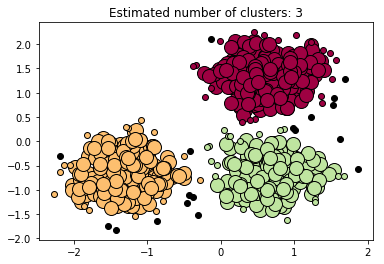

In [28]:

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

print(X.shape)
X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [29]:
alldf.size

422868